In [172]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time

img_01 = cv2.imread('tsukuba/scene1.row3.col1.ppm')
img_01 = cv2.cvtColor(img_01,cv2.COLOR_BGR2RGB)
img_02 = cv2.imread('tsukuba/scene1.row3.col2.ppm')
img_0 = cv2.cvtColor(img_02,cv2.COLOR_BGR2RGB)
img_03 = cv2.imread('tsukuba/scene1.row3.col3.ppm')
img_03 = cv2.cvtColor(img_03,cv2.COLOR_BGR2RGB)
img_04 = cv2.imread('tsukuba/scene1.row3.col4.ppm')
img_04 = cv2.cvtColor(img_04,cv2.COLOR_BGR2RGB)
img_05 = cv2.imread('tsukuba/scene1.row3.col5.ppm')
img_05 = cv2.cvtColor(img_05,cv2.COLOR_BGR2RGB)
images = [img_01, img_02, img_03, img_04, img_05]

In [2]:
# OpenCV's own implementation

def gaussian_pyramid_images_cv(img):
    p_imgs = [img]
    for i in np.arange(3):
        img = cv2.pyrDown(img)
        p_imgs.append(img)
    return p_imgs

# Selfimplemented Gaussian Pyramid function.
# Convolves with a Gaussian kernel and then removes all even rows and columns.
# Output is four images at a higher pyramid level and therefore lower resolution. 

def gaussian_pyramid_images(img):
    p_imgs = [img]
    
    for i in np.arange(3):
        img = cv2.GaussianBlur(img, (5,5), 2)
        img_new = []
        for i in np.arange(1,img.shape[0],2):
            img_row = []
            for j in np.arange(1,img.shape[1],2):
                img_row.append(img[i][j])
            img_new.append(img_row)
            
        img = np.array(img_new)
        p_imgs.append(img)
        
    return p_imgs


In [3]:
def plot_images(imgs):
    i, j = len(imgs)//2, len(imgs)//2
    fig, ax = plt.subplots(i, j, figsize=(15,15))
    ii, jj = np.meshgrid(np.arange(i), np.arange(j), indexing='ij')
    axes = [axis for axis in zip(ii.ravel(), jj.ravel())]
    for idx, axis in enumerate(axes):
        ax[axis].imshow(imgs[idx], "gray")
    plt.show()

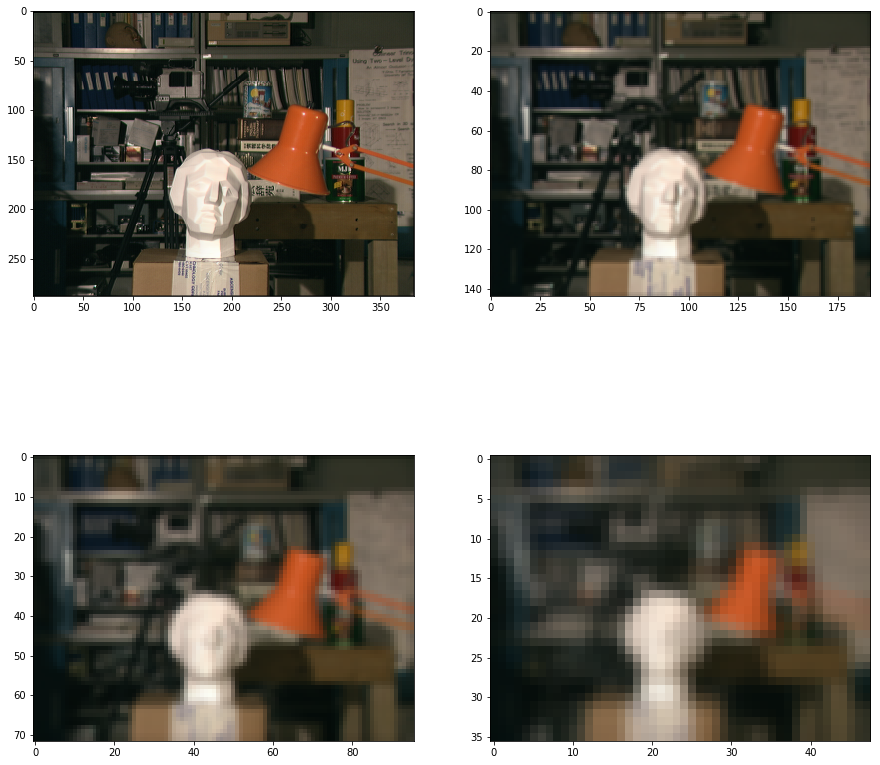

In [4]:
pyramid_images_img1 = gaussian_pyramid_images(img_01)
plot_images(pyramid_images_img1)

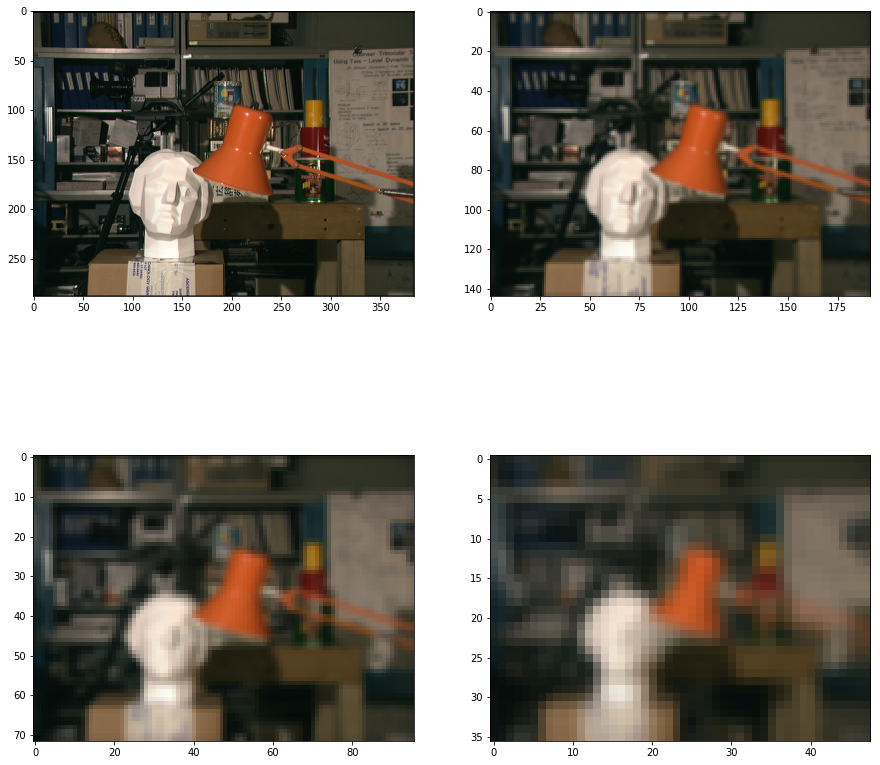

In [5]:
pyramid_images_img5 = gaussian_pyramid_images(img_05)
plot_images(pyramid_images_img5)

In [6]:

def create_patching_kernel(size):
    ii, jj = np.meshgrid(np.arange(-(size//2),size//2+1), np.arange(-(size//2),size//2+1), indexing='ij')
    return np.array([xy for xy in zip(jj.ravel(), ii.ravel())])

def create_image_grid(image):
    ii, jj = np.meshgrid(np.arange(image.shape[0]), np.arange(image.shape[1]), indexing='ij')
    image_grid = []
    for i in np.arange(image.shape[0]):
        image_grid.append([ij for ij in zip(ii[i].ravel(), jj[i].ravel())])
    return np.array(image_grid)

def create_patch_grid(img1, img2, size, M):
    index, column = img1.shape[0], img2.shape[1]
    patch_grid_coords = create_patching_kernel(size)
    final_patch_grid = []
    
    for i in np.arange(index):
        patch_space = [row for row in np.arange(i-(size//2),i+(size//2+1)) if row >= 0 and row <= index-1]
        patched_pixel_row = []
        for j in np.arange(column):
            patch_coords = np.array([np.array([i,j])+ij for ij in patch_grid_coords])
            patch_coords_adj = patch_coords[((patch_coords >= 0).all(axis=1)) \
                                            & ((patch_coords < [index,column]).all(axis=1))]
            patched_pixel_row.append(patch_coords_adj)
        final_patch_grid.append(patched_pixel_row)
        
    return np.array(final_patch_grid)
            

In [7]:
def pextract(img, y):
    patch = np.empty_like(patch0)
    patches = np.empty_like(patches0)
    for x in range(0, ish[1]):
        a = img[y:y+windowsize,x:x+windowsize,:]
        #normalized cross-correlation prep
        a=((a[:,:,0]+a[:,:,1]+a[:,:,2])/3).reshape(length)
        #a =(a[:,:,0]+a[:,:,1]+a[:,:,2])
        #a = a.reshape(length)
        #patch = a / np.std(a)
        patch = (a - np.mean(a)) / np.std(a)
        patches[x] = patch
    return patches

def hpatches(img1, img2, y):
    padded1= cv2.copyMakeBorder(img1,pad,pad,pad,pad,cv2.BORDER_CONSTANT)
    padded2= cv2.copyMakeBorder(img2,pad,pad,pad,pad,cv2.BORDER_CONSTANT)
    patches1 = pextract(padded1, y)
    patches2 = pextract(padded2, y)
    return patches1, patches2

def correspondence(img1,img2, wsize = 5):
    start = time.clock() 
    global windowsize
    windowsize = wsize
    global pad
    pad = (windowsize-1)//2
    global length
    length = windowsize**2
    global ish
    ish = img1.shape
    global psh
    psh = (img1.shape[0]+2*pad,img1.shape[1]+2*pad)
    global patch0
    patch0 = np.empty((windowsize,windowsize))
    global patches0
    patches0 = np.empty((psh[1]-windowsize+1, length))
    result = np.zeros((ish[0], ish[1]))
    result_nonsqrd = np.zeros((ish[0], ish[1]))
    for y in range(ish[0]):
        #print(y)
        patches1, patches2 = hpatches(img1, img2, y)
        for x in range(ish[1]):
            #normalized cross-correlation
            best = -999
            #pa = patches1[x]
            #a = pa / (np.std(pa) * len(pa))
            r = [0, patches2.shape[0]]
            rr = ish[1]//25 #limits search range
            if x - rr > 0:
                r[0] = x - rr
            if x + rr < ish[1]:
                r[1] = x + rr
            for h in range(r[0],r[1]):
                #b = patches2[h] / patches2[h]
                ncc = np.correlate(patches1[x]/length, patches2[h]) 
                if ncc > best:
                    best = ncc
                    besth =h
            result[y,x]=abs(x-besth)**2
            result_nonsqrd[y,x]=x-besth
            #print(best,ncc, x,y,h, besth)
    elapsed = time.clock()
    elapsed = elapsed - start
    print ("Done. Time spent executing correspondence: ", elapsed)
    return result, result_nonsqrd


In [93]:
def run_stereo_matching(img1, img2, windowsize):
    pyramid_images_img1 = gaussian_pyramid_images(img1)
    pyramid_images_img2 = gaussian_pyramid_images(img2)
    
    imgs = []
    for i in np.arange(4):
        disparity_image = correspondence(pyramid_images_img1[i], pyramid_images_img2[i], windowsize)[0]
        imgs.append(disparity_image)
    
    return np.array(imgs)

In [75]:
pyramid_images_imgcv1 = gaussian_pyramid_images_cv(img_01)
pyramid_images_imgcv2 = gaussian_pyramid_images_cv(img_02)
pyramid_images_img1 = gaussian_pyramid_images(img_01)
pyramid_images_img2 = gaussian_pyramid_images(img_02)

imgs_cv = []
for i in np.arange(4):
    imgs_cv.append(correspondence(pyramid_images_imgcv1[i], pyramid_images_imgcv2[i], 7)[0])

imgs = []
for i in np.arange(4):
    imgs.append(correspondence(pyramid_images_img1[i], pyramid_images_img2[i], 7)[0])

Done. Time spent executing correspondence:  26.319192532944726
Done. Time spent executing correspondence:  5.194949430675479
Done. Time spent executing correspondence:  0.8852212754500215
Done. Time spent executing correspondence:  0.2026702083312557
Done. Time spent executing correspondence:  27.665682444734557
Done. Time spent executing correspondence:  4.223906657665793
Done. Time spent executing correspondence:  0.9077037398965331
Done. Time spent executing correspondence:  0.20662132841243874


In [94]:
disparity_all_levels = run_stereo_matching(img_01, img_02, 7)

Done. Time spent executing correspondence:  23.924651187611744
Done. Time spent executing correspondence:  4.92688662494038
Done. Time spent executing correspondence:  0.875429279920354
Done. Time spent executing correspondence:  0.19607392339094076


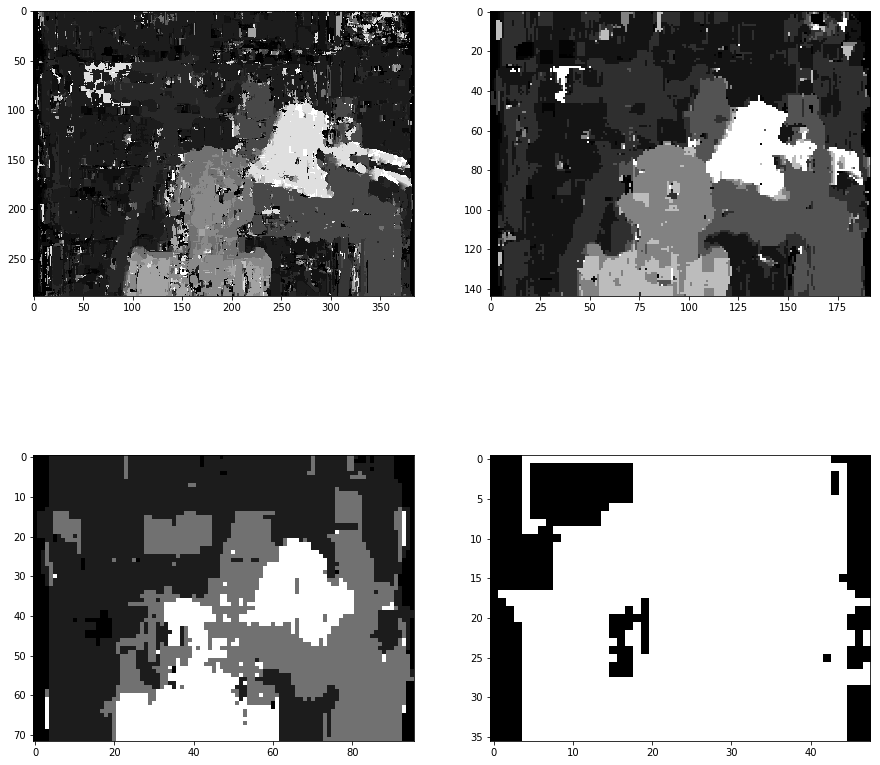

In [95]:
plot_images(disparity_all_levels)


(288, 384)
(288, 384)
(288, 384)
(288, 384)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)


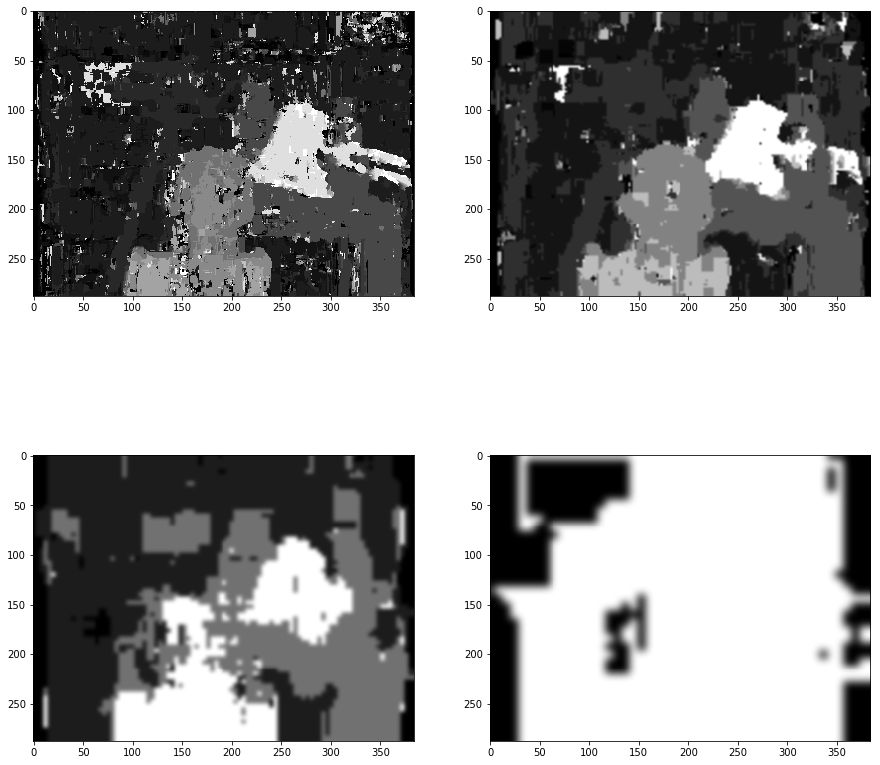

In [201]:
def gaussian_pyramid_images_cv_up(images):
    p_imgs = []
    for i in np.arange(4):
        img = images[i]
        for j in np.arange(i):
            img = cv2.pyrUp(img)
        
        print(img.shape)
        p_imgs.append(img)
    return np.array(p_imgs)

disparity_images_upscaled = gaussian_pyramid_images_cv_up(disparity_all_levels)
image1_upscaled = gaussian_pyramid_images_cv_up(pyramid_images_img1)
image2_upscaled = gaussian_pyramid_images_cv_up(pyramid_images_img2)

plot_images(disparity_images_upscaled)

In [277]:
def correspondence_upscaled(image1, image2, disparity, wsize):
    
    global windowsize
    windowsize = wsize
    global pad
    pad = (windowsize-1)//2
    global length
    length = windowsize**2
    global ish
    ish = image1.shape
    global psh
    psh = (image1.shape[0]+2*pad,image1.shape[1]+2*pad)
    global patch0
    patch0 = np.empty((windowsize,windowsize))
    global patches0
    patches0 = np.empty((psh[1]-windowsize+1, length))
    
    result = np.zeros((ish[0], ish[1]))
    result_nonsqrd = np.zeros((ish[0], ish[1]))
    
    results = []
    results_nonsqrd = []
    
    disp_map = disparity
    #scaling_factor = 
        
    start = time.clock() 

    for y in range(ish[0]):
        #print(ish)
        patches1, patches2 = hpatches(image1, image2, y)

        for x in range(ish[1]):
            #normalized cross-correlation
            best = -999
            #besth = -999

            r = [0, patches2.shape[0]]
            #print(r)
            rr = int(abs(disp_map[y,x]))+1 #limits search range
            #print(rr)
            if x - rr > 0:
                r[0] = x - rr
            if x + rr < ish[1]:
                r[1] = x + rr
            #print(r)
            for h in range(r[0],r[1]):
                ncc = np.correlate(patches1[x]/length, patches2[h]) 

                if ncc > best:
                    best = ncc
                    besth =h

            result[y,x]=abs(x-besth)**2
            result_nonsqrd[y,x]=x-besth

    results.append(result)
    results_nonsqrd.append(result_nonsqrd)

    disp_map = result

    elapsed = time.clock()
    elapsed = elapsed - start
    print ("Done. Time spent executing correspondence: ", elapsed)
    return result, results_nonsqrd


In [238]:
pyramid_images_img1 = gaussian_pyramid_images(img_01)
pyramid_images_img2 = gaussian_pyramid_images(img_02)

#print(pyramid_images_img1[0].shape, pyramid_images_img2[0].shape, disparity_images_upscaled.shape)

level2 = correspondence_upscaled(image1_upscaled[2], image2_upscaled[2], disparity_images_upscaled[3], 7)



1
[0, 1]
1
[0, 2]
1
[1, 3]
1
[2, 4]
1
[3, 5]
1
[4, 6]
1
[5, 7]
1
[6, 8]
1
[7, 9]
1
[8, 10]
1
[9, 11]
1
[10, 12]
1
[11, 13]
1
[12, 14]
1
[13, 15]
1
[14, 16]
1
[15, 17]
1
[16, 18]
1
[17, 19]
1
[18, 20]
1
[19, 21]
1
[20, 22]
1
[21, 23]
1
[22, 24]
1
[23, 25]
1
[24, 26]
1
[25, 27]
1
[26, 28]
1
[27, 29]
1
[28, 30]
1
[29, 31]
1
[30, 32]
1
[31, 33]
1
[32, 34]
1
[33, 35]
1
[34, 36]
1
[35, 37]
1
[36, 38]
1
[37, 39]
1
[38, 40]
1
[39, 41]
1
[40, 42]
1
[41, 43]
1
[42, 44]
1
[43, 45]
1
[44, 46]
1
[45, 47]
1
[46, 48]
1
[47, 49]
1
[48, 50]
1
[49, 51]
1
[50, 52]
1
[51, 53]
1
[52, 54]
1
[53, 55]
1
[54, 56]
1
[55, 57]
1
[56, 58]
1
[57, 59]
1
[58, 60]
1
[59, 61]
1
[60, 62]
1
[61, 63]
1
[62, 64]
1
[63, 65]
1
[64, 66]
1
[65, 67]
1
[66, 68]
1
[67, 69]
1
[68, 70]
1
[69, 71]
1
[70, 72]
1
[71, 73]
1
[72, 74]
1
[73, 75]
1
[74, 76]
1
[75, 77]
1
[76, 78]
1
[77, 79]
1
[78, 80]
1
[79, 81]
1
[80, 82]
1
[81, 83]
1
[82, 84]
1
[83, 85]
1
[84, 86]
1
[85, 87]
1
[86, 88]
1
[87, 89]
1
[88, 90]
1
[89, 91]
1
[90, 92]
1
[91, 9

2
[223, 227]
2
[224, 228]
2
[225, 229]
2
[226, 230]
2
[227, 231]
2
[228, 232]
2
[229, 233]
2
[230, 234]
2
[231, 235]
2
[232, 236]
2
[233, 237]
2
[234, 238]
2
[235, 239]
2
[236, 240]
2
[237, 241]
2
[238, 242]
2
[239, 243]
2
[240, 244]
2
[241, 245]
2
[242, 246]
2
[243, 247]
2
[244, 248]
2
[245, 249]
2
[246, 250]
2
[247, 251]
2
[248, 252]
2
[249, 253]
2
[250, 254]
2
[251, 255]
2
[252, 256]
2
[253, 257]
2
[254, 258]
2
[255, 259]
2
[256, 260]
2
[257, 261]
2
[258, 262]
2
[259, 263]
2
[260, 264]
2
[261, 265]
2
[262, 266]
2
[263, 267]
2
[264, 268]
2
[265, 269]
2
[266, 270]
2
[267, 271]
2
[268, 272]
2
[269, 273]
2
[270, 274]
2
[271, 275]
2
[272, 276]
2
[273, 277]
2
[274, 278]
2
[275, 279]
2
[276, 280]
2
[277, 281]
2
[278, 282]
2
[279, 283]
2
[280, 284]
2
[281, 285]
2
[282, 286]
2
[283, 287]
2
[284, 288]
2
[285, 289]
2
[286, 290]
2
[287, 291]
2
[288, 292]
2
[289, 293]
2
[290, 294]
2
[291, 295]
2
[292, 296]
2
[293, 297]
2
[294, 298]
2
[295, 299]
2
[296, 300]
2
[297, 301]
2
[298, 302]
2
[299, 303]

[324, 328]
2
[325, 329]
2
[326, 330]
2
[327, 331]
1
[329, 331]
1
[330, 332]
1
[331, 333]
1
[332, 334]
1
[333, 335]
1
[334, 336]
1
[335, 337]
1
[336, 338]
1
[337, 339]
1
[338, 340]
1
[339, 341]
1
[340, 342]
1
[341, 343]
1
[342, 344]
1
[343, 345]
1
[344, 346]
1
[345, 347]
1
[346, 348]
1
[347, 349]
1
[348, 350]
1
[349, 351]
1
[350, 352]
1
[351, 353]
1
[352, 354]
1
[353, 355]
1
[354, 356]
1
[355, 357]
1
[356, 358]
1
[357, 359]
1
[358, 360]
1
[359, 361]
1
[360, 362]
1
[361, 363]
1
[362, 364]
1
[363, 365]
1
[364, 366]
1
[365, 367]
1
[366, 368]
1
[367, 369]
1
[368, 370]
1
[369, 371]
1
[370, 372]
1
[371, 373]
1
[372, 374]
1
[373, 375]
1
[374, 376]
1
[375, 377]
1
[376, 378]
1
[377, 379]
1
[378, 380]
1
[379, 381]
1
[380, 382]
1
[381, 383]
1
[382, 384]
1
[0, 1]
1
[0, 2]
1
[1, 3]
1
[2, 4]
1
[3, 5]
1
[4, 6]
1
[5, 7]
1
[6, 8]
1
[7, 9]
1
[8, 10]
1
[9, 11]
1
[10, 12]
1
[11, 13]
1
[12, 14]
1
[13, 15]
1
[14, 16]
1
[15, 17]
1
[16, 18]
1
[17, 19]
1
[18, 20]
1
[19, 21]
1
[20, 22]
1
[21, 23]
1
[22, 24]
1
[2

[377, 379]
1
[378, 380]
1
[379, 381]
1
[380, 382]
1
[381, 383]
1
[382, 384]
1
[0, 1]
1
[0, 2]
1
[1, 3]
1
[2, 4]
1
[3, 5]
1
[4, 6]
1
[5, 7]
1
[6, 8]
1
[7, 9]
1
[8, 10]
1
[9, 11]
1
[10, 12]
1
[11, 13]
1
[12, 14]
1
[13, 15]
1
[14, 16]
1
[15, 17]
1
[16, 18]
1
[17, 19]
1
[18, 20]
1
[19, 21]
1
[20, 22]
1
[21, 23]
1
[22, 24]
1
[23, 25]
1
[24, 26]
1
[25, 27]
1
[26, 28]
1
[27, 29]
1
[28, 30]
1
[29, 31]
1
[30, 32]
1
[31, 33]
1
[32, 34]
1
[33, 35]
1
[34, 36]
1
[35, 37]
1
[36, 38]
1
[37, 39]
1
[38, 40]
1
[39, 41]
1
[40, 42]
1
[41, 43]
1
[42, 44]
1
[43, 45]
1
[44, 46]
1
[45, 47]
1
[46, 48]
1
[47, 49]
1
[48, 50]
1
[49, 51]
1
[50, 52]
1
[51, 53]
1
[52, 54]
1
[53, 55]
1
[54, 56]
1
[55, 57]
1
[56, 58]
1
[57, 59]
1
[58, 60]
1
[59, 61]
1
[60, 62]
1
[61, 63]
1
[62, 64]
1
[63, 65]
1
[64, 66]
1
[65, 67]
1
[66, 68]
1
[67, 69]
1
[68, 70]
1
[69, 71]
1
[70, 72]
1
[71, 73]
1
[72, 74]
1
[73, 75]
1
[74, 76]
1
[75, 77]
1
[76, 78]
1
[77, 79]
1
[78, 80]
1
[79, 81]
1
[80, 82]
1
[81, 83]
1
[82, 84]
1
[83, 85]
1
[84, 86

C:\Users\Usert\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Usert\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in greater


[35, 37]
1
[36, 38]
1
[37, 39]
1
[38, 40]
1
[39, 41]
1
[40, 42]
1
[41, 43]
1
[42, 44]
1
[43, 45]
1
[44, 46]
1
[45, 47]
1
[46, 48]
1
[47, 49]
1
[48, 50]
1
[49, 51]
1
[50, 52]
1
[51, 53]
1
[52, 54]
1
[53, 55]
1
[54, 56]
1
[55, 57]
1
[56, 58]
1
[57, 59]
1
[58, 60]
1
[59, 61]
1
[60, 62]
1
[61, 63]
1
[62, 64]
1
[63, 65]
1
[64, 66]
1
[65, 67]
1
[66, 68]
1
[67, 69]
1
[68, 70]
1
[69, 71]
1
[70, 72]
1
[71, 73]
1
[72, 74]
1
[73, 75]
1
[74, 76]
1
[75, 77]
1
[76, 78]
1
[77, 79]
1
[78, 80]
1
[79, 81]
1
[80, 82]
1
[81, 83]
1
[82, 84]
1
[83, 85]
1
[84, 86]
1
[85, 87]
1
[86, 88]
1
[87, 89]
1
[88, 90]
1
[89, 91]
1
[90, 92]
1
[91, 93]
1
[92, 94]
1
[93, 95]
1
[94, 96]
1
[95, 97]
1
[96, 98]
1
[97, 99]
1
[98, 100]
1
[99, 101]
1
[100, 102]
1
[101, 103]
1
[102, 104]
1
[103, 105]
1
[104, 106]
1
[105, 107]
1
[106, 108]
1
[107, 109]
1
[108, 110]
1
[109, 111]
1
[110, 112]
1
[111, 113]
1
[112, 114]
1
[113, 115]
1
[114, 116]
1
[115, 117]
1
[116, 118]
1
[117, 119]
1
[118, 120]
1
[119, 121]
1
[120, 122]
1
[121, 123]

[128, 130]
1
[129, 131]
1
[130, 132]
1
[131, 133]
1
[132, 134]
1
[133, 135]
1
[134, 136]
1
[135, 137]
1
[136, 138]
1
[137, 139]
1
[138, 140]
1
[139, 141]
1
[140, 142]
1
[141, 143]
1
[142, 144]
1
[143, 145]
1
[144, 146]
1
[145, 147]
1
[146, 148]
1
[147, 149]
1
[148, 150]
1
[149, 151]
2
[149, 153]
2
[150, 154]
2
[151, 155]
2
[152, 156]
2
[153, 157]
2
[154, 158]
2
[155, 159]
2
[156, 160]
2
[157, 161]
2
[158, 162]
2
[159, 163]
2
[160, 164]
2
[161, 165]
2
[162, 166]
2
[163, 167]
2
[164, 168]
2
[165, 169]
2
[166, 170]
2
[167, 171]
2
[168, 172]
2
[169, 173]
2
[170, 174]
2
[171, 175]
2
[172, 176]
2
[173, 177]
2
[174, 178]
2
[175, 179]
2
[176, 180]
2
[177, 181]
2
[178, 182]
2
[179, 183]
2
[180, 184]
2
[181, 185]
2
[182, 186]
2
[183, 187]
2
[184, 188]
2
[185, 189]
2
[186, 190]
2
[187, 191]
2
[188, 192]
2
[189, 193]
2
[190, 194]
2
[191, 195]
2
[192, 196]
2
[193, 197]
2
[194, 198]
2
[195, 199]
2
[196, 200]
2
[197, 201]
2
[198, 202]
2
[199, 203]
2
[200, 204]
2
[201, 205]
2
[202, 206]
2
[203, 207]
2

1
[111, 113]
1
[112, 114]
1
[113, 115]
1
[114, 116]
1
[115, 117]
1
[116, 118]
1
[117, 119]
1
[118, 120]
1
[119, 121]
1
[120, 122]
1
[121, 123]
1
[122, 124]
1
[123, 125]
1
[124, 126]
1
[125, 127]
1
[126, 128]
1
[127, 129]
1
[128, 130]
1
[129, 131]
1
[130, 132]
1
[131, 133]
1
[132, 134]
1
[133, 135]
1
[134, 136]
1
[135, 137]
1
[136, 138]
1
[137, 139]
1
[138, 140]
1
[139, 141]
1
[140, 142]
1
[141, 143]
1
[142, 144]
1
[143, 145]
1
[144, 146]
1
[145, 147]
1
[146, 148]
1
[147, 149]
1
[148, 150]
1
[149, 151]
2
[149, 153]
2
[150, 154]
2
[151, 155]
2
[152, 156]
2
[153, 157]
2
[154, 158]
2
[155, 159]
2
[156, 160]
2
[157, 161]
2
[158, 162]
2
[159, 163]
2
[160, 164]
2
[161, 165]
2
[162, 166]
2
[163, 167]
2
[164, 168]
2
[165, 169]
2
[166, 170]
2
[167, 171]
2
[168, 172]
2
[169, 173]
2
[170, 174]
2
[171, 175]
2
[172, 176]
2
[173, 177]
2
[174, 178]
2
[175, 179]
2
[176, 180]
2
[177, 181]
2
[178, 182]
2
[179, 183]
2
[180, 184]
2
[181, 185]
2
[182, 186]
2
[183, 187]
2
[184, 188]
2
[185, 189]
2
[186, 190]

[198, 202]
2
[199, 203]
2
[200, 204]
2
[201, 205]
2
[202, 206]
2
[203, 207]
2
[204, 208]
2
[205, 209]
2
[206, 210]
2
[207, 211]
2
[208, 212]
2
[209, 213]
2
[210, 214]
2
[211, 215]
2
[212, 216]
2
[213, 217]
2
[214, 218]
2
[215, 219]
2
[216, 220]
2
[217, 221]
2
[218, 222]
2
[219, 223]
2
[220, 224]
2
[221, 225]
2
[222, 226]
2
[223, 227]
2
[224, 228]
2
[225, 229]
2
[226, 230]
2
[227, 231]
2
[228, 232]
2
[229, 233]
2
[230, 234]
2
[231, 235]
2
[232, 236]
2
[233, 237]
2
[234, 238]
2
[235, 239]
2
[236, 240]
2
[237, 241]
2
[238, 242]
2
[239, 243]
2
[240, 244]
2
[241, 245]
2
[242, 246]
2
[243, 247]
2
[244, 248]
2
[245, 249]
2
[246, 250]
2
[247, 251]
2
[248, 252]
2
[249, 253]
2
[250, 254]
2
[251, 255]
2
[252, 256]
2
[253, 257]
2
[254, 258]
2
[255, 259]
2
[256, 260]
2
[257, 261]
2
[258, 262]
2
[259, 263]
2
[260, 264]
2
[261, 265]
2
[262, 266]
2
[263, 267]
2
[264, 268]
2
[265, 269]
2
[266, 270]
2
[267, 271]
2
[268, 272]
2
[269, 273]
2
[270, 274]
2
[271, 275]
2
[272, 276]
2
[273, 277]
2
[274, 278]
2

2
[325, 329]
2
[326, 330]
2
[327, 331]
1
[329, 331]
1
[330, 332]
1
[331, 333]
1
[332, 334]
1
[333, 335]
1
[334, 336]
1
[335, 337]
1
[336, 338]
1
[337, 339]
1
[338, 340]
1
[339, 341]
1
[340, 342]
1
[341, 343]
1
[342, 344]
1
[343, 345]
1
[344, 346]
1
[345, 347]
1
[346, 348]
1
[347, 349]
1
[348, 350]
1
[349, 351]
1
[350, 352]
1
[351, 353]
1
[352, 354]
1
[353, 355]
1
[354, 356]
1
[355, 357]
1
[356, 358]
1
[357, 359]
1
[358, 360]
1
[359, 361]
1
[360, 362]
1
[361, 363]
1
[362, 364]
1
[363, 365]
1
[364, 366]
1
[365, 367]
1
[366, 368]
1
[367, 369]
1
[368, 370]
1
[369, 371]
1
[370, 372]
1
[371, 373]
1
[372, 374]
1
[373, 375]
1
[374, 376]
1
[375, 377]
1
[376, 378]
1
[377, 379]
1
[378, 380]
1
[379, 381]
1
[380, 382]
1
[381, 383]
1
[382, 384]
1
[0, 1]
1
[0, 2]
1
[1, 3]
1
[2, 4]
1
[3, 5]
1
[4, 6]
1
[5, 7]
1
[6, 8]
1
[7, 9]
1
[8, 10]
1
[9, 11]
1
[10, 12]
1
[11, 13]
1
[12, 14]
1
[13, 15]
1
[14, 16]
1
[15, 17]
1
[16, 18]
1
[17, 19]
1
[18, 20]
1
[19, 21]
1
[20, 22]
1
[21, 23]
1
[22, 24]
1
[23, 25]
1
[2

[34, 36]
1
[35, 37]
1
[36, 38]
1
[37, 39]
1
[38, 40]
1
[39, 41]
1
[40, 42]
1
[41, 43]
1
[42, 44]
1
[43, 45]
1
[44, 46]
1
[45, 47]
1
[46, 48]
1
[47, 49]
1
[48, 50]
1
[49, 51]
1
[50, 52]
1
[51, 53]
1
[52, 54]
1
[53, 55]
1
[54, 56]
1
[55, 57]
1
[56, 58]
1
[57, 59]
1
[58, 60]
1
[59, 61]
1
[60, 62]
1
[61, 63]
1
[62, 64]
1
[63, 65]
1
[64, 66]
1
[65, 67]
1
[66, 68]
1
[67, 69]
1
[68, 70]
1
[69, 71]
1
[70, 72]
1
[71, 73]
1
[72, 74]
1
[73, 75]
1
[74, 76]
1
[75, 77]
1
[76, 78]
1
[77, 79]
1
[78, 80]
1
[79, 81]
1
[80, 82]
1
[81, 83]
1
[82, 84]
1
[83, 85]
1
[84, 86]
1
[85, 87]
1
[86, 88]
1
[87, 89]
1
[88, 90]
1
[89, 91]
1
[90, 92]
1
[91, 93]
1
[92, 94]
1
[93, 95]
1
[94, 96]
1
[95, 97]
1
[96, 98]
1
[97, 99]
1
[98, 100]
1
[99, 101]
1
[100, 102]
1
[101, 103]
1
[102, 104]
1
[103, 105]
1
[104, 106]
1
[105, 107]
1
[106, 108]
1
[107, 109]
1
[108, 110]
1
[109, 111]
1
[110, 112]
1
[111, 113]
1
[112, 114]
1
[113, 115]
1
[114, 116]
1
[115, 117]
1
[116, 118]
1
[117, 119]
1
[118, 120]
1
[119, 121]
1
[120, 122]
1

1
[66, 68]
1
[67, 69]
1
[68, 70]
1
[69, 71]
1
[70, 72]
1
[71, 73]
1
[72, 74]
1
[73, 75]
1
[74, 76]
1
[75, 77]
1
[76, 78]
1
[77, 79]
1
[78, 80]
1
[79, 81]
1
[80, 82]
1
[81, 83]
1
[82, 84]
1
[83, 85]
1
[84, 86]
1
[85, 87]
1
[86, 88]
1
[87, 89]
1
[88, 90]
1
[89, 91]
1
[90, 92]
1
[91, 93]
1
[92, 94]
1
[93, 95]
1
[94, 96]
1
[95, 97]
1
[96, 98]
1
[97, 99]
1
[98, 100]
1
[99, 101]
1
[100, 102]
1
[101, 103]
1
[102, 104]
1
[103, 105]
1
[104, 106]
1
[105, 107]
1
[106, 108]
1
[107, 109]
1
[108, 110]
1
[109, 111]
1
[110, 112]
1
[111, 113]
1
[112, 114]
1
[113, 115]
1
[114, 116]
1
[115, 117]
1
[116, 118]
1
[117, 119]
1
[118, 120]
1
[119, 121]
1
[120, 122]
1
[121, 123]
1
[122, 124]
1
[123, 125]
1
[124, 126]
1
[125, 127]
1
[126, 128]
1
[127, 129]
1
[128, 130]
1
[129, 131]
1
[130, 132]
1
[131, 133]
1
[132, 134]
1
[133, 135]
1
[134, 136]
1
[135, 137]
1
[136, 138]
1
[137, 139]
1
[138, 140]
1
[139, 141]
1
[140, 142]
1
[141, 143]
1
[142, 144]
1
[143, 145]
1
[144, 146]
1
[145, 147]
1
[146, 148]
1
[147, 149]


1
[41, 43]
1
[42, 44]
1
[43, 45]
1
[44, 46]
1
[45, 47]
1
[46, 48]
1
[47, 49]
1
[48, 50]
1
[49, 51]
1
[50, 52]
1
[51, 53]
1
[52, 54]
1
[53, 55]
1
[54, 56]
1
[55, 57]
1
[56, 58]
1
[57, 59]
1
[58, 60]
1
[59, 61]
1
[60, 62]
1
[61, 63]
1
[62, 64]
1
[63, 65]
1
[64, 66]
1
[65, 67]
1
[66, 68]
1
[67, 69]
1
[68, 70]
1
[69, 71]
1
[70, 72]
1
[71, 73]
1
[72, 74]
1
[73, 75]
1
[74, 76]
1
[75, 77]
1
[76, 78]
1
[77, 79]
1
[78, 80]
1
[79, 81]
1
[80, 82]
1
[81, 83]
1
[82, 84]
1
[83, 85]
1
[84, 86]
1
[85, 87]
1
[86, 88]
1
[87, 89]
1
[88, 90]
1
[89, 91]
1
[90, 92]
1
[91, 93]
1
[92, 94]
1
[93, 95]
1
[94, 96]
1
[95, 97]
1
[96, 98]
1
[97, 99]
1
[98, 100]
1
[99, 101]
1
[100, 102]
1
[101, 103]
1
[102, 104]
1
[103, 105]
1
[104, 106]
1
[105, 107]
1
[106, 108]
1
[107, 109]
1
[108, 110]
1
[109, 111]
1
[110, 112]
1
[111, 113]
1
[112, 114]
1
[113, 115]
1
[114, 116]
1
[115, 117]
1
[116, 118]
1
[117, 119]
1
[118, 120]
1
[119, 121]
1
[120, 122]
1
[121, 123]
1
[122, 124]
1
[123, 125]
1
[124, 126]
1
[125, 127]
1
[126, 128

[117, 119]
1
[118, 120]
1
[119, 121]
1
[120, 122]
1
[121, 123]
1
[122, 124]
1
[123, 125]
1
[124, 126]
1
[125, 127]
1
[126, 128]
1
[127, 129]
1
[128, 130]
1
[129, 131]
1
[130, 132]
1
[131, 133]
1
[132, 134]
1
[133, 135]
1
[134, 136]
1
[135, 137]
1
[136, 138]
1
[137, 139]
1
[138, 140]
1
[139, 141]
1
[140, 142]
1
[141, 143]
1
[142, 144]
1
[143, 145]
1
[144, 146]
1
[145, 147]
1
[146, 148]
1
[147, 149]
1
[148, 150]
1
[149, 151]
2
[149, 153]
2
[150, 154]
2
[151, 155]
2
[152, 156]
2
[153, 157]
2
[154, 158]
2
[155, 159]
2
[156, 160]
2
[157, 161]
2
[158, 162]
2
[159, 163]
2
[160, 164]
2
[161, 165]
2
[162, 166]
2
[163, 167]
2
[164, 168]
2
[165, 169]
2
[166, 170]
2
[167, 171]
2
[168, 172]
2
[169, 173]
2
[170, 174]
2
[171, 175]
2
[172, 176]
2
[173, 177]
2
[174, 178]
2
[175, 179]
2
[176, 180]
2
[177, 181]
2
[178, 182]
2
[179, 183]
2
[180, 184]
2
[181, 185]
2
[182, 186]
2
[183, 187]
2
[184, 188]
2
[185, 189]
2
[186, 190]
2
[187, 191]
2
[188, 192]
2
[189, 193]
2
[190, 194]
2
[191, 195]
2
[192, 196]
2

[212, 216]
2
[213, 217]
2
[214, 218]
2
[215, 219]
2
[216, 220]
2
[217, 221]
2
[218, 222]
2
[219, 223]
2
[220, 224]
2
[221, 225]
2
[222, 226]
2
[223, 227]
2
[224, 228]
2
[225, 229]
2
[226, 230]
2
[227, 231]
2
[228, 232]
2
[229, 233]
2
[230, 234]
2
[231, 235]
2
[232, 236]
2
[233, 237]
2
[234, 238]
2
[235, 239]
2
[236, 240]
2
[237, 241]
2
[238, 242]
2
[239, 243]
2
[240, 244]
2
[241, 245]
2
[242, 246]
2
[243, 247]
2
[244, 248]
2
[245, 249]
2
[246, 250]
2
[247, 251]
2
[248, 252]
2
[249, 253]
2
[250, 254]
2
[251, 255]
2
[252, 256]
2
[253, 257]
2
[254, 258]
2
[255, 259]
2
[256, 260]
2
[257, 261]
2
[258, 262]
2
[259, 263]
2
[260, 264]
2
[261, 265]
2
[262, 266]
2
[263, 267]
2
[264, 268]
2
[265, 269]
2
[266, 270]
2
[267, 271]
2
[268, 272]
2
[269, 273]
2
[270, 274]
2
[271, 275]
2
[272, 276]
2
[273, 277]
2
[274, 278]
2
[275, 279]
2
[276, 280]
2
[277, 281]
2
[278, 282]
2
[279, 283]
2
[280, 284]
2
[281, 285]
2
[282, 286]
2
[283, 287]
2
[284, 288]
2
[285, 289]
2
[286, 290]
2
[287, 291]
2
[288, 292]
2

[333, 335]
1
[334, 336]
1
[335, 337]
1
[336, 338]
1
[337, 339]
1
[338, 340]
1
[339, 341]
1
[340, 342]
1
[341, 343]
1
[342, 344]
1
[343, 345]
1
[344, 346]
1
[345, 347]
1
[346, 348]
1
[347, 349]
1
[348, 350]
1
[349, 351]
1
[350, 352]
1
[351, 353]
1
[352, 354]
1
[353, 355]
1
[354, 356]
1
[355, 357]
1
[356, 358]
1
[357, 359]
1
[358, 360]
1
[359, 361]
1
[360, 362]
1
[361, 363]
1
[362, 364]
1
[363, 365]
1
[364, 366]
1
[365, 367]
1
[366, 368]
1
[367, 369]
1
[368, 370]
1
[369, 371]
1
[370, 372]
1
[371, 373]
1
[372, 374]
1
[373, 375]
1
[374, 376]
1
[375, 377]
1
[376, 378]
1
[377, 379]
1
[378, 380]
1
[379, 381]
1
[380, 382]
1
[381, 383]
1
[382, 384]
1
[0, 1]
1
[0, 2]
1
[1, 3]
1
[2, 4]
1
[3, 5]
1
[4, 6]
1
[5, 7]
1
[6, 8]
1
[7, 9]
1
[8, 10]
1
[9, 11]
1
[10, 12]
1
[11, 13]
1
[12, 14]
1
[13, 15]
1
[14, 16]
1
[15, 17]
1
[16, 18]
1
[17, 19]
1
[18, 20]
1
[19, 21]
1
[20, 22]
1
[21, 23]
1
[22, 24]
1
[23, 25]
1
[24, 26]
1
[25, 27]
1
[26, 28]
1
[27, 29]
1
[28, 30]
1
[29, 31]
1
[30, 32]
1
[31, 33]
1
[32, 34

1
[48, 50]
1
[49, 51]
1
[50, 52]
1
[51, 53]
1
[52, 54]
1
[53, 55]
1
[54, 56]
1
[55, 57]
1
[56, 58]
1
[57, 59]
1
[58, 60]
1
[59, 61]
1
[60, 62]
1
[61, 63]
1
[62, 64]
1
[63, 65]
1
[64, 66]
1
[65, 67]
1
[66, 68]
1
[67, 69]
1
[68, 70]
1
[69, 71]
1
[70, 72]
1
[71, 73]
1
[72, 74]
1
[73, 75]
1
[74, 76]
1
[75, 77]
1
[76, 78]
1
[77, 79]
1
[78, 80]
1
[79, 81]
1
[80, 82]
1
[81, 83]
1
[82, 84]
1
[83, 85]
1
[84, 86]
1
[85, 87]
1
[86, 88]
1
[87, 89]
1
[88, 90]
1
[89, 91]
1
[90, 92]
1
[91, 93]
1
[92, 94]
1
[93, 95]
1
[94, 96]
1
[95, 97]
1
[96, 98]
1
[97, 99]
1
[98, 100]
1
[99, 101]
1
[100, 102]
1
[101, 103]
1
[102, 104]
1
[103, 105]
1
[104, 106]
1
[105, 107]
1
[106, 108]
1
[107, 109]
1
[108, 110]
1
[109, 111]
1
[110, 112]
1
[111, 113]
1
[112, 114]
1
[113, 115]
1
[114, 116]
1
[115, 117]
1
[116, 118]
1
[117, 119]
1
[118, 120]
1
[119, 121]
1
[120, 122]
1
[121, 123]
1
[122, 124]
1
[123, 125]
1
[124, 126]
1
[125, 127]
1
[126, 128]
1
[127, 129]
1
[128, 130]
1
[129, 131]
1
[130, 132]
1
[131, 133]
1
[132, 13

[75, 77]
1
[76, 78]
1
[77, 79]
1
[78, 80]
1
[79, 81]
1
[80, 82]
1
[81, 83]
1
[82, 84]
1
[83, 85]
1
[84, 86]
1
[85, 87]
1
[86, 88]
1
[87, 89]
1
[88, 90]
1
[89, 91]
1
[90, 92]
1
[91, 93]
1
[92, 94]
1
[93, 95]
1
[94, 96]
1
[95, 97]
1
[96, 98]
1
[97, 99]
1
[98, 100]
1
[99, 101]
1
[100, 102]
1
[101, 103]
1
[102, 104]
1
[103, 105]
1
[104, 106]
1
[105, 107]
1
[106, 108]
1
[107, 109]
1
[108, 110]
1
[109, 111]
1
[110, 112]
1
[111, 113]
1
[112, 114]
1
[113, 115]
1
[114, 116]
1
[115, 117]
1
[116, 118]
1
[117, 119]
1
[118, 120]
1
[119, 121]
1
[120, 122]
1
[121, 123]
1
[122, 124]
1
[123, 125]
1
[124, 126]
1
[125, 127]
1
[126, 128]
1
[127, 129]
1
[128, 130]
1
[129, 131]
1
[130, 132]
1
[131, 133]
1
[132, 134]
1
[133, 135]
1
[134, 136]
1
[135, 137]
1
[136, 138]
1
[137, 139]
1
[138, 140]
1
[139, 141]
1
[140, 142]
1
[141, 143]
1
[142, 144]
1
[143, 145]
1
[144, 146]
1
[145, 147]
1
[146, 148]
1
[147, 149]
1
[148, 150]
1
[149, 151]
2
[149, 153]
2
[150, 154]
2
[151, 155]
2
[152, 156]
2
[153, 157]
2
[154, 15

1
[41, 43]
1
[42, 44]
1
[43, 45]
1
[44, 46]
1
[45, 47]
1
[46, 48]
1
[47, 49]
1
[48, 50]
1
[49, 51]
1
[50, 52]
1
[51, 53]
1
[52, 54]
1
[53, 55]
1
[54, 56]
1
[55, 57]
1
[56, 58]
1
[57, 59]
1
[58, 60]
1
[59, 61]
1
[60, 62]
1
[61, 63]
1
[62, 64]
1
[63, 65]
1
[64, 66]
1
[65, 67]
1
[66, 68]
1
[67, 69]
1
[68, 70]
1
[69, 71]
1
[70, 72]
1
[71, 73]
1
[72, 74]
1
[73, 75]
1
[74, 76]
1
[75, 77]
1
[76, 78]
1
[77, 79]
1
[78, 80]
1
[79, 81]
1
[80, 82]
1
[81, 83]
1
[82, 84]
1
[83, 85]
1
[84, 86]
1
[85, 87]
1
[86, 88]
1
[87, 89]
1
[88, 90]
1
[89, 91]
1
[90, 92]
1
[91, 93]
1
[92, 94]
1
[93, 95]
1
[94, 96]
1
[95, 97]
1
[96, 98]
1
[97, 99]
1
[98, 100]
1
[99, 101]
1
[100, 102]
1
[101, 103]
1
[102, 104]
1
[103, 105]
1
[104, 106]
1
[105, 107]
1
[106, 108]
1
[107, 109]
1
[108, 110]
1
[109, 111]
1
[110, 112]
1
[111, 113]
1
[112, 114]
1
[113, 115]
1
[114, 116]
1
[115, 117]
1
[116, 118]
1
[117, 119]
1
[118, 120]
1
[119, 121]
1
[120, 122]
1
[121, 123]
1
[122, 124]
1
[123, 125]
1
[124, 126]
1
[125, 127]
1
[126, 128

1
[124, 126]
1
[125, 127]
1
[126, 128]
1
[127, 129]
1
[128, 130]
1
[129, 131]
1
[130, 132]
1
[131, 133]
1
[132, 134]
1
[133, 135]
1
[134, 136]
1
[135, 137]
1
[136, 138]
1
[137, 139]
1
[138, 140]
1
[139, 141]
1
[140, 142]
1
[141, 143]
1
[142, 144]
1
[143, 145]
1
[144, 146]
1
[145, 147]
1
[146, 148]
1
[147, 149]
1
[148, 150]
1
[149, 151]
2
[149, 153]
2
[150, 154]
2
[151, 155]
2
[152, 156]
2
[153, 157]
2
[154, 158]
2
[155, 159]
2
[156, 160]
2
[157, 161]
2
[158, 162]
2
[159, 163]
2
[160, 164]
2
[161, 165]
2
[162, 166]
2
[163, 167]
2
[164, 168]
2
[165, 169]
2
[166, 170]
2
[167, 171]
2
[168, 172]
2
[169, 173]
2
[170, 174]
2
[171, 175]
2
[172, 176]
2
[173, 177]
2
[174, 178]
2
[175, 179]
2
[176, 180]
2
[177, 181]
2
[178, 182]
2
[179, 183]
2
[180, 184]
2
[181, 185]
2
[182, 186]
2
[183, 187]
2
[184, 188]
2
[185, 189]
2
[186, 190]
2
[187, 191]
2
[188, 192]
2
[189, 193]
2
[190, 194]
2
[191, 195]
2
[192, 196]
2
[193, 197]
2
[194, 198]
2
[195, 199]
2
[196, 200]
2
[197, 201]
2
[198, 202]
2
[199, 203]

[105, 107]
1
[106, 108]
1
[107, 109]
1
[108, 110]
1
[109, 111]
1
[110, 112]
1
[111, 113]
1
[112, 114]
1
[113, 115]
1
[114, 116]
1
[115, 117]
1
[116, 118]
1
[117, 119]
1
[118, 120]
1
[119, 121]
1
[120, 122]
1
[121, 123]
1
[122, 124]
1
[123, 125]
1
[124, 126]
1
[125, 127]
1
[126, 128]
1
[127, 129]
1
[128, 130]
1
[129, 131]
1
[130, 132]
1
[131, 133]
1
[132, 134]
1
[133, 135]
1
[134, 136]
1
[135, 137]
1
[136, 138]
1
[137, 139]
1
[138, 140]
1
[139, 141]
1
[140, 142]
1
[141, 143]
1
[142, 144]
1
[143, 145]
1
[144, 146]
1
[145, 147]
1
[146, 148]
1
[147, 149]
1
[148, 150]
1
[149, 151]
2
[149, 153]
2
[150, 154]
2
[151, 155]
2
[152, 156]
2
[153, 157]
2
[154, 158]
2
[155, 159]
2
[156, 160]
2
[157, 161]
2
[158, 162]
2
[159, 163]
2
[160, 164]
2
[161, 165]
2
[162, 166]
2
[163, 167]
2
[164, 168]
2
[165, 169]
2
[166, 170]
2
[167, 171]
2
[168, 172]
2
[169, 173]
2
[170, 174]
2
[171, 175]
2
[172, 176]
2
[173, 177]
2
[174, 178]
2
[175, 179]
2
[176, 180]
2
[177, 181]
2
[178, 182]
2
[179, 183]
2
[180, 184]
2

2
[220, 224]
2
[221, 225]
2
[222, 226]
2
[223, 227]
2
[224, 228]
2
[225, 229]
2
[226, 230]
2
[227, 231]
2
[228, 232]
2
[229, 233]
2
[230, 234]
2
[231, 235]
2
[232, 236]
2
[233, 237]
2
[234, 238]
2
[235, 239]
2
[236, 240]
2
[237, 241]
2
[238, 242]
2
[239, 243]
2
[240, 244]
2
[241, 245]
2
[242, 246]
2
[243, 247]
2
[244, 248]
2
[245, 249]
2
[246, 250]
2
[247, 251]
2
[248, 252]
2
[249, 253]
2
[250, 254]
2
[251, 255]
2
[252, 256]
2
[253, 257]
2
[254, 258]
2
[255, 259]
2
[256, 260]
2
[257, 261]
2
[258, 262]
2
[259, 263]
2
[260, 264]
2
[261, 265]
2
[262, 266]
2
[263, 267]
2
[264, 268]
2
[265, 269]
2
[266, 270]
2
[267, 271]
2
[268, 272]
2
[269, 273]
2
[270, 274]
2
[271, 275]
2
[272, 276]
2
[273, 277]
2
[274, 278]
2
[275, 279]
2
[276, 280]
2
[277, 281]
2
[278, 282]
2
[279, 283]
2
[280, 284]
2
[281, 285]
2
[282, 286]
2
[283, 287]
2
[284, 288]
2
[285, 289]
2
[286, 290]
2
[287, 291]
2
[288, 292]
2
[289, 293]
2
[290, 294]
2
[291, 295]
2
[292, 296]
2
[293, 297]
2
[294, 298]
2
[295, 299]
2
[296, 300]

[331, 333]
1
[332, 334]
1
[333, 335]
1
[334, 336]
1
[335, 337]
1
[336, 338]
1
[337, 339]
1
[338, 340]
1
[339, 341]
1
[340, 342]
1
[341, 343]
1
[342, 344]
1
[343, 345]
1
[344, 346]
1
[345, 347]
1
[346, 348]
1
[347, 349]
1
[348, 350]
1
[349, 351]
1
[350, 352]
1
[351, 353]
1
[352, 354]
1
[353, 355]
1
[354, 356]
1
[355, 357]
1
[356, 358]
1
[357, 359]
1
[358, 360]
1
[359, 361]
1
[360, 362]
1
[361, 363]
1
[362, 364]
1
[363, 365]
1
[364, 366]
1
[365, 367]
1
[366, 368]
1
[367, 369]
1
[368, 370]
1
[369, 371]
1
[370, 372]
1
[371, 373]
1
[372, 374]
1
[373, 375]
1
[374, 376]
1
[375, 377]
1
[376, 378]
1
[377, 379]
1
[378, 380]
1
[379, 381]
1
[380, 382]
1
[381, 383]
1
[382, 384]
1
[0, 1]
1
[0, 2]
1
[1, 3]
1
[2, 4]
1
[3, 5]
1
[4, 6]
1
[5, 7]
1
[6, 8]
1
[7, 9]
1
[8, 10]
1
[9, 11]
1
[10, 12]
1
[11, 13]
1
[12, 14]
1
[13, 15]
1
[14, 16]
1
[15, 17]
1
[16, 18]
1
[17, 19]
1
[18, 20]
1
[19, 21]
1
[20, 22]
1
[21, 23]
1
[22, 24]
1
[23, 25]
1
[24, 26]
1
[25, 27]
1
[26, 28]
1
[27, 29]
1
[28, 30]
1
[29, 31]
1
[30

[27, 29]
1
[28, 30]
1
[29, 31]
1
[30, 32]
1
[31, 33]
1
[32, 34]
1
[33, 35]
1
[34, 36]
1
[35, 37]
1
[36, 38]
1
[37, 39]
1
[38, 40]
1
[39, 41]
1
[40, 42]
1
[41, 43]
1
[42, 44]
1
[43, 45]
1
[44, 46]
1
[45, 47]
1
[46, 48]
1
[47, 49]
1
[48, 50]
1
[49, 51]
1
[50, 52]
1
[51, 53]
1
[52, 54]
1
[53, 55]
1
[54, 56]
1
[55, 57]
1
[56, 58]
1
[57, 59]
1
[58, 60]
1
[59, 61]
1
[60, 62]
1
[61, 63]
1
[62, 64]
1
[63, 65]
1
[64, 66]
1
[65, 67]
1
[66, 68]
1
[67, 69]
1
[68, 70]
1
[69, 71]
1
[70, 72]
1
[71, 73]
1
[72, 74]
1
[73, 75]
1
[74, 76]
1
[75, 77]
1
[76, 78]
1
[77, 79]
1
[78, 80]
1
[79, 81]
1
[80, 82]
1
[81, 83]
1
[82, 84]
1
[83, 85]
1
[84, 86]
1
[85, 87]
1
[86, 88]
1
[87, 89]
1
[88, 90]
1
[89, 91]
1
[90, 92]
1
[91, 93]
1
[92, 94]
1
[93, 95]
1
[94, 96]
1
[95, 97]
1
[96, 98]
1
[97, 99]
1
[98, 100]
1
[99, 101]
1
[100, 102]
1
[101, 103]
1
[102, 104]
1
[103, 105]
1
[104, 106]
1
[105, 107]
1
[106, 108]
1
[107, 109]
1
[108, 110]
1
[109, 111]
1
[110, 112]
1
[111, 113]
1
[112, 114]
1
[113, 115]
1
[114, 116]
1


1
[42, 44]
1
[43, 45]
1
[44, 46]
1
[45, 47]
1
[46, 48]
1
[47, 49]
1
[48, 50]
1
[49, 51]
1
[50, 52]
1
[51, 53]
1
[52, 54]
1
[53, 55]
1
[54, 56]
1
[55, 57]
1
[56, 58]
1
[57, 59]
1
[58, 60]
1
[59, 61]
1
[60, 62]
1
[61, 63]
1
[62, 64]
1
[63, 65]
1
[64, 66]
1
[65, 67]
1
[66, 68]
1
[67, 69]
1
[68, 70]
1
[69, 71]
1
[70, 72]
1
[71, 73]
1
[72, 74]
1
[73, 75]
1
[74, 76]
1
[75, 77]
1
[76, 78]
1
[77, 79]
1
[78, 80]
1
[79, 81]
1
[80, 82]
1
[81, 83]
1
[82, 84]
1
[83, 85]
1
[84, 86]
1
[85, 87]
1
[86, 88]
1
[87, 89]
1
[88, 90]
1
[89, 91]
1
[90, 92]
1
[91, 93]
1
[92, 94]
1
[93, 95]
1
[94, 96]
1
[95, 97]
1
[96, 98]
1
[97, 99]
1
[98, 100]
1
[99, 101]
1
[100, 102]
1
[101, 103]
1
[102, 104]
1
[103, 105]
1
[104, 106]
1
[105, 107]
1
[106, 108]
1
[107, 109]
1
[108, 110]
1
[109, 111]
1
[110, 112]
1
[111, 113]
1
[112, 114]
1
[113, 115]
1
[114, 116]
1
[115, 117]
1
[116, 118]
1
[117, 119]
1
[118, 120]
1
[119, 121]
1
[120, 122]
1
[121, 123]
1
[122, 124]
1
[123, 125]
1
[124, 126]
1
[125, 127]
1
[126, 128]
1
[127, 1

[129, 131]
1
[130, 132]
1
[131, 133]
1
[132, 134]
1
[133, 135]
1
[134, 136]
1
[135, 137]
1
[136, 138]
1
[137, 139]
1
[138, 140]
1
[139, 141]
1
[140, 142]
1
[141, 143]
1
[142, 144]
1
[143, 145]
1
[144, 146]
1
[145, 147]
1
[146, 148]
1
[147, 149]
1
[148, 150]
1
[149, 151]
2
[149, 153]
2
[150, 154]
2
[151, 155]
2
[152, 156]
2
[153, 157]
2
[154, 158]
2
[155, 159]
2
[156, 160]
2
[157, 161]
2
[158, 162]
2
[159, 163]
2
[160, 164]
2
[161, 165]
2
[162, 166]
2
[163, 167]
2
[164, 168]
2
[165, 169]
2
[166, 170]
2
[167, 171]
2
[168, 172]
2
[169, 173]
2
[170, 174]
2
[171, 175]
2
[172, 176]
2
[173, 177]
2
[174, 178]
2
[175, 179]
2
[176, 180]
2
[177, 181]
2
[178, 182]
2
[179, 183]
2
[180, 184]
2
[181, 185]
2
[182, 186]
2
[183, 187]
2
[184, 188]
2
[185, 189]
2
[186, 190]
2
[187, 191]
2
[188, 192]
2
[189, 193]
2
[190, 194]
2
[191, 195]
2
[192, 196]
2
[193, 197]
2
[194, 198]
2
[195, 199]
2
[196, 200]
2
[197, 201]
2
[198, 202]
2
[199, 203]
2
[200, 204]
2
[201, 205]
2
[202, 206]
2
[203, 207]
2
[204, 208]
2

[111, 113]
1
[112, 114]
1
[113, 115]
1
[114, 116]
1
[115, 117]
1
[116, 118]
1
[117, 119]
1
[118, 120]
1
[119, 121]
1
[120, 122]
1
[121, 123]
1
[122, 124]
1
[123, 125]
1
[124, 126]
1
[125, 127]
2
[125, 129]
2
[126, 130]
2
[127, 131]
2
[128, 132]
2
[129, 133]
2
[130, 134]
2
[131, 135]
2
[132, 136]
2
[133, 137]
2
[134, 138]
2
[135, 139]
2
[136, 140]
2
[137, 141]
2
[138, 142]
2
[139, 143]
2
[140, 144]
2
[141, 145]
2
[142, 146]
2
[143, 147]
2
[144, 148]
2
[145, 149]
2
[146, 150]
2
[147, 151]
2
[148, 152]
2
[149, 153]
2
[150, 154]
2
[151, 155]
2
[152, 156]
2
[153, 157]
2
[154, 158]
2
[155, 159]
2
[156, 160]
2
[157, 161]
2
[158, 162]
2
[159, 163]
2
[160, 164]
2
[161, 165]
2
[162, 166]
2
[163, 167]
2
[164, 168]
2
[165, 169]
2
[166, 170]
2
[167, 171]
2
[168, 172]
2
[169, 173]
2
[170, 174]
2
[171, 175]
2
[172, 176]
2
[173, 177]
2
[174, 178]
2
[175, 179]
2
[176, 180]
2
[177, 181]
2
[178, 182]
2
[179, 183]
2
[180, 184]
2
[181, 185]
2
[182, 186]
2
[183, 187]
2
[184, 188]
2
[185, 189]
2
[186, 190]
2

[99, 101]
1
[100, 102]
1
[101, 103]
1
[102, 104]
1
[103, 105]
1
[104, 106]
1
[105, 107]
1
[106, 108]
1
[107, 109]
1
[108, 110]
1
[109, 111]
1
[110, 112]
1
[111, 113]
1
[112, 114]
1
[113, 115]
1
[114, 116]
1
[115, 117]
1
[116, 118]
1
[117, 119]
1
[118, 120]
1
[119, 121]
1
[120, 122]
1
[121, 123]
1
[122, 124]
1
[123, 125]
1
[124, 126]
1
[125, 127]
2
[125, 129]
2
[126, 130]
2
[127, 131]
2
[128, 132]
2
[129, 133]
2
[130, 134]
2
[131, 135]
2
[132, 136]
2
[133, 137]
2
[134, 138]
2
[135, 139]
2
[136, 140]
2
[137, 141]
2
[138, 142]
2
[139, 143]
2
[140, 144]
2
[141, 145]
2
[142, 146]
2
[143, 147]
2
[144, 148]
2
[145, 149]
2
[146, 150]
2
[147, 151]
2
[148, 152]
2
[149, 153]
2
[150, 154]
2
[151, 155]
2
[152, 156]
2
[153, 157]
2
[154, 158]
2
[155, 159]
2
[156, 160]
2
[157, 161]
2
[158, 162]
2
[159, 163]
2
[160, 164]
2
[161, 165]
2
[162, 166]
2
[163, 167]
2
[164, 168]
2
[165, 169]
2
[166, 170]
2
[167, 171]
2
[168, 172]
2
[169, 173]
2
[170, 174]
2
[171, 175]
2
[172, 176]
2
[173, 177]
2
[174, 178]
2


[114, 116]
1
[115, 117]
1
[116, 118]
1
[117, 119]
1
[118, 120]
1
[119, 121]
1
[120, 122]
1
[121, 123]
1
[122, 124]
1
[123, 125]
1
[124, 126]
1
[125, 127]
2
[125, 129]
2
[126, 130]
2
[127, 131]
2
[128, 132]
2
[129, 133]
2
[130, 134]
2
[131, 135]
2
[132, 136]
2
[133, 137]
2
[134, 138]
2
[135, 139]
2
[136, 140]
2
[137, 141]
2
[138, 142]
2
[139, 143]
2
[140, 144]
2
[141, 145]
2
[142, 146]
2
[143, 147]
2
[144, 148]
2
[145, 149]
2
[146, 150]
2
[147, 151]
2
[148, 152]
2
[149, 153]
2
[150, 154]
2
[151, 155]
2
[152, 156]
2
[153, 157]
2
[154, 158]
2
[155, 159]
2
[156, 160]
2
[157, 161]
2
[158, 162]
2
[159, 163]
2
[160, 164]
2
[161, 165]
2
[162, 166]
2
[163, 167]
2
[164, 168]
2
[165, 169]
2
[166, 170]
2
[167, 171]
2
[168, 172]
2
[169, 173]
2
[170, 174]
2
[171, 175]
2
[172, 176]
2
[173, 177]
2
[174, 178]
2
[175, 179]
2
[176, 180]
2
[177, 181]
2
[178, 182]
2
[179, 183]
2
[180, 184]
2
[181, 185]
2
[182, 186]
2
[183, 187]
2
[184, 188]
2
[185, 189]
2
[186, 190]
2
[187, 191]
2
[188, 192]
2
[189, 193]
2

2
[318, 322]
2
[319, 323]
2
[320, 324]
2
[321, 325]
2
[322, 326]
2
[323, 327]
2
[324, 328]
2
[325, 329]
2
[326, 330]
2
[327, 331]
2
[328, 332]
2
[329, 333]
2
[330, 334]
2
[331, 335]
2
[332, 336]
2
[333, 337]
2
[334, 338]
2
[335, 339]
2
[336, 340]
2
[337, 341]
2
[338, 342]
2
[339, 343]
2
[340, 344]
2
[341, 345]
2
[342, 346]
2
[343, 347]
1
[345, 347]
1
[346, 348]
1
[347, 349]
1
[348, 350]
1
[349, 351]
1
[350, 352]
1
[351, 353]
1
[352, 354]
1
[353, 355]
1
[354, 356]
1
[355, 357]
1
[356, 358]
1
[357, 359]
1
[358, 360]
1
[359, 361]
1
[360, 362]
1
[361, 363]
1
[362, 364]
1
[363, 365]
1
[364, 366]
1
[365, 367]
1
[366, 368]
1
[367, 369]
1
[368, 370]
1
[369, 371]
1
[370, 372]
1
[371, 373]
1
[372, 374]
1
[373, 375]
1
[374, 376]
1
[375, 377]
1
[376, 378]
1
[377, 379]
1
[378, 380]
1
[379, 381]
1
[380, 382]
1
[381, 383]
1
[382, 384]
1
[0, 1]
1
[0, 2]
1
[1, 3]
1
[2, 4]
1
[3, 5]
1
[4, 6]
1
[5, 7]
1
[6, 8]
1
[7, 9]
1
[8, 10]
1
[9, 11]
1
[10, 12]
1
[11, 13]
1
[12, 14]
1
[13, 15]
1
[14, 16]
1
[15, 17]
1

[279, 283]
2
[280, 284]
2
[281, 285]
2
[282, 286]
2
[283, 287]
2
[284, 288]
2
[285, 289]
2
[286, 290]
2
[287, 291]
2
[288, 292]
2
[289, 293]
2
[290, 294]
2
[291, 295]
2
[292, 296]
2
[293, 297]
2
[294, 298]
2
[295, 299]
2
[296, 300]
2
[297, 301]
2
[298, 302]
2
[299, 303]
2
[300, 304]
2
[301, 305]
2
[302, 306]
2
[303, 307]
2
[304, 308]
2
[305, 309]
2
[306, 310]
2
[307, 311]
2
[308, 312]
2
[309, 313]
2
[310, 314]
2
[311, 315]
2
[312, 316]
2
[313, 317]
2
[314, 318]
2
[315, 319]
2
[316, 320]
2
[317, 321]
2
[318, 322]
2
[319, 323]
2
[320, 324]
2
[321, 325]
2
[322, 326]
2
[323, 327]
2
[324, 328]
2
[325, 329]
2
[326, 330]
2
[327, 331]
2
[328, 332]
2
[329, 333]
2
[330, 334]
2
[331, 335]
2
[332, 336]
2
[333, 337]
2
[334, 338]
2
[335, 339]
2
[336, 340]
2
[337, 341]
2
[338, 342]
2
[339, 343]
2
[340, 344]
2
[341, 345]
2
[342, 346]
2
[343, 347]
1
[345, 347]
1
[346, 348]
1
[347, 349]
1
[348, 350]
1
[349, 351]
1
[350, 352]
1
[351, 353]
1
[352, 354]
1
[353, 355]
1
[354, 356]
1
[355, 357]
1
[356, 358]
1

[99, 101]
1
[100, 102]
1
[101, 103]
1
[102, 104]
1
[103, 105]
1
[104, 106]
1
[105, 107]
1
[106, 108]
1
[107, 109]
1
[108, 110]
1
[109, 111]
1
[110, 112]
1
[111, 113]
1
[112, 114]
1
[113, 115]
1
[114, 116]
1
[115, 117]
1
[116, 118]
1
[117, 119]
2
[117, 121]
2
[118, 122]
2
[119, 123]
2
[120, 124]
2
[121, 125]
2
[122, 126]
2
[123, 127]
2
[124, 128]
2
[125, 129]
2
[126, 130]
2
[127, 131]
2
[128, 132]
2
[129, 133]
2
[130, 134]
2
[131, 135]
2
[132, 136]
2
[133, 137]
2
[134, 138]
2
[135, 139]
2
[136, 140]
2
[137, 141]
2
[138, 142]
2
[139, 143]
2
[140, 144]
2
[141, 145]
2
[142, 146]
2
[143, 147]
2
[144, 148]
2
[145, 149]
2
[146, 150]
2
[147, 151]
2
[148, 152]
2
[149, 153]
2
[150, 154]
2
[151, 155]
2
[152, 156]
2
[153, 157]
2
[154, 158]
2
[155, 159]
2
[156, 160]
2
[157, 161]
2
[158, 162]
2
[159, 163]
2
[160, 164]
2
[161, 165]
2
[162, 166]
2
[163, 167]
2
[164, 168]
2
[165, 169]
2
[166, 170]
2
[167, 171]
2
[168, 172]
2
[169, 173]
2
[170, 174]
2
[171, 175]
2
[172, 176]
2
[173, 177]
2
[174, 178]
2


1
[101, 103]
1
[102, 104]
1
[103, 105]
1
[104, 106]
1
[105, 107]
1
[106, 108]
1
[107, 109]
1
[108, 110]
1
[109, 111]
1
[110, 112]
1
[111, 113]
1
[112, 114]
1
[113, 115]
1
[114, 116]
1
[115, 117]
1
[116, 118]
1
[117, 119]
2
[117, 121]
2
[118, 122]
2
[119, 123]
2
[120, 124]
2
[121, 125]
2
[122, 126]
2
[123, 127]
2
[124, 128]
2
[125, 129]
2
[126, 130]
2
[127, 131]
2
[128, 132]
2
[129, 133]
2
[130, 134]
2
[131, 135]
2
[132, 136]
2
[133, 137]
2
[134, 138]
2
[135, 139]
2
[136, 140]
2
[137, 141]
2
[138, 142]
2
[139, 143]
2
[140, 144]
2
[141, 145]
2
[142, 146]
2
[143, 147]
2
[144, 148]
2
[145, 149]
2
[146, 150]
2
[147, 151]
2
[148, 152]
2
[149, 153]
2
[150, 154]
2
[151, 155]
2
[152, 156]
2
[153, 157]
2
[154, 158]
2
[155, 159]
2
[156, 160]
2
[157, 161]
2
[158, 162]
2
[159, 163]
2
[160, 164]
2
[161, 165]
2
[162, 166]
2
[163, 167]
2
[164, 168]
2
[165, 169]
2
[166, 170]
2
[167, 171]
2
[168, 172]
2
[169, 173]
2
[170, 174]
2
[171, 175]
2
[172, 176]
2
[173, 177]
2
[174, 178]
2
[175, 179]
2
[176, 180]

[210, 214]
2
[211, 215]
2
[212, 216]
2
[213, 217]
2
[214, 218]
2
[215, 219]
2
[216, 220]
2
[217, 221]
2
[218, 222]
2
[219, 223]
2
[220, 224]
2
[221, 225]
2
[222, 226]
2
[223, 227]
2
[224, 228]
2
[225, 229]
2
[226, 230]
2
[227, 231]
2
[228, 232]
2
[229, 233]
2
[230, 234]
2
[231, 235]
2
[232, 236]
2
[233, 237]
2
[234, 238]
2
[235, 239]
2
[236, 240]
2
[237, 241]
2
[238, 242]
2
[239, 243]
2
[240, 244]
2
[241, 245]
2
[242, 246]
2
[243, 247]
2
[244, 248]
2
[245, 249]
2
[246, 250]
2
[247, 251]
2
[248, 252]
2
[249, 253]
2
[250, 254]
2
[251, 255]
2
[252, 256]
2
[253, 257]
2
[254, 258]
2
[255, 259]
2
[256, 260]
2
[257, 261]
2
[258, 262]
2
[259, 263]
2
[260, 264]
2
[261, 265]
2
[262, 266]
2
[263, 267]
2
[264, 268]
2
[265, 269]
2
[266, 270]
2
[267, 271]
2
[268, 272]
2
[269, 273]
2
[270, 274]
2
[271, 275]
2
[272, 276]
2
[273, 277]
2
[274, 278]
2
[275, 279]
2
[276, 280]
2
[277, 281]
2
[278, 282]
2
[279, 283]
2
[280, 284]
2
[281, 285]
2
[282, 286]
2
[283, 287]
2
[284, 288]
2
[285, 289]
2
[286, 290]
2

[322, 326]
2
[323, 327]
2
[324, 328]
2
[325, 329]
2
[326, 330]
2
[327, 331]
2
[328, 332]
2
[329, 333]
2
[330, 334]
2
[331, 335]
2
[332, 336]
2
[333, 337]
2
[334, 338]
2
[335, 339]
2
[336, 340]
2
[337, 341]
2
[338, 342]
2
[339, 343]
2
[340, 344]
2
[341, 345]
2
[342, 346]
2
[343, 347]
1
[345, 347]
1
[346, 348]
1
[347, 349]
1
[348, 350]
1
[349, 351]
1
[350, 352]
1
[351, 353]
1
[352, 354]
1
[353, 355]
1
[354, 356]
1
[355, 357]
1
[356, 358]
1
[357, 359]
1
[358, 360]
1
[359, 361]
1
[360, 362]
1
[361, 363]
1
[362, 364]
1
[363, 365]
1
[364, 366]
1
[365, 367]
1
[366, 368]
1
[367, 369]
1
[368, 370]
1
[369, 371]
1
[370, 372]
1
[371, 373]
1
[372, 374]
1
[373, 375]
1
[374, 376]
1
[375, 377]
1
[376, 378]
1
[377, 379]
1
[378, 380]
1
[379, 381]
1
[380, 382]
1
[381, 383]
1
[382, 384]
1
[0, 1]
1
[0, 2]
1
[1, 3]
1
[2, 4]
1
[3, 5]
1
[4, 6]
1
[5, 7]
1
[6, 8]
1
[7, 9]
1
[8, 10]
1
[9, 11]
1
[10, 12]
1
[11, 13]
1
[12, 14]
1
[13, 15]
1
[14, 16]
1
[15, 17]
1
[16, 18]
1
[17, 19]
1
[18, 20]
1
[19, 21]
1
[20, 22]


1
[16, 18]
1
[17, 19]
1
[18, 20]
1
[19, 21]
1
[20, 22]
1
[21, 23]
1
[22, 24]
1
[23, 25]
1
[24, 26]
1
[25, 27]
1
[26, 28]
1
[27, 29]
1
[28, 30]
1
[29, 31]
1
[30, 32]
1
[31, 33]
1
[32, 34]
1
[33, 35]
1
[34, 36]
1
[35, 37]
1
[36, 38]
1
[37, 39]
1
[38, 40]
1
[39, 41]
1
[40, 42]
1
[41, 43]
1
[42, 44]
1
[43, 45]
1
[44, 46]
1
[45, 47]
1
[46, 48]
1
[47, 49]
1
[48, 50]
1
[49, 51]
1
[50, 52]
1
[51, 53]
1
[52, 54]
1
[53, 55]
1
[54, 56]
1
[55, 57]
1
[56, 58]
1
[57, 59]
1
[58, 60]
1
[59, 61]
1
[60, 62]
1
[61, 63]
1
[62, 64]
1
[63, 65]
1
[64, 66]
1
[65, 67]
1
[66, 68]
1
[67, 69]
1
[68, 70]
1
[69, 71]
1
[70, 72]
1
[71, 73]
1
[72, 74]
1
[73, 75]
1
[74, 76]
1
[75, 77]
1
[76, 78]
1
[77, 79]
1
[78, 80]
1
[79, 81]
1
[80, 82]
1
[81, 83]
1
[82, 84]
1
[83, 85]
1
[84, 86]
1
[85, 87]
1
[86, 88]
1
[87, 89]
1
[88, 90]
1
[89, 91]
1
[90, 92]
1
[91, 93]
1
[92, 94]
1
[93, 95]
1
[94, 96]
1
[95, 97]
1
[96, 98]
1
[97, 99]
1
[98, 100]
1
[99, 101]
1
[100, 102]
1
[101, 103]
1
[102, 104]
1
[103, 105]
1
[104, 106]
1
[105, 1

[27, 29]
1
[28, 30]
1
[29, 31]
1
[30, 32]
1
[31, 33]
1
[32, 34]
1
[33, 35]
1
[34, 36]
1
[35, 37]
1
[36, 38]
1
[37, 39]
1
[38, 40]
1
[39, 41]
1
[40, 42]
1
[41, 43]
1
[42, 44]
1
[43, 45]
1
[44, 46]
1
[45, 47]
1
[46, 48]
1
[47, 49]
1
[48, 50]
1
[49, 51]
1
[50, 52]
1
[51, 53]
1
[52, 54]
1
[53, 55]
1
[54, 56]
1
[55, 57]
1
[56, 58]
1
[57, 59]
1
[58, 60]
1
[59, 61]
1
[60, 62]
1
[61, 63]
1
[62, 64]
1
[63, 65]
1
[64, 66]
1
[65, 67]
1
[66, 68]
1
[67, 69]
1
[68, 70]
1
[69, 71]
1
[70, 72]
1
[71, 73]
1
[72, 74]
1
[73, 75]
1
[74, 76]
1
[75, 77]
1
[76, 78]
1
[77, 79]
2
[77, 81]
2
[78, 82]
2
[79, 83]
2
[80, 84]
2
[81, 85]
2
[82, 86]
2
[83, 87]
2
[84, 88]
2
[85, 89]
2
[86, 90]
2
[87, 91]
2
[88, 92]
2
[89, 93]
2
[90, 94]
2
[91, 95]
2
[92, 96]
2
[93, 97]
2
[94, 98]
2
[95, 99]
2
[96, 100]
2
[97, 101]
2
[98, 102]
2
[99, 103]
2
[100, 104]
2
[101, 105]
2
[102, 106]
2
[103, 107]
2
[104, 108]
2
[105, 109]
2
[106, 110]
2
[107, 111]
2
[108, 112]
2
[109, 113]
2
[110, 114]
2
[111, 115]
2
[112, 116]
2
[113, 117]
2


2
[123, 127]
2
[124, 128]
2
[125, 129]
2
[126, 130]
2
[127, 131]
2
[128, 132]
2
[129, 133]
2
[130, 134]
2
[131, 135]
2
[132, 136]
2
[133, 137]
2
[134, 138]
2
[135, 139]
2
[136, 140]
2
[137, 141]
2
[138, 142]
2
[139, 143]
2
[140, 144]
2
[141, 145]
2
[142, 146]
2
[143, 147]
2
[144, 148]
2
[145, 149]
2
[146, 150]
2
[147, 151]
2
[148, 152]
2
[149, 153]
2
[150, 154]
2
[151, 155]
2
[152, 156]
2
[153, 157]
2
[154, 158]
2
[155, 159]
2
[156, 160]
2
[157, 161]
2
[158, 162]
2
[159, 163]
2
[160, 164]
2
[161, 165]
2
[162, 166]
2
[163, 167]
2
[164, 168]
2
[165, 169]
2
[166, 170]
2
[167, 171]
2
[168, 172]
2
[169, 173]
2
[170, 174]
2
[171, 175]
2
[172, 176]
2
[173, 177]
2
[174, 178]
2
[175, 179]
2
[176, 180]
2
[177, 181]
2
[178, 182]
2
[179, 183]
2
[180, 184]
2
[181, 185]
2
[182, 186]
2
[183, 187]
2
[184, 188]
2
[185, 189]
2
[186, 190]
2
[187, 191]
2
[188, 192]
2
[189, 193]
2
[190, 194]
2
[191, 195]
2
[192, 196]
2
[193, 197]
2
[194, 198]
2
[195, 199]
2
[196, 200]
2
[197, 201]
2
[198, 202]
2
[199, 203]

[225, 229]
2
[226, 230]
2
[227, 231]
2
[228, 232]
2
[229, 233]
2
[230, 234]
2
[231, 235]
2
[232, 236]
2
[233, 237]
2
[234, 238]
2
[235, 239]
2
[236, 240]
2
[237, 241]
2
[238, 242]
2
[239, 243]
2
[240, 244]
2
[241, 245]
2
[242, 246]
2
[243, 247]
2
[244, 248]
2
[245, 249]
2
[246, 250]
2
[247, 251]
2
[248, 252]
2
[249, 253]
2
[250, 254]
2
[251, 255]
2
[252, 256]
2
[253, 257]
2
[254, 258]
2
[255, 259]
2
[256, 260]
2
[257, 261]
2
[258, 262]
2
[259, 263]
2
[260, 264]
2
[261, 265]
2
[262, 266]
2
[263, 267]
2
[264, 268]
2
[265, 269]
2
[266, 270]
2
[267, 271]
2
[268, 272]
2
[269, 273]
2
[270, 274]
2
[271, 275]
2
[272, 276]
2
[273, 277]
2
[274, 278]
2
[275, 279]
2
[276, 280]
2
[277, 281]
2
[278, 282]
2
[279, 283]
2
[280, 284]
2
[281, 285]
2
[282, 286]
2
[283, 287]
2
[284, 288]
2
[285, 289]
2
[286, 290]
2
[287, 291]
2
[288, 292]
2
[289, 293]
2
[290, 294]
2
[291, 295]
2
[292, 296]
2
[293, 297]
2
[294, 298]
2
[295, 299]
2
[296, 300]
2
[297, 301]
2
[298, 302]
2
[299, 303]
2
[300, 304]
2
[301, 305]
2

[8, 10]
1
[9, 11]
1
[10, 12]
1
[11, 13]
1
[12, 14]
1
[13, 15]
1
[14, 16]
1
[15, 17]
1
[16, 18]
1
[17, 19]
1
[18, 20]
1
[19, 21]
1
[20, 22]
1
[21, 23]
1
[22, 24]
1
[23, 25]
1
[24, 26]
1
[25, 27]
1
[26, 28]
1
[27, 29]
1
[28, 30]
1
[29, 31]
1
[30, 32]
1
[31, 33]
1
[32, 34]
1
[33, 35]
1
[34, 36]
1
[35, 37]
1
[36, 38]
1
[37, 39]
1
[38, 40]
1
[39, 41]
1
[40, 42]
1
[41, 43]
1
[42, 44]
1
[43, 45]
1
[44, 46]
1
[45, 47]
1
[46, 48]
1
[47, 49]
1
[48, 50]
1
[49, 51]
1
[50, 52]
1
[51, 53]
1
[52, 54]
1
[53, 55]
1
[54, 56]
1
[55, 57]
1
[56, 58]
1
[57, 59]
1
[58, 60]
1
[59, 61]
1
[60, 62]
1
[61, 63]
1
[62, 64]
1
[63, 65]
1
[64, 66]
1
[65, 67]
1
[66, 68]
1
[67, 69]
1
[68, 70]
1
[69, 71]
1
[70, 72]
1
[71, 73]
1
[72, 74]
1
[73, 75]
1
[74, 76]
1
[75, 77]
1
[76, 78]
1
[77, 79]
2
[77, 81]
2
[78, 82]
2
[79, 83]
2
[80, 84]
2
[81, 85]
2
[82, 86]
2
[83, 87]
2
[84, 88]
2
[85, 89]
2
[86, 90]
2
[87, 91]
2
[88, 92]
2
[89, 93]
2
[90, 94]
2
[91, 95]
2
[92, 96]
2
[93, 97]
2
[94, 98]
2
[95, 99]
2
[96, 100]
2
[97, 101]
2

[52, 54]
1
[53, 55]
1
[54, 56]
1
[55, 57]
1
[56, 58]
1
[57, 59]
1
[58, 60]
1
[59, 61]
1
[60, 62]
1
[61, 63]
1
[62, 64]
1
[63, 65]
1
[64, 66]
1
[65, 67]
1
[66, 68]
1
[67, 69]
1
[68, 70]
1
[69, 71]
1
[70, 72]
1
[71, 73]
1
[72, 74]
1
[73, 75]
1
[74, 76]
1
[75, 77]
1
[76, 78]
1
[77, 79]
2
[77, 81]
2
[78, 82]
2
[79, 83]
2
[80, 84]
2
[81, 85]
2
[82, 86]
2
[83, 87]
2
[84, 88]
2
[85, 89]
2
[86, 90]
2
[87, 91]
2
[88, 92]
2
[89, 93]
2
[90, 94]
2
[91, 95]
2
[92, 96]
2
[93, 97]
2
[94, 98]
2
[95, 99]
2
[96, 100]
2
[97, 101]
2
[98, 102]
2
[99, 103]
2
[100, 104]
2
[101, 105]
2
[102, 106]
2
[103, 107]
2
[104, 108]
2
[105, 109]
2
[106, 110]
2
[107, 111]
2
[108, 112]
2
[109, 113]
2
[110, 114]
2
[111, 115]
2
[112, 116]
2
[113, 117]
2
[114, 118]
2
[115, 119]
2
[116, 120]
2
[117, 121]
2
[118, 122]
2
[119, 123]
2
[120, 124]
2
[121, 125]
2
[122, 126]
2
[123, 127]
2
[124, 128]
2
[125, 129]
2
[126, 130]
2
[127, 131]
2
[128, 132]
2
[129, 133]
2
[130, 134]
2
[131, 135]
2
[132, 136]
2
[133, 137]
2
[134, 138]
2
[1

[214, 218]
2
[215, 219]
2
[216, 220]
2
[217, 221]
2
[218, 222]
2
[219, 223]
2
[220, 224]
2
[221, 225]
2
[222, 226]
2
[223, 227]
2
[224, 228]
2
[225, 229]
2
[226, 230]
2
[227, 231]
2
[228, 232]
2
[229, 233]
2
[230, 234]
2
[231, 235]
2
[232, 236]
2
[233, 237]
2
[234, 238]
2
[235, 239]
2
[236, 240]
2
[237, 241]
2
[238, 242]
2
[239, 243]
2
[240, 244]
2
[241, 245]
2
[242, 246]
2
[243, 247]
2
[244, 248]
2
[245, 249]
2
[246, 250]
2
[247, 251]
2
[248, 252]
2
[249, 253]
2
[250, 254]
2
[251, 255]
2
[252, 256]
2
[253, 257]
2
[254, 258]
2
[255, 259]
2
[256, 260]
2
[257, 261]
2
[258, 262]
2
[259, 263]
2
[260, 264]
2
[261, 265]
2
[262, 266]
2
[263, 267]
2
[264, 268]
2
[265, 269]
2
[266, 270]
2
[267, 271]
2
[268, 272]
2
[269, 273]
2
[270, 274]
2
[271, 275]
2
[272, 276]
2
[273, 277]
2
[274, 278]
2
[275, 279]
2
[276, 280]
2
[277, 281]
2
[278, 282]
2
[279, 283]
2
[280, 284]
2
[281, 285]
2
[282, 286]
2
[283, 287]
2
[284, 288]
2
[285, 289]
2
[286, 290]
2
[287, 291]
2
[288, 292]
2
[289, 293]
2
[290, 294]
2

[303, 307]
2
[304, 308]
2
[305, 309]
2
[306, 310]
2
[307, 311]
2
[308, 312]
2
[309, 313]
2
[310, 314]
2
[311, 315]
2
[312, 316]
2
[313, 317]
2
[314, 318]
2
[315, 319]
2
[316, 320]
2
[317, 321]
2
[318, 322]
2
[319, 323]
2
[320, 324]
2
[321, 325]
2
[322, 326]
2
[323, 327]
2
[324, 328]
2
[325, 329]
2
[326, 330]
2
[327, 331]
2
[328, 332]
2
[329, 333]
2
[330, 334]
2
[331, 335]
2
[332, 336]
2
[333, 337]
2
[334, 338]
2
[335, 339]
2
[336, 340]
2
[337, 341]
2
[338, 342]
2
[339, 343]
2
[340, 344]
2
[341, 345]
2
[342, 346]
2
[343, 347]
1
[345, 347]
1
[346, 348]
1
[347, 349]
1
[348, 350]
1
[349, 351]
1
[350, 352]
1
[351, 353]
1
[352, 354]
1
[353, 355]
1
[354, 356]
1
[355, 357]
1
[356, 358]
1
[357, 359]
1
[358, 360]
1
[359, 361]
1
[360, 362]
1
[361, 363]
1
[362, 364]
1
[363, 365]
1
[364, 366]
1
[365, 367]
1
[366, 368]
1
[367, 369]
1
[368, 370]
1
[369, 371]
1
[370, 372]
1
[371, 373]
1
[372, 374]
1
[373, 375]
1
[374, 376]
1
[375, 377]
1
[376, 378]
1
[377, 379]
1
[378, 380]
1
[379, 381]
1
[380, 382]
1

2
[112, 116]
2
[113, 117]
2
[114, 118]
2
[115, 119]
2
[116, 120]
2
[117, 121]
2
[118, 122]
2
[119, 123]
2
[120, 124]
2
[121, 125]
2
[122, 126]
2
[123, 127]
2
[124, 128]
2
[125, 129]
2
[126, 130]
2
[127, 131]
2
[128, 132]
2
[129, 133]
2
[130, 134]
2
[131, 135]
2
[132, 136]
2
[133, 137]
2
[134, 138]
2
[135, 139]
2
[136, 140]
2
[137, 141]
2
[138, 142]
2
[139, 143]
2
[140, 144]
2
[141, 145]
2
[142, 146]
2
[143, 147]
2
[144, 148]
2
[145, 149]
2
[146, 150]
2
[147, 151]
2
[148, 152]
2
[149, 153]
2
[150, 154]
2
[151, 155]
2
[152, 156]
2
[153, 157]
2
[154, 158]
2
[155, 159]
2
[156, 160]
2
[157, 161]
2
[158, 162]
2
[159, 163]
2
[160, 164]
2
[161, 165]
2
[162, 166]
2
[163, 167]
2
[164, 168]
2
[165, 169]
2
[166, 170]
2
[167, 171]
2
[168, 172]
2
[169, 173]
2
[170, 174]
2
[171, 175]
2
[172, 176]
2
[173, 177]
2
[174, 178]
2
[175, 179]
2
[176, 180]
2
[177, 181]
2
[178, 182]
2
[179, 183]
2
[180, 184]
2
[181, 185]
2
[182, 186]
2
[183, 187]
2
[184, 188]
2
[185, 189]
2
[186, 190]
2
[187, 191]
2
[188, 192]

2
[211, 215]
2
[212, 216]
2
[213, 217]
2
[214, 218]
2
[215, 219]
2
[216, 220]
2
[217, 221]
2
[218, 222]
2
[219, 223]
2
[220, 224]
2
[221, 225]
2
[222, 226]
2
[223, 227]
2
[224, 228]
2
[225, 229]
2
[226, 230]
2
[227, 231]
2
[228, 232]
2
[229, 233]
2
[230, 234]
2
[231, 235]
2
[232, 236]
2
[233, 237]
2
[234, 238]
2
[235, 239]
2
[236, 240]
2
[237, 241]
2
[238, 242]
2
[239, 243]
2
[240, 244]
2
[241, 245]
2
[242, 246]
2
[243, 247]
2
[244, 248]
2
[245, 249]
2
[246, 250]
2
[247, 251]
2
[248, 252]
2
[249, 253]
2
[250, 254]
2
[251, 255]
2
[252, 256]
2
[253, 257]
2
[254, 258]
2
[255, 259]
2
[256, 260]
2
[257, 261]
2
[258, 262]
2
[259, 263]
2
[260, 264]
2
[261, 265]
2
[262, 266]
2
[263, 267]
2
[264, 268]
2
[265, 269]
2
[266, 270]
2
[267, 271]
2
[268, 272]
2
[269, 273]
2
[270, 274]
2
[271, 275]
2
[272, 276]
2
[273, 277]
2
[274, 278]
2
[275, 279]
2
[276, 280]
2
[277, 281]
2
[278, 282]
2
[279, 283]
2
[280, 284]
2
[281, 285]
2
[282, 286]
2
[283, 287]
2
[284, 288]
2
[285, 289]
2
[286, 290]
2
[287, 291]

2
[337, 341]
2
[338, 342]
2
[339, 343]
2
[340, 344]
2
[341, 345]
2
[342, 346]
2
[343, 347]
1
[345, 347]
1
[346, 348]
1
[347, 349]
1
[348, 350]
1
[349, 351]
1
[350, 352]
1
[351, 353]
1
[352, 354]
1
[353, 355]
1
[354, 356]
1
[355, 357]
1
[356, 358]
1
[357, 359]
1
[358, 360]
1
[359, 361]
1
[360, 362]
1
[361, 363]
1
[362, 364]
1
[363, 365]
1
[364, 366]
1
[365, 367]
1
[366, 368]
1
[367, 369]
1
[368, 370]
1
[369, 371]
1
[370, 372]
1
[371, 373]
1
[372, 374]
1
[373, 375]
1
[374, 376]
1
[375, 377]
1
[376, 378]
1
[377, 379]
1
[378, 380]
1
[379, 381]
1
[380, 382]
1
[381, 383]
1
[382, 384]
1
[0, 1]
1
[0, 2]
1
[1, 3]
1
[2, 4]
1
[3, 5]
1
[4, 6]
1
[5, 7]
1
[6, 8]
1
[7, 9]
1
[8, 10]
1
[9, 11]
1
[10, 12]
1
[11, 13]
1
[12, 14]
1
[13, 15]
1
[14, 16]
1
[15, 17]
1
[16, 18]
1
[17, 19]
1
[18, 20]
1
[19, 21]
1
[20, 22]
1
[21, 23]
1
[22, 24]
1
[23, 25]
1
[24, 26]
1
[25, 27]
1
[26, 28]
1
[27, 29]
1
[28, 30]
1
[29, 31]
1
[30, 32]
1
[31, 33]
1
[32, 34]
1
[33, 35]
1
[34, 36]
1
[35, 37]
1
[36, 38]
1
[37, 39]
1
[38,

[37, 39]
1
[38, 40]
1
[39, 41]
1
[40, 42]
1
[41, 43]
1
[42, 44]
1
[43, 45]
1
[44, 46]
1
[45, 47]
1
[46, 48]
1
[47, 49]
1
[48, 50]
1
[49, 51]
1
[50, 52]
1
[51, 53]
1
[52, 54]
1
[53, 55]
1
[54, 56]
1
[55, 57]
1
[56, 58]
1
[57, 59]
1
[58, 60]
1
[59, 61]
1
[60, 62]
1
[61, 63]
1
[62, 64]
1
[63, 65]
1
[64, 66]
1
[65, 67]
1
[66, 68]
1
[67, 69]
1
[68, 70]
1
[69, 71]
2
[69, 73]
2
[70, 74]
2
[71, 75]
2
[72, 76]
2
[73, 77]
2
[74, 78]
2
[75, 79]
2
[76, 80]
2
[77, 81]
2
[78, 82]
2
[79, 83]
2
[80, 84]
2
[81, 85]
2
[82, 86]
2
[83, 87]
2
[84, 88]
2
[85, 89]
2
[86, 90]
2
[87, 91]
2
[88, 92]
2
[89, 93]
2
[90, 94]
2
[91, 95]
2
[92, 96]
2
[93, 97]
2
[94, 98]
2
[95, 99]
2
[96, 100]
2
[97, 101]
2
[98, 102]
2
[99, 103]
2
[100, 104]
2
[101, 105]
2
[102, 106]
2
[103, 107]
2
[104, 108]
2
[105, 109]
2
[106, 110]
2
[107, 111]
2
[108, 112]
2
[109, 113]
2
[110, 114]
2
[111, 115]
2
[112, 116]
2
[113, 117]
2
[114, 118]
2
[115, 119]
2
[116, 120]
2
[117, 121]
2
[118, 122]
2
[119, 123]
2
[120, 124]
2
[121, 125]
2
[122, 

1
[66, 68]
1
[67, 69]
1
[68, 70]
1
[69, 71]
2
[69, 73]
2
[70, 74]
2
[71, 75]
2
[72, 76]
2
[73, 77]
2
[74, 78]
2
[75, 79]
2
[76, 80]
2
[77, 81]
2
[78, 82]
2
[79, 83]
2
[80, 84]
2
[81, 85]
2
[82, 86]
2
[83, 87]
2
[84, 88]
2
[85, 89]
2
[86, 90]
2
[87, 91]
2
[88, 92]
2
[89, 93]
2
[90, 94]
2
[91, 95]
2
[92, 96]
2
[93, 97]
2
[94, 98]
2
[95, 99]
2
[96, 100]
2
[97, 101]
2
[98, 102]
2
[99, 103]
2
[100, 104]
2
[101, 105]
2
[102, 106]
2
[103, 107]
2
[104, 108]
2
[105, 109]
2
[106, 110]
2
[107, 111]
2
[108, 112]
2
[109, 113]
2
[110, 114]
2
[111, 115]
2
[112, 116]
2
[113, 117]
2
[114, 118]
2
[115, 119]
2
[116, 120]
2
[117, 121]
2
[118, 122]
2
[119, 123]
2
[120, 124]
2
[121, 125]
2
[122, 126]
2
[123, 127]
2
[124, 128]
2
[125, 129]
2
[126, 130]
2
[127, 131]
2
[128, 132]
2
[129, 133]
2
[130, 134]
2
[131, 135]
2
[132, 136]
2
[133, 137]
2
[134, 138]
2
[135, 139]
2
[136, 140]
2
[137, 141]
2
[138, 142]
2
[139, 143]
2
[140, 144]
2
[141, 145]
2
[142, 146]
2
[143, 147]
2
[144, 148]
2
[145, 149]
2
[146, 150]


2
[118, 122]
2
[119, 123]
2
[120, 124]
2
[121, 125]
2
[122, 126]
2
[123, 127]
2
[124, 128]
2
[125, 129]
2
[126, 130]
2
[127, 131]
2
[128, 132]
2
[129, 133]
2
[130, 134]
2
[131, 135]
2
[132, 136]
2
[133, 137]
2
[134, 138]
2
[135, 139]
2
[136, 140]
2
[137, 141]
2
[138, 142]
2
[139, 143]
2
[140, 144]
2
[141, 145]
2
[142, 146]
2
[143, 147]
2
[144, 148]
2
[145, 149]
2
[146, 150]
2
[147, 151]
2
[148, 152]
2
[149, 153]
2
[150, 154]
2
[151, 155]
2
[152, 156]
2
[153, 157]
2
[154, 158]
2
[155, 159]
2
[156, 160]
2
[157, 161]
2
[158, 162]
2
[159, 163]
2
[160, 164]
2
[161, 165]
2
[162, 166]
2
[163, 167]
2
[164, 168]
2
[165, 169]
2
[166, 170]
2
[167, 171]
2
[168, 172]
2
[169, 173]
2
[170, 174]
2
[171, 175]
2
[172, 176]
2
[173, 177]
2
[174, 178]
2
[175, 179]
2
[176, 180]
2
[177, 181]
2
[178, 182]
2
[179, 183]
2
[180, 184]
2
[181, 185]
2
[182, 186]
2
[183, 187]
2
[184, 188]
2
[185, 189]
2
[186, 190]
2
[187, 191]
2
[188, 192]
2
[189, 193]
2
[190, 194]
2
[191, 195]
2
[192, 196]
2
[193, 197]
2
[194, 198]

2
[203, 207]
2
[204, 208]
2
[205, 209]
2
[206, 210]
2
[207, 211]
2
[208, 212]
2
[209, 213]
2
[210, 214]
2
[211, 215]
2
[212, 216]
2
[213, 217]
2
[214, 218]
2
[215, 219]
2
[216, 220]
2
[217, 221]
2
[218, 222]
2
[219, 223]
2
[220, 224]
2
[221, 225]
2
[222, 226]
2
[223, 227]
2
[224, 228]
2
[225, 229]
2
[226, 230]
2
[227, 231]
2
[228, 232]
2
[229, 233]
2
[230, 234]
2
[231, 235]
2
[232, 236]
2
[233, 237]
2
[234, 238]
2
[235, 239]
2
[236, 240]
2
[237, 241]
2
[238, 242]
2
[239, 243]
2
[240, 244]
2
[241, 245]
2
[242, 246]
2
[243, 247]
2
[244, 248]
2
[245, 249]
2
[246, 250]
2
[247, 251]
2
[248, 252]
2
[249, 253]
2
[250, 254]
2
[251, 255]
2
[252, 256]
2
[253, 257]
2
[254, 258]
2
[255, 259]
2
[256, 260]
2
[257, 261]
2
[258, 262]
2
[259, 263]
2
[260, 264]
2
[261, 265]
2
[262, 266]
2
[263, 267]
2
[264, 268]
2
[265, 269]
2
[266, 270]
2
[267, 271]
2
[268, 272]
2
[269, 273]
2
[270, 274]
2
[271, 275]
2
[272, 276]
2
[273, 277]
2
[274, 278]
2
[275, 279]
2
[276, 280]
2
[277, 281]
2
[278, 282]
2
[279, 283]

1
[347, 349]
1
[348, 350]
1
[349, 351]
1
[350, 352]
1
[351, 353]
1
[352, 354]
1
[353, 355]
1
[354, 356]
1
[355, 357]
1
[356, 358]
1
[357, 359]
1
[358, 360]
1
[359, 361]
1
[360, 362]
1
[361, 363]
1
[362, 364]
1
[363, 365]
1
[364, 366]
1
[365, 367]
1
[366, 368]
1
[367, 369]
1
[368, 370]
1
[369, 371]
1
[370, 372]
1
[371, 373]
1
[372, 374]
1
[373, 375]
1
[374, 376]
1
[375, 377]
1
[376, 378]
1
[377, 379]
1
[378, 380]
1
[379, 381]
1
[380, 382]
1
[381, 383]
1
[382, 384]
1
[0, 1]
1
[0, 2]
1
[1, 3]
1
[2, 4]
1
[3, 5]
1
[4, 6]
1
[5, 7]
1
[6, 8]
1
[7, 9]
1
[8, 10]
1
[9, 11]
1
[10, 12]
1
[11, 13]
1
[12, 14]
1
[13, 15]
1
[14, 16]
1
[15, 17]
1
[16, 18]
1
[17, 19]
1
[18, 20]
1
[19, 21]
1
[20, 22]
1
[21, 23]
1
[22, 24]
1
[23, 25]
1
[24, 26]
1
[25, 27]
1
[26, 28]
1
[27, 29]
1
[28, 30]
1
[29, 31]
1
[30, 32]
1
[31, 33]
1
[32, 34]
1
[33, 35]
1
[34, 36]
1
[35, 37]
1
[36, 38]
1
[37, 39]
1
[38, 40]
1
[39, 41]
1
[40, 42]
1
[41, 43]
1
[42, 44]
1
[43, 45]
1
[44, 46]
1
[45, 47]
1
[46, 48]
1
[47, 49]
1
[48, 50]
1


[21, 23]
1
[22, 24]
1
[23, 25]
1
[24, 26]
1
[25, 27]
1
[26, 28]
1
[27, 29]
1
[28, 30]
1
[29, 31]
1
[30, 32]
1
[31, 33]
1
[32, 34]
1
[33, 35]
1
[34, 36]
1
[35, 37]
1
[36, 38]
1
[37, 39]
1
[38, 40]
1
[39, 41]
1
[40, 42]
1
[41, 43]
1
[42, 44]
1
[43, 45]
1
[44, 46]
1
[45, 47]
1
[46, 48]
1
[47, 49]
1
[48, 50]
1
[49, 51]
1
[50, 52]
1
[51, 53]
1
[52, 54]
1
[53, 55]
1
[54, 56]
1
[55, 57]
1
[56, 58]
1
[57, 59]
1
[58, 60]
1
[59, 61]
1
[60, 62]
1
[61, 63]
1
[62, 64]
1
[63, 65]
1
[64, 66]
1
[65, 67]
1
[66, 68]
1
[67, 69]
1
[68, 70]
1
[69, 71]
2
[69, 73]
2
[70, 74]
2
[71, 75]
2
[72, 76]
2
[73, 77]
2
[74, 78]
2
[75, 79]
2
[76, 80]
2
[77, 81]
2
[78, 82]
2
[79, 83]
2
[80, 84]
2
[81, 85]
2
[82, 86]
2
[83, 87]
2
[84, 88]
2
[85, 89]
2
[86, 90]
2
[87, 91]
2
[88, 92]
2
[89, 93]
2
[90, 94]
2
[91, 95]
2
[92, 96]
2
[93, 97]
2
[94, 98]
2
[95, 99]
2
[96, 100]
2
[97, 101]
2
[98, 102]
2
[99, 103]
2
[100, 104]
2
[101, 105]
2
[102, 106]
2
[103, 107]
2
[104, 108]
2
[105, 109]
2
[106, 110]
2
[107, 111]
2
[108, 112]
2

1
[65, 67]
1
[66, 68]
1
[67, 69]
1
[68, 70]
1
[69, 71]
2
[69, 73]
2
[70, 74]
2
[71, 75]
2
[72, 76]
2
[73, 77]
2
[74, 78]
2
[75, 79]
2
[76, 80]
2
[77, 81]
2
[78, 82]
2
[79, 83]
2
[80, 84]
2
[81, 85]
2
[82, 86]
2
[83, 87]
2
[84, 88]
2
[85, 89]
2
[86, 90]
2
[87, 91]
2
[88, 92]
2
[89, 93]
2
[90, 94]
2
[91, 95]
2
[92, 96]
2
[93, 97]
2
[94, 98]
2
[95, 99]
2
[96, 100]
2
[97, 101]
2
[98, 102]
2
[99, 103]
2
[100, 104]
2
[101, 105]
2
[102, 106]
2
[103, 107]
2
[104, 108]
2
[105, 109]
2
[106, 110]
2
[107, 111]
2
[108, 112]
2
[109, 113]
2
[110, 114]
2
[111, 115]
2
[112, 116]
2
[113, 117]
2
[114, 118]
2
[115, 119]
2
[116, 120]
2
[117, 121]
2
[118, 122]
2
[119, 123]
2
[120, 124]
2
[121, 125]
2
[122, 126]
2
[123, 127]
2
[124, 128]
2
[125, 129]
2
[126, 130]
2
[127, 131]
2
[128, 132]
2
[129, 133]
2
[130, 134]
2
[131, 135]
2
[132, 136]
2
[133, 137]
2
[134, 138]
2
[135, 139]
2
[136, 140]
2
[137, 141]
2
[138, 142]
2
[139, 143]
2
[140, 144]
2
[141, 145]
2
[142, 146]
2
[143, 147]
2
[144, 148]
2
[145, 149]
2


1
[64, 66]
1
[65, 67]
1
[66, 68]
1
[67, 69]
1
[68, 70]
1
[69, 71]
2
[69, 73]
2
[70, 74]
2
[71, 75]
2
[72, 76]
2
[73, 77]
2
[74, 78]
2
[75, 79]
2
[76, 80]
2
[77, 81]
2
[78, 82]
2
[79, 83]
2
[80, 84]
2
[81, 85]
2
[82, 86]
2
[83, 87]
2
[84, 88]
2
[85, 89]
2
[86, 90]
2
[87, 91]
2
[88, 92]
2
[89, 93]
2
[90, 94]
2
[91, 95]
2
[92, 96]
2
[93, 97]
2
[94, 98]
2
[95, 99]
2
[96, 100]
2
[97, 101]
2
[98, 102]
2
[99, 103]
2
[100, 104]
2
[101, 105]
2
[102, 106]
2
[103, 107]
2
[104, 108]
2
[105, 109]
2
[106, 110]
2
[107, 111]
2
[108, 112]
2
[109, 113]
2
[110, 114]
2
[111, 115]
2
[112, 116]
2
[113, 117]
2
[114, 118]
2
[115, 119]
2
[116, 120]
2
[117, 121]
2
[118, 122]
2
[119, 123]
2
[120, 124]
2
[121, 125]
2
[122, 126]
2
[123, 127]
2
[124, 128]
2
[125, 129]
2
[126, 130]
2
[127, 131]
2
[128, 132]
2
[129, 133]
2
[130, 134]
2
[131, 135]
2
[132, 136]
2
[133, 137]
2
[134, 138]
2
[135, 139]
2
[136, 140]
2
[137, 141]
2
[138, 142]
2
[139, 143]
2
[140, 144]
2
[141, 145]
2
[142, 146]
2
[143, 147]
2
[144, 148]
2
[1

[124, 128]
2
[125, 129]
2
[126, 130]
2
[127, 131]
2
[128, 132]
2
[129, 133]
2
[130, 134]
2
[131, 135]
2
[132, 136]
2
[133, 137]
2
[134, 138]
2
[135, 139]
2
[136, 140]
2
[137, 141]
2
[138, 142]
2
[139, 143]
2
[140, 144]
2
[141, 145]
2
[142, 146]
2
[143, 147]
2
[144, 148]
2
[145, 149]
2
[146, 150]
2
[147, 151]
2
[148, 152]
2
[149, 153]
2
[150, 154]
2
[151, 155]
2
[152, 156]
2
[153, 157]
2
[154, 158]
2
[155, 159]
2
[156, 160]
2
[157, 161]
2
[158, 162]
2
[159, 163]
2
[160, 164]
2
[161, 165]
2
[162, 166]
2
[163, 167]
2
[164, 168]
2
[165, 169]
2
[166, 170]
2
[167, 171]
2
[168, 172]
2
[169, 173]
2
[170, 174]
2
[171, 175]
2
[172, 176]
2
[173, 177]
2
[174, 178]
2
[175, 179]
2
[176, 180]
2
[177, 181]
2
[178, 182]
2
[179, 183]
2
[180, 184]
2
[181, 185]
2
[182, 186]
2
[183, 187]
2
[184, 188]
2
[185, 189]
2
[186, 190]
2
[187, 191]
2
[188, 192]
2
[189, 193]
2
[190, 194]
2
[191, 195]
2
[192, 196]
2
[193, 197]
2
[194, 198]
2
[195, 199]
2
[196, 200]
2
[197, 201]
2
[198, 202]
2
[199, 203]
2
[200, 204]
2

2
[107, 111]
2
[108, 112]
2
[109, 113]
2
[110, 114]
2
[111, 115]
2
[112, 116]
2
[113, 117]
2
[114, 118]
2
[115, 119]
2
[116, 120]
2
[117, 121]
2
[118, 122]
2
[119, 123]
2
[120, 124]
2
[121, 125]
2
[122, 126]
2
[123, 127]
2
[124, 128]
2
[125, 129]
2
[126, 130]
2
[127, 131]
2
[128, 132]
2
[129, 133]
2
[130, 134]
2
[131, 135]
2
[132, 136]
2
[133, 137]
2
[134, 138]
2
[135, 139]
2
[136, 140]
2
[137, 141]
2
[138, 142]
2
[139, 143]
2
[140, 144]
2
[141, 145]
2
[142, 146]
2
[143, 147]
2
[144, 148]
2
[145, 149]
2
[146, 150]
2
[147, 151]
2
[148, 152]
2
[149, 153]
2
[150, 154]
2
[151, 155]
2
[152, 156]
2
[153, 157]
2
[154, 158]
2
[155, 159]
2
[156, 160]
2
[157, 161]
2
[158, 162]
2
[159, 163]
2
[160, 164]
2
[161, 165]
2
[162, 166]
2
[163, 167]
2
[164, 168]
2
[165, 169]
2
[166, 170]
2
[167, 171]
2
[168, 172]
2
[169, 173]
2
[170, 174]
2
[171, 175]
2
[172, 176]
2
[173, 177]
2
[174, 178]
2
[175, 179]
2
[176, 180]
2
[177, 181]
2
[178, 182]
2
[179, 183]
2
[180, 184]
2
[181, 185]
2
[182, 186]
2
[183, 187]

2
[191, 195]
2
[192, 196]
2
[193, 197]
2
[194, 198]
2
[195, 199]
2
[196, 200]
2
[197, 201]
2
[198, 202]
2
[199, 203]
2
[200, 204]
2
[201, 205]
2
[202, 206]
2
[203, 207]
2
[204, 208]
2
[205, 209]
2
[206, 210]
2
[207, 211]
2
[208, 212]
2
[209, 213]
2
[210, 214]
2
[211, 215]
2
[212, 216]
2
[213, 217]
2
[214, 218]
2
[215, 219]
2
[216, 220]
2
[217, 221]
2
[218, 222]
2
[219, 223]
2
[220, 224]
2
[221, 225]
2
[222, 226]
2
[223, 227]
2
[224, 228]
2
[225, 229]
2
[226, 230]
2
[227, 231]
2
[228, 232]
2
[229, 233]
2
[230, 234]
2
[231, 235]
2
[232, 236]
2
[233, 237]
2
[234, 238]
2
[235, 239]
2
[236, 240]
2
[237, 241]
2
[238, 242]
2
[239, 243]
2
[240, 244]
2
[241, 245]
2
[242, 246]
2
[243, 247]
2
[244, 248]
2
[245, 249]
2
[246, 250]
2
[247, 251]
2
[248, 252]
2
[249, 253]
2
[250, 254]
2
[251, 255]
2
[252, 256]
2
[253, 257]
2
[254, 258]
2
[255, 259]
2
[256, 260]
2
[257, 261]
2
[258, 262]
2
[259, 263]
2
[260, 264]
2
[261, 265]
2
[262, 266]
2
[263, 267]
2
[264, 268]
2
[265, 269]
2
[266, 270]
2
[267, 271]

2
[175, 179]
2
[176, 180]
2
[177, 181]
2
[178, 182]
2
[179, 183]
2
[180, 184]
2
[181, 185]
2
[182, 186]
2
[183, 187]
2
[184, 188]
2
[185, 189]
2
[186, 190]
2
[187, 191]
2
[188, 192]
2
[189, 193]
2
[190, 194]
2
[191, 195]
2
[192, 196]
2
[193, 197]
2
[194, 198]
2
[195, 199]
2
[196, 200]
2
[197, 201]
2
[198, 202]
2
[199, 203]
2
[200, 204]
2
[201, 205]
2
[202, 206]
2
[203, 207]
2
[204, 208]
2
[205, 209]
2
[206, 210]
2
[207, 211]
2
[208, 212]
2
[209, 213]
2
[210, 214]
2
[211, 215]
2
[212, 216]
2
[213, 217]
2
[214, 218]
2
[215, 219]
2
[216, 220]
2
[217, 221]
2
[218, 222]
2
[219, 223]
2
[220, 224]
2
[221, 225]
2
[222, 226]
2
[223, 227]
2
[224, 228]
2
[225, 229]
2
[226, 230]
2
[227, 231]
2
[228, 232]
2
[229, 233]
2
[230, 234]
2
[231, 235]
2
[232, 236]
2
[233, 237]
2
[234, 238]
2
[235, 239]
2
[236, 240]
2
[237, 241]
2
[238, 242]
2
[239, 243]
2
[240, 244]
2
[241, 245]
2
[242, 246]
2
[243, 247]
2
[244, 248]
2
[245, 249]
2
[246, 250]
2
[247, 251]
2
[248, 252]
2
[249, 253]
2
[250, 254]
2
[251, 255]

2
[312, 316]
2
[313, 317]
2
[314, 318]
2
[315, 319]
2
[316, 320]
2
[317, 321]
2
[318, 322]
2
[319, 323]
2
[320, 324]
2
[321, 325]
2
[322, 326]
2
[323, 327]
2
[324, 328]
2
[325, 329]
2
[326, 330]
2
[327, 331]
2
[328, 332]
2
[329, 333]
2
[330, 334]
2
[331, 335]
2
[332, 336]
2
[333, 337]
2
[334, 338]
2
[335, 339]
1
[337, 339]
1
[338, 340]
1
[339, 341]
1
[340, 342]
1
[341, 343]
1
[342, 344]
1
[343, 345]
1
[344, 346]
1
[345, 347]
1
[346, 348]
1
[347, 349]
1
[348, 350]
1
[349, 351]
1
[350, 352]
1
[351, 353]
1
[352, 354]
1
[353, 355]
1
[354, 356]
1
[355, 357]
1
[356, 358]
1
[357, 359]
1
[358, 360]
1
[359, 361]
1
[360, 362]
1
[361, 363]
1
[362, 364]
1
[363, 365]
1
[364, 366]
1
[365, 367]
1
[366, 368]
1
[367, 369]
1
[368, 370]
1
[369, 371]
1
[370, 372]
1
[371, 373]
1
[372, 374]
1
[373, 375]
1
[374, 376]
1
[375, 377]
1
[376, 378]
1
[377, 379]
1
[378, 380]
1
[379, 381]
1
[380, 382]
1
[381, 383]
1
[382, 384]
1
[0, 1]
1
[0, 2]
1
[1, 3]
1
[2, 4]
1
[3, 5]
1
[4, 6]
1
[5, 7]
1
[6, 8]
1
[7, 9]
1
[8, 10]

[20, 22]
1
[21, 23]
1
[22, 24]
1
[23, 25]
1
[24, 26]
1
[25, 27]
1
[26, 28]
1
[27, 29]
1
[28, 30]
1
[29, 31]
1
[30, 32]
1
[31, 33]
1
[32, 34]
1
[33, 35]
1
[34, 36]
1
[35, 37]
1
[36, 38]
1
[37, 39]
1
[38, 40]
1
[39, 41]
1
[40, 42]
1
[41, 43]
1
[42, 44]
1
[43, 45]
1
[44, 46]
1
[45, 47]
1
[46, 48]
1
[47, 49]
1
[48, 50]
1
[49, 51]
1
[50, 52]
1
[51, 53]
1
[52, 54]
1
[53, 55]
1
[54, 56]
1
[55, 57]
1
[56, 58]
1
[57, 59]
1
[58, 60]
1
[59, 61]
1
[60, 62]
1
[61, 63]
1
[62, 64]
1
[63, 65]
1
[64, 66]
1
[65, 67]
1
[66, 68]
1
[67, 69]
1
[68, 70]
1
[69, 71]
2
[69, 73]
2
[70, 74]
2
[71, 75]
2
[72, 76]
2
[73, 77]
2
[74, 78]
2
[75, 79]
2
[76, 80]
2
[77, 81]
2
[78, 82]
2
[79, 83]
2
[80, 84]
2
[81, 85]
2
[82, 86]
2
[83, 87]
2
[84, 88]
2
[85, 89]
2
[86, 90]
2
[87, 91]
2
[88, 92]
2
[89, 93]
2
[90, 94]
2
[91, 95]
2
[92, 96]
2
[93, 97]
2
[94, 98]
2
[95, 99]
2
[96, 100]
2
[97, 101]
2
[98, 102]
2
[99, 103]
2
[100, 104]
2
[101, 105]
2
[102, 106]
2
[103, 107]
2
[104, 108]
2
[105, 109]
2
[106, 110]
2
[107, 111]
2
[

2
[132, 136]
2
[133, 137]
2
[134, 138]
2
[135, 139]
1
[137, 139]
1
[138, 140]
1
[139, 141]
1
[140, 142]
1
[141, 143]
1
[142, 144]
1
[143, 145]
1
[144, 146]
1
[145, 147]
1
[146, 148]
1
[147, 149]
1
[148, 150]
1
[149, 151]
1
[150, 152]
1
[151, 153]
1
[152, 154]
1
[153, 155]
1
[154, 156]
1
[155, 157]
1
[156, 158]
1
[157, 159]
1
[158, 160]
1
[159, 161]
1
[160, 162]
1
[161, 163]
1
[162, 164]
1
[163, 165]
1
[164, 166]
1
[165, 167]
2
[165, 169]
2
[166, 170]
2
[167, 171]
2
[168, 172]
2
[169, 173]
2
[170, 174]
2
[171, 175]
2
[172, 176]
2
[173, 177]
2
[174, 178]
2
[175, 179]
2
[176, 180]
2
[177, 181]
2
[178, 182]
2
[179, 183]
2
[180, 184]
2
[181, 185]
2
[182, 186]
2
[183, 187]
2
[184, 188]
2
[185, 189]
2
[186, 190]
2
[187, 191]
2
[188, 192]
2
[189, 193]
2
[190, 194]
2
[191, 195]
2
[192, 196]
2
[193, 197]
2
[194, 198]
2
[195, 199]
2
[196, 200]
2
[197, 201]
2
[198, 202]
2
[199, 203]
2
[200, 204]
2
[201, 205]
2
[202, 206]
2
[203, 207]
2
[204, 208]
2
[205, 209]
2
[206, 210]
2
[207, 211]
2
[208, 212]

2
[114, 118]
2
[115, 119]
2
[116, 120]
2
[117, 121]
2
[118, 122]
2
[119, 123]
2
[120, 124]
2
[121, 125]
2
[122, 126]
2
[123, 127]
2
[124, 128]
2
[125, 129]
2
[126, 130]
2
[127, 131]
2
[128, 132]
2
[129, 133]
2
[130, 134]
2
[131, 135]
2
[132, 136]
2
[133, 137]
2
[134, 138]
2
[135, 139]
1
[137, 139]
1
[138, 140]
1
[139, 141]
1
[140, 142]
1
[141, 143]
1
[142, 144]
1
[143, 145]
1
[144, 146]
1
[145, 147]
1
[146, 148]
1
[147, 149]
1
[148, 150]
1
[149, 151]
1
[150, 152]
1
[151, 153]
1
[152, 154]
1
[153, 155]
1
[154, 156]
1
[155, 157]
1
[156, 158]
1
[157, 159]
1
[158, 160]
1
[159, 161]
1
[160, 162]
1
[161, 163]
1
[162, 164]
1
[163, 165]
1
[164, 166]
1
[165, 167]
2
[165, 169]
2
[166, 170]
2
[167, 171]
2
[168, 172]
2
[169, 173]
2
[170, 174]
2
[171, 175]
2
[172, 176]
2
[173, 177]
2
[174, 178]
2
[175, 179]
2
[176, 180]
2
[177, 181]
2
[178, 182]
2
[179, 183]
2
[180, 184]
2
[181, 185]
2
[182, 186]
2
[183, 187]
2
[184, 188]
2
[185, 189]
2
[186, 190]
2
[187, 191]
2
[188, 192]
2
[189, 193]
2
[190, 194]

[206, 210]
2
[207, 211]
2
[208, 212]
2
[209, 213]
2
[210, 214]
2
[211, 215]
2
[212, 216]
2
[213, 217]
2
[214, 218]
2
[215, 219]
2
[216, 220]
2
[217, 221]
2
[218, 222]
2
[219, 223]
2
[220, 224]
2
[221, 225]
2
[222, 226]
2
[223, 227]
2
[224, 228]
2
[225, 229]
2
[226, 230]
2
[227, 231]
2
[228, 232]
2
[229, 233]
2
[230, 234]
2
[231, 235]
2
[232, 236]
2
[233, 237]
2
[234, 238]
2
[235, 239]
2
[236, 240]
2
[237, 241]
2
[238, 242]
2
[239, 243]
2
[240, 244]
2
[241, 245]
2
[242, 246]
2
[243, 247]
2
[244, 248]
2
[245, 249]
2
[246, 250]
2
[247, 251]
2
[248, 252]
2
[249, 253]
2
[250, 254]
2
[251, 255]
2
[252, 256]
2
[253, 257]
2
[254, 258]
2
[255, 259]
2
[256, 260]
2
[257, 261]
2
[258, 262]
2
[259, 263]
2
[260, 264]
2
[261, 265]
2
[262, 266]
2
[263, 267]
2
[264, 268]
2
[265, 269]
2
[266, 270]
2
[267, 271]
2
[268, 272]
2
[269, 273]
2
[270, 274]
2
[271, 275]
2
[272, 276]
2
[273, 277]
2
[274, 278]
2
[275, 279]
2
[276, 280]
2
[277, 281]
2
[278, 282]
2
[279, 283]
2
[280, 284]
2
[281, 285]
2
[282, 286]
2

[330, 334]
2
[331, 335]
2
[332, 336]
2
[333, 337]
2
[334, 338]
2
[335, 339]
2
[336, 340]
2
[337, 341]
2
[338, 342]
2
[339, 343]
2
[340, 344]
2
[341, 345]
2
[342, 346]
2
[343, 347]
1
[345, 347]
1
[346, 348]
1
[347, 349]
1
[348, 350]
1
[349, 351]
1
[350, 352]
1
[351, 353]
1
[352, 354]
1
[353, 355]
1
[354, 356]
1
[355, 357]
1
[356, 358]
1
[357, 359]
1
[358, 360]
1
[359, 361]
1
[360, 362]
1
[361, 363]
1
[362, 364]
1
[363, 365]
1
[364, 366]
1
[365, 367]
1
[366, 368]
1
[367, 369]
1
[368, 370]
1
[369, 371]
1
[370, 372]
1
[371, 373]
1
[372, 374]
1
[373, 375]
1
[374, 376]
1
[375, 377]
1
[376, 378]
1
[377, 379]
1
[378, 380]
1
[379, 381]
1
[380, 382]
1
[381, 383]
1
[382, 384]
1
[0, 1]
1
[0, 2]
1
[1, 3]
1
[2, 4]
1
[3, 5]
1
[4, 6]
1
[5, 7]
1
[6, 8]
1
[7, 9]
1
[8, 10]
1
[9, 11]
1
[10, 12]
1
[11, 13]
1
[12, 14]
1
[13, 15]
1
[14, 16]
1
[15, 17]
1
[16, 18]
1
[17, 19]
1
[18, 20]
1
[19, 21]
1
[20, 22]
1
[21, 23]
1
[22, 24]
1
[23, 25]
1
[24, 26]
1
[25, 27]
1
[26, 28]
1
[27, 29]
1
[28, 30]
1
[29, 31]
1
[30

1
[17, 19]
1
[18, 20]
1
[19, 21]
1
[20, 22]
1
[21, 23]
1
[22, 24]
1
[23, 25]
1
[24, 26]
1
[25, 27]
1
[26, 28]
1
[27, 29]
1
[28, 30]
1
[29, 31]
2
[29, 33]
2
[30, 34]
2
[31, 35]
2
[32, 36]
2
[33, 37]
2
[34, 38]
2
[35, 39]
2
[36, 40]
2
[37, 41]
2
[38, 42]
2
[39, 43]
2
[40, 44]
2
[41, 45]
2
[42, 46]
2
[43, 47]
2
[44, 48]
2
[45, 49]
2
[46, 50]
2
[47, 51]
2
[48, 52]
2
[49, 53]
2
[50, 54]
2
[51, 55]
2
[52, 56]
2
[53, 57]
2
[54, 58]
2
[55, 59]
2
[56, 60]
2
[57, 61]
2
[58, 62]
2
[59, 63]
2
[60, 64]
2
[61, 65]
2
[62, 66]
2
[63, 67]
2
[64, 68]
2
[65, 69]
2
[66, 70]
2
[67, 71]
2
[68, 72]
2
[69, 73]
2
[70, 74]
2
[71, 75]
2
[72, 76]
2
[73, 77]
2
[74, 78]
2
[75, 79]
2
[76, 80]
2
[77, 81]
2
[78, 82]
2
[79, 83]
2
[80, 84]
2
[81, 85]
2
[82, 86]
2
[83, 87]
2
[84, 88]
2
[85, 89]
2
[86, 90]
2
[87, 91]
2
[88, 92]
2
[89, 93]
2
[90, 94]
2
[91, 95]
2
[92, 96]
2
[93, 97]
2
[94, 98]
2
[95, 99]
2
[96, 100]
2
[97, 101]
2
[98, 102]
2
[99, 103]
2
[100, 104]
2
[101, 105]
2
[102, 106]
2
[103, 107]
2
[104, 108]
2
[105,

[68, 72]
2
[69, 73]
2
[70, 74]
2
[71, 75]
2
[72, 76]
2
[73, 77]
2
[74, 78]
2
[75, 79]
2
[76, 80]
2
[77, 81]
2
[78, 82]
2
[79, 83]
2
[80, 84]
2
[81, 85]
2
[82, 86]
2
[83, 87]
2
[84, 88]
2
[85, 89]
2
[86, 90]
2
[87, 91]
2
[88, 92]
2
[89, 93]
2
[90, 94]
2
[91, 95]
2
[92, 96]
2
[93, 97]
2
[94, 98]
2
[95, 99]
2
[96, 100]
2
[97, 101]
2
[98, 102]
2
[99, 103]
2
[100, 104]
2
[101, 105]
2
[102, 106]
2
[103, 107]
1
[105, 107]
1
[106, 108]
1
[107, 109]
1
[108, 110]
1
[109, 111]
1
[110, 112]
1
[111, 113]
1
[112, 114]
1
[113, 115]
1
[114, 116]
1
[115, 117]
1
[116, 118]
1
[117, 119]
1
[118, 120]
1
[119, 121]
1
[120, 122]
1
[121, 123]
1
[122, 124]
1
[123, 125]
1
[124, 126]
1
[125, 127]
1
[126, 128]
1
[127, 129]
1
[128, 130]
1
[129, 131]
1
[130, 132]
1
[131, 133]
1
[132, 134]
1
[133, 135]
1
[134, 136]
1
[135, 137]
1
[136, 138]
1
[137, 139]
1
[138, 140]
1
[139, 141]
1
[140, 142]
1
[141, 143]
1
[142, 144]
1
[143, 145]
1
[144, 146]
1
[145, 147]
1
[146, 148]
1
[147, 149]
1
[148, 150]
1
[149, 151]
1
[150, 1

[49, 53]
2
[50, 54]
2
[51, 55]
2
[52, 56]
2
[53, 57]
2
[54, 58]
2
[55, 59]
2
[56, 60]
2
[57, 61]
2
[58, 62]
2
[59, 63]
2
[60, 64]
2
[61, 65]
2
[62, 66]
2
[63, 67]
2
[64, 68]
2
[65, 69]
2
[66, 70]
2
[67, 71]
2
[68, 72]
2
[69, 73]
2
[70, 74]
2
[71, 75]
2
[72, 76]
2
[73, 77]
2
[74, 78]
2
[75, 79]
2
[76, 80]
2
[77, 81]
2
[78, 82]
2
[79, 83]
2
[80, 84]
2
[81, 85]
2
[82, 86]
2
[83, 87]
2
[84, 88]
2
[85, 89]
2
[86, 90]
2
[87, 91]
2
[88, 92]
2
[89, 93]
2
[90, 94]
2
[91, 95]
2
[92, 96]
2
[93, 97]
2
[94, 98]
2
[95, 99]
2
[96, 100]
2
[97, 101]
2
[98, 102]
2
[99, 103]
2
[100, 104]
2
[101, 105]
2
[102, 106]
2
[103, 107]
1
[105, 107]
1
[106, 108]
1
[107, 109]
1
[108, 110]
1
[109, 111]
1
[110, 112]
1
[111, 113]
1
[112, 114]
1
[113, 115]
1
[114, 116]
1
[115, 117]
1
[116, 118]
1
[117, 119]
1
[118, 120]
1
[119, 121]
1
[120, 122]
1
[121, 123]
1
[122, 124]
1
[123, 125]
1
[124, 126]
1
[125, 127]
1
[126, 128]
1
[127, 129]
1
[128, 130]
1
[129, 131]
1
[130, 132]
1
[131, 133]
1
[132, 134]
1
[133, 135]
1
[134, 

1
[345, 347]
1
[346, 348]
1
[347, 349]
1
[348, 350]
1
[349, 351]
1
[350, 352]
1
[351, 353]
1
[352, 354]
1
[353, 355]
1
[354, 356]
1
[355, 357]
1
[356, 358]
1
[357, 359]
1
[358, 360]
1
[359, 361]
1
[360, 362]
1
[361, 363]
1
[362, 364]
1
[363, 365]
1
[364, 366]
1
[365, 367]
1
[366, 368]
1
[367, 369]
1
[368, 370]
1
[369, 371]
1
[370, 372]
1
[371, 373]
1
[372, 374]
1
[373, 375]
1
[374, 376]
1
[375, 377]
1
[376, 378]
1
[377, 379]
1
[378, 380]
1
[379, 381]
1
[380, 382]
1
[381, 383]
1
[382, 384]
1
[0, 1]
1
[0, 2]
1
[1, 3]
1
[2, 4]
1
[3, 5]
1
[4, 6]
1
[5, 7]
1
[6, 8]
1
[7, 9]
1
[8, 10]
1
[9, 11]
1
[10, 12]
1
[11, 13]
1
[12, 14]
1
[13, 15]
1
[14, 16]
1
[15, 17]
1
[16, 18]
1
[17, 19]
1
[18, 20]
1
[19, 21]
1
[20, 22]
1
[21, 23]
1
[22, 24]
1
[23, 25]
1
[24, 26]
1
[25, 27]
1
[26, 28]
1
[27, 29]
1
[28, 30]
1
[29, 31]
2
[29, 33]
2
[30, 34]
2
[31, 35]
2
[32, 36]
2
[33, 37]
2
[34, 38]
2
[35, 39]
2
[36, 40]
2
[37, 41]
2
[38, 42]
2
[39, 43]
2
[40, 44]
2
[41, 45]
2
[42, 46]
2
[43, 47]
2
[44, 48]
2
[45, 49

[101, 105]
2
[102, 106]
2
[103, 107]
1
[105, 107]
1
[106, 108]
1
[107, 109]
1
[108, 110]
1
[109, 111]
1
[110, 112]
1
[111, 113]
1
[112, 114]
1
[113, 115]
1
[114, 116]
1
[115, 117]
1
[116, 118]
1
[117, 119]
1
[118, 120]
1
[119, 121]
1
[120, 122]
1
[121, 123]
1
[122, 124]
1
[123, 125]
1
[124, 126]
1
[125, 127]
1
[126, 128]
1
[127, 129]
1
[128, 130]
1
[129, 131]
1
[130, 132]
1
[131, 133]
1
[132, 134]
1
[133, 135]
1
[134, 136]
1
[135, 137]
1
[136, 138]
1
[137, 139]
1
[138, 140]
1
[139, 141]
1
[140, 142]
1
[141, 143]
1
[142, 144]
1
[143, 145]
1
[144, 146]
1
[145, 147]
1
[146, 148]
1
[147, 149]
1
[148, 150]
1
[149, 151]
1
[150, 152]
1
[151, 153]
1
[152, 154]
1
[153, 155]
1
[154, 156]
1
[155, 157]
1
[156, 158]
1
[157, 159]
1
[158, 160]
1
[159, 161]
1
[160, 162]
1
[161, 163]
1
[162, 164]
1
[163, 165]
1
[164, 166]
1
[165, 167]
2
[165, 169]
2
[166, 170]
2
[167, 171]
2
[168, 172]
2
[169, 173]
2
[170, 174]
2
[171, 175]
2
[172, 176]
2
[173, 177]
2
[174, 178]
2
[175, 179]
2
[176, 180]
2
[177, 181]
2

2
[234, 238]
2
[235, 239]
2
[236, 240]
2
[237, 241]
2
[238, 242]
2
[239, 243]
2
[240, 244]
2
[241, 245]
2
[242, 246]
2
[243, 247]
2
[244, 248]
2
[245, 249]
2
[246, 250]
2
[247, 251]
2
[248, 252]
2
[249, 253]
2
[250, 254]
2
[251, 255]
2
[252, 256]
2
[253, 257]
2
[254, 258]
2
[255, 259]
2
[256, 260]
2
[257, 261]
2
[258, 262]
2
[259, 263]
2
[260, 264]
2
[261, 265]
2
[262, 266]
2
[263, 267]
2
[264, 268]
2
[265, 269]
2
[266, 270]
2
[267, 271]
2
[268, 272]
2
[269, 273]
2
[270, 274]
2
[271, 275]
2
[272, 276]
2
[273, 277]
2
[274, 278]
2
[275, 279]
2
[276, 280]
2
[277, 281]
2
[278, 282]
2
[279, 283]
2
[280, 284]
2
[281, 285]
2
[282, 286]
2
[283, 287]
2
[284, 288]
2
[285, 289]
2
[286, 290]
2
[287, 291]
2
[288, 292]
2
[289, 293]
2
[290, 294]
2
[291, 295]
2
[292, 296]
2
[293, 297]
2
[294, 298]
2
[295, 299]
2
[296, 300]
2
[297, 301]
2
[298, 302]
2
[299, 303]
2
[300, 304]
2
[301, 305]
2
[302, 306]
2
[303, 307]
2
[304, 308]
2
[305, 309]
2
[306, 310]
2
[307, 311]
2
[308, 312]
2
[309, 313]
2
[310, 314]

[318, 322]
2
[319, 323]
2
[320, 324]
2
[321, 325]
2
[322, 326]
2
[323, 327]
2
[324, 328]
2
[325, 329]
2
[326, 330]
2
[327, 331]
2
[328, 332]
2
[329, 333]
2
[330, 334]
2
[331, 335]
2
[332, 336]
2
[333, 337]
2
[334, 338]
2
[335, 339]
2
[336, 340]
2
[337, 341]
2
[338, 342]
2
[339, 343]
2
[340, 344]
2
[341, 345]
2
[342, 346]
2
[343, 347]
1
[345, 347]
1
[346, 348]
1
[347, 349]
1
[348, 350]
1
[349, 351]
1
[350, 352]
1
[351, 353]
1
[352, 354]
1
[353, 355]
1
[354, 356]
1
[355, 357]
1
[356, 358]
1
[357, 359]
1
[358, 360]
1
[359, 361]
1
[360, 362]
1
[361, 363]
1
[362, 364]
1
[363, 365]
1
[364, 366]
1
[365, 367]
1
[366, 368]
1
[367, 369]
1
[368, 370]
1
[369, 371]
1
[370, 372]
1
[371, 373]
1
[372, 374]
1
[373, 375]
1
[374, 376]
1
[375, 377]
1
[376, 378]
1
[377, 379]
1
[378, 380]
1
[379, 381]
1
[380, 382]
1
[381, 383]
1
[382, 384]
1
[0, 1]
1
[0, 2]
1
[1, 3]
1
[2, 4]
1
[3, 5]
1
[4, 6]
1
[5, 7]
1
[6, 8]
1
[7, 9]
1
[8, 10]
1
[9, 11]
1
[10, 12]
1
[11, 13]
1
[12, 14]
1
[13, 15]
1
[14, 16]
1
[15, 17]
1
[

1
[32, 34]
1
[33, 35]
1
[34, 36]
1
[35, 37]
1
[36, 38]
1
[37, 39]
2
[37, 41]
2
[38, 42]
2
[39, 43]
2
[40, 44]
2
[41, 45]
2
[42, 46]
2
[43, 47]
2
[44, 48]
2
[45, 49]
2
[46, 50]
2
[47, 51]
2
[48, 52]
2
[49, 53]
2
[50, 54]
2
[51, 55]
2
[52, 56]
2
[53, 57]
2
[54, 58]
2
[55, 59]
2
[56, 60]
2
[57, 61]
2
[58, 62]
2
[59, 63]
2
[60, 64]
2
[61, 65]
2
[62, 66]
2
[63, 67]
2
[64, 68]
2
[65, 69]
2
[66, 70]
2
[67, 71]
2
[68, 72]
2
[69, 73]
2
[70, 74]
2
[71, 75]
2
[72, 76]
2
[73, 77]
2
[74, 78]
2
[75, 79]
2
[76, 80]
2
[77, 81]
2
[78, 82]
2
[79, 83]
2
[80, 84]
2
[81, 85]
2
[82, 86]
2
[83, 87]
2
[84, 88]
2
[85, 89]
2
[86, 90]
2
[87, 91]
2
[88, 92]
2
[89, 93]
2
[90, 94]
2
[91, 95]
2
[92, 96]
2
[93, 97]
2
[94, 98]
2
[95, 99]
2
[96, 100]
2
[97, 101]
2
[98, 102]
2
[99, 103]
2
[100, 104]
2
[101, 105]
2
[102, 106]
2
[103, 107]
1
[105, 107]
1
[106, 108]
1
[107, 109]
1
[108, 110]
1
[109, 111]
1
[110, 112]
1
[111, 113]
1
[112, 114]
1
[113, 115]
1
[114, 116]
1
[115, 117]
1
[116, 118]
1
[117, 119]
1
[118, 120]
1
[

2
[75, 79]
2
[76, 80]
2
[77, 81]
2
[78, 82]
2
[79, 83]
2
[80, 84]
2
[81, 85]
2
[82, 86]
2
[83, 87]
2
[84, 88]
2
[85, 89]
2
[86, 90]
2
[87, 91]
2
[88, 92]
2
[89, 93]
2
[90, 94]
2
[91, 95]
2
[92, 96]
2
[93, 97]
2
[94, 98]
2
[95, 99]
2
[96, 100]
2
[97, 101]
2
[98, 102]
2
[99, 103]
2
[100, 104]
2
[101, 105]
2
[102, 106]
2
[103, 107]
1
[105, 107]
1
[106, 108]
1
[107, 109]
1
[108, 110]
1
[109, 111]
1
[110, 112]
1
[111, 113]
1
[112, 114]
1
[113, 115]
1
[114, 116]
1
[115, 117]
1
[116, 118]
1
[117, 119]
1
[118, 120]
1
[119, 121]
1
[120, 122]
1
[121, 123]
1
[122, 124]
1
[123, 125]
1
[124, 126]
1
[125, 127]
1
[126, 128]
1
[127, 129]
1
[128, 130]
1
[129, 131]
1
[130, 132]
1
[131, 133]
1
[132, 134]
1
[133, 135]
1
[134, 136]
1
[135, 137]
1
[136, 138]
1
[137, 139]
1
[138, 140]
1
[139, 141]
1
[140, 142]
1
[141, 143]
1
[142, 144]
1
[143, 145]
1
[144, 146]
1
[145, 147]
1
[146, 148]
1
[147, 149]
1
[148, 150]
1
[149, 151]
1
[150, 152]
1
[151, 153]
1
[152, 154]
1
[153, 155]
1
[154, 156]
1
[155, 157]
1
[156

[127, 129]
1
[128, 130]
1
[129, 131]
1
[130, 132]
1
[131, 133]
1
[132, 134]
1
[133, 135]
1
[134, 136]
1
[135, 137]
1
[136, 138]
1
[137, 139]
1
[138, 140]
1
[139, 141]
1
[140, 142]
1
[141, 143]
1
[142, 144]
1
[143, 145]
1
[144, 146]
1
[145, 147]
1
[146, 148]
1
[147, 149]
1
[148, 150]
1
[149, 151]
1
[150, 152]
1
[151, 153]
1
[152, 154]
1
[153, 155]
1
[154, 156]
1
[155, 157]
1
[156, 158]
1
[157, 159]
1
[158, 160]
1
[159, 161]
1
[160, 162]
1
[161, 163]
1
[162, 164]
1
[163, 165]
1
[164, 166]
1
[165, 167]
2
[165, 169]
2
[166, 170]
2
[167, 171]
2
[168, 172]
2
[169, 173]
2
[170, 174]
2
[171, 175]
2
[172, 176]
2
[173, 177]
2
[174, 178]
2
[175, 179]
2
[176, 180]
2
[177, 181]
2
[178, 182]
2
[179, 183]
2
[180, 184]
2
[181, 185]
2
[182, 186]
2
[183, 187]
2
[184, 188]
2
[185, 189]
2
[186, 190]
2
[187, 191]
2
[188, 192]
2
[189, 193]
2
[190, 194]
2
[191, 195]
2
[192, 196]
2
[193, 197]
2
[194, 198]
2
[195, 199]
2
[196, 200]
2
[197, 201]
2
[198, 202]
2
[199, 203]
2
[200, 204]
2
[201, 205]
2
[202, 206]
2

2
[206, 210]
2
[207, 211]
2
[208, 212]
2
[209, 213]
2
[210, 214]
2
[211, 215]
2
[212, 216]
2
[213, 217]
2
[214, 218]
2
[215, 219]
2
[216, 220]
2
[217, 221]
2
[218, 222]
2
[219, 223]
2
[220, 224]
2
[221, 225]
2
[222, 226]
2
[223, 227]
2
[224, 228]
2
[225, 229]
2
[226, 230]
2
[227, 231]
2
[228, 232]
2
[229, 233]
2
[230, 234]
2
[231, 235]
2
[232, 236]
2
[233, 237]
2
[234, 238]
2
[235, 239]
2
[236, 240]
2
[237, 241]
2
[238, 242]
2
[239, 243]
2
[240, 244]
2
[241, 245]
2
[242, 246]
2
[243, 247]
2
[244, 248]
2
[245, 249]
2
[246, 250]
2
[247, 251]
2
[248, 252]
2
[249, 253]
2
[250, 254]
2
[251, 255]
2
[252, 256]
2
[253, 257]
2
[254, 258]
2
[255, 259]
2
[256, 260]
2
[257, 261]
2
[258, 262]
2
[259, 263]
2
[260, 264]
2
[261, 265]
2
[262, 266]
2
[263, 267]
2
[264, 268]
2
[265, 269]
2
[266, 270]
2
[267, 271]
2
[268, 272]
2
[269, 273]
2
[270, 274]
2
[271, 275]
2
[272, 276]
2
[273, 277]
2
[274, 278]
2
[275, 279]
2
[276, 280]
2
[277, 281]
2
[278, 282]
2
[279, 283]
2
[280, 284]
2
[281, 285]
2
[282, 286]

[342, 346]
2
[343, 347]
1
[345, 347]
1
[346, 348]
1
[347, 349]
1
[348, 350]
1
[349, 351]
1
[350, 352]
1
[351, 353]
1
[352, 354]
1
[353, 355]
1
[354, 356]
1
[355, 357]
1
[356, 358]
1
[357, 359]
1
[358, 360]
1
[359, 361]
1
[360, 362]
1
[361, 363]
1
[362, 364]
1
[363, 365]
1
[364, 366]
1
[365, 367]
1
[366, 368]
1
[367, 369]
1
[368, 370]
1
[369, 371]
1
[370, 372]
1
[371, 373]
1
[372, 374]
1
[373, 375]
1
[374, 376]
1
[375, 377]
1
[376, 378]
1
[377, 379]
1
[378, 380]
1
[379, 381]
1
[380, 382]
1
[381, 383]
1
[382, 384]
1
[0, 1]
1
[0, 2]
1
[1, 3]
1
[2, 4]
1
[3, 5]
1
[4, 6]
1
[5, 7]
1
[6, 8]
1
[7, 9]
1
[8, 10]
1
[9, 11]
1
[10, 12]
1
[11, 13]
1
[12, 14]
1
[13, 15]
1
[14, 16]
1
[15, 17]
1
[16, 18]
1
[17, 19]
1
[18, 20]
1
[19, 21]
1
[20, 22]
1
[21, 23]
1
[22, 24]
1
[23, 25]
1
[24, 26]
1
[25, 27]
1
[26, 28]
1
[27, 29]
1
[28, 30]
1
[29, 31]
1
[30, 32]
1
[31, 33]
1
[32, 34]
1
[33, 35]
1
[34, 36]
1
[35, 37]
1
[36, 38]
1
[37, 39]
2
[37, 41]
2
[38, 42]
2
[39, 43]
2
[40, 44]
2
[41, 45]
2
[42, 46]
2
[43, 

1
[9, 11]
1
[10, 12]
1
[11, 13]
1
[12, 14]
1
[13, 15]
1
[14, 16]
1
[15, 17]
1
[16, 18]
1
[17, 19]
1
[18, 20]
1
[19, 21]
1
[20, 22]
1
[21, 23]
1
[22, 24]
1
[23, 25]
1
[24, 26]
1
[25, 27]
1
[26, 28]
1
[27, 29]
1
[28, 30]
1
[29, 31]
1
[30, 32]
1
[31, 33]
1
[32, 34]
1
[33, 35]
1
[34, 36]
1
[35, 37]
1
[36, 38]
1
[37, 39]
2
[37, 41]
2
[38, 42]
2
[39, 43]
2
[40, 44]
2
[41, 45]
2
[42, 46]
2
[43, 47]
2
[44, 48]
2
[45, 49]
2
[46, 50]
2
[47, 51]
2
[48, 52]
2
[49, 53]
2
[50, 54]
2
[51, 55]
2
[52, 56]
2
[53, 57]
2
[54, 58]
2
[55, 59]
2
[56, 60]
2
[57, 61]
2
[58, 62]
2
[59, 63]
2
[60, 64]
2
[61, 65]
2
[62, 66]
2
[63, 67]
2
[64, 68]
2
[65, 69]
2
[66, 70]
2
[67, 71]
2
[68, 72]
2
[69, 73]
2
[70, 74]
2
[71, 75]
2
[72, 76]
2
[73, 77]
2
[74, 78]
2
[75, 79]
2
[76, 80]
2
[77, 81]
2
[78, 82]
2
[79, 83]
2
[80, 84]
2
[81, 85]
2
[82, 86]
2
[83, 87]
2
[84, 88]
2
[85, 89]
2
[86, 90]
2
[87, 91]
2
[88, 92]
2
[89, 93]
2
[90, 94]
2
[91, 95]
2
[92, 96]
2
[93, 97]
2
[94, 98]
2
[95, 99]
2
[96, 100]
2
[97, 101]
2
[98, 10

[312, 316]
2
[313, 317]
2
[314, 318]
2
[315, 319]
2
[316, 320]
2
[317, 321]
2
[318, 322]
2
[319, 323]
2
[320, 324]
2
[321, 325]
2
[322, 326]
2
[323, 327]
2
[324, 328]
2
[325, 329]
2
[326, 330]
2
[327, 331]
2
[328, 332]
2
[329, 333]
2
[330, 334]
2
[331, 335]
2
[332, 336]
2
[333, 337]
2
[334, 338]
2
[335, 339]
2
[336, 340]
2
[337, 341]
2
[338, 342]
2
[339, 343]
2
[340, 344]
2
[341, 345]
2
[342, 346]
2
[343, 347]
1
[345, 347]
1
[346, 348]
1
[347, 349]
1
[348, 350]
1
[349, 351]
1
[350, 352]
1
[351, 353]
1
[352, 354]
1
[353, 355]
1
[354, 356]
1
[355, 357]
1
[356, 358]
1
[357, 359]
1
[358, 360]
1
[359, 361]
1
[360, 362]
1
[361, 363]
1
[362, 364]
1
[363, 365]
1
[364, 366]
1
[365, 367]
1
[366, 368]
1
[367, 369]
1
[368, 370]
1
[369, 371]
1
[370, 372]
1
[371, 373]
1
[372, 374]
1
[373, 375]
1
[374, 376]
1
[375, 377]
1
[376, 378]
1
[377, 379]
1
[378, 380]
1
[379, 381]
1
[380, 382]
1
[381, 383]
1
[382, 384]
1
[0, 1]
1
[0, 2]
1
[1, 3]
1
[2, 4]
1
[3, 5]
1
[4, 6]
1
[5, 7]
1
[6, 8]
1
[7, 9]
1
[8, 10]
1

[23, 25]
1
[24, 26]
1
[25, 27]
1
[26, 28]
1
[27, 29]
1
[28, 30]
1
[29, 31]
1
[30, 32]
1
[31, 33]
1
[32, 34]
1
[33, 35]
1
[34, 36]
1
[35, 37]
1
[36, 38]
1
[37, 39]
2
[37, 41]
2
[38, 42]
2
[39, 43]
2
[40, 44]
2
[41, 45]
2
[42, 46]
2
[43, 47]
2
[44, 48]
2
[45, 49]
2
[46, 50]
2
[47, 51]
2
[48, 52]
2
[49, 53]
2
[50, 54]
2
[51, 55]
2
[52, 56]
2
[53, 57]
2
[54, 58]
2
[55, 59]
2
[56, 60]
2
[57, 61]
2
[58, 62]
2
[59, 63]
2
[60, 64]
2
[61, 65]
2
[62, 66]
2
[63, 67]
2
[64, 68]
2
[65, 69]
2
[66, 70]
2
[67, 71]
2
[68, 72]
2
[69, 73]
2
[70, 74]
2
[71, 75]
2
[72, 76]
2
[73, 77]
2
[74, 78]
2
[75, 79]
2
[76, 80]
2
[77, 81]
2
[78, 82]
2
[79, 83]
2
[80, 84]
2
[81, 85]
2
[82, 86]
2
[83, 87]
2
[84, 88]
2
[85, 89]
2
[86, 90]
2
[87, 91]
2
[88, 92]
2
[89, 93]
2
[90, 94]
2
[91, 95]
2
[92, 96]
2
[93, 97]
2
[94, 98]
2
[95, 99]
2
[96, 100]
2
[97, 101]
2
[98, 102]
2
[99, 103]
2
[100, 104]
2
[101, 105]
2
[102, 106]
2
[103, 107]
1
[105, 107]
1
[106, 108]
1
[107, 109]
1
[108, 110]
1
[109, 111]
1
[110, 112]
1
[111, 11

1
[133, 135]
1
[134, 136]
1
[135, 137]
1
[136, 138]
1
[137, 139]
1
[138, 140]
1
[139, 141]
1
[140, 142]
1
[141, 143]
1
[142, 144]
1
[143, 145]
1
[144, 146]
1
[145, 147]
1
[146, 148]
1
[147, 149]
1
[148, 150]
1
[149, 151]
1
[150, 152]
1
[151, 153]
1
[152, 154]
1
[153, 155]
1
[154, 156]
1
[155, 157]
1
[156, 158]
1
[157, 159]
1
[158, 160]
1
[159, 161]
1
[160, 162]
1
[161, 163]
1
[162, 164]
1
[163, 165]
1
[164, 166]
1
[165, 167]
2
[165, 169]
2
[166, 170]
2
[167, 171]
2
[168, 172]
2
[169, 173]
2
[170, 174]
2
[171, 175]
2
[172, 176]
2
[173, 177]
2
[174, 178]
2
[175, 179]
2
[176, 180]
2
[177, 181]
2
[178, 182]
2
[179, 183]
2
[180, 184]
2
[181, 185]
2
[182, 186]
2
[183, 187]
2
[184, 188]
2
[185, 189]
2
[186, 190]
2
[187, 191]
2
[188, 192]
2
[189, 193]
2
[190, 194]
2
[191, 195]
2
[192, 196]
2
[193, 197]
2
[194, 198]
2
[195, 199]
2
[196, 200]
2
[197, 201]
2
[198, 202]
2
[199, 203]
2
[200, 204]
2
[201, 205]
2
[202, 206]
2
[203, 207]
2
[204, 208]
2
[205, 209]
2
[206, 210]
2
[207, 211]
2
[208, 212]

[115, 117]
1
[116, 118]
1
[117, 119]
1
[118, 120]
1
[119, 121]
1
[120, 122]
1
[121, 123]
1
[122, 124]
1
[123, 125]
1
[124, 126]
1
[125, 127]
1
[126, 128]
1
[127, 129]
1
[128, 130]
1
[129, 131]
1
[130, 132]
1
[131, 133]
1
[132, 134]
1
[133, 135]
1
[134, 136]
1
[135, 137]
1
[136, 138]
1
[137, 139]
1
[138, 140]
1
[139, 141]
1
[140, 142]
1
[141, 143]
1
[142, 144]
1
[143, 145]
1
[144, 146]
1
[145, 147]
1
[146, 148]
1
[147, 149]
1
[148, 150]
1
[149, 151]
1
[150, 152]
1
[151, 153]
1
[152, 154]
1
[153, 155]
1
[154, 156]
1
[155, 157]
1
[156, 158]
1
[157, 159]
1
[158, 160]
1
[159, 161]
1
[160, 162]
1
[161, 163]
1
[162, 164]
1
[163, 165]
1
[164, 166]
1
[165, 167]
2
[165, 169]
2
[166, 170]
2
[167, 171]
2
[168, 172]
2
[169, 173]
2
[170, 174]
2
[171, 175]
2
[172, 176]
2
[173, 177]
2
[174, 178]
2
[175, 179]
2
[176, 180]
2
[177, 181]
2
[178, 182]
2
[179, 183]
2
[180, 184]
2
[181, 185]
2
[182, 186]
2
[183, 187]
2
[184, 188]
2
[185, 189]
2
[186, 190]
2
[187, 191]
2
[188, 192]
2
[189, 193]
2
[190, 194]
2

2
[219, 223]
2
[220, 224]
2
[221, 225]
2
[222, 226]
2
[223, 227]
2
[224, 228]
2
[225, 229]
2
[226, 230]
2
[227, 231]
2
[228, 232]
2
[229, 233]
2
[230, 234]
2
[231, 235]
2
[232, 236]
2
[233, 237]
2
[234, 238]
2
[235, 239]
2
[236, 240]
2
[237, 241]
2
[238, 242]
2
[239, 243]
2
[240, 244]
2
[241, 245]
2
[242, 246]
2
[243, 247]
2
[244, 248]
2
[245, 249]
2
[246, 250]
2
[247, 251]
2
[248, 252]
2
[249, 253]
2
[250, 254]
2
[251, 255]
2
[252, 256]
2
[253, 257]
2
[254, 258]
2
[255, 259]
2
[256, 260]
2
[257, 261]
2
[258, 262]
2
[259, 263]
2
[260, 264]
2
[261, 265]
2
[262, 266]
2
[263, 267]
2
[264, 268]
2
[265, 269]
2
[266, 270]
2
[267, 271]
2
[268, 272]
2
[269, 273]
2
[270, 274]
2
[271, 275]
2
[272, 276]
2
[273, 277]
2
[274, 278]
2
[275, 279]
2
[276, 280]
2
[277, 281]
2
[278, 282]
2
[279, 283]
2
[280, 284]
2
[281, 285]
2
[282, 286]
2
[283, 287]
2
[284, 288]
2
[285, 289]
2
[286, 290]
2
[287, 291]
2
[288, 292]
2
[289, 293]
2
[290, 294]
2
[291, 295]
2
[292, 296]
2
[293, 297]
2
[294, 298]
2
[295, 299]

2
[339, 343]
2
[340, 344]
2
[341, 345]
2
[342, 346]
2
[343, 347]
1
[345, 347]
1
[346, 348]
1
[347, 349]
1
[348, 350]
1
[349, 351]
1
[350, 352]
1
[351, 353]
1
[352, 354]
1
[353, 355]
1
[354, 356]
1
[355, 357]
1
[356, 358]
1
[357, 359]
1
[358, 360]
1
[359, 361]
1
[360, 362]
1
[361, 363]
1
[362, 364]
1
[363, 365]
1
[364, 366]
1
[365, 367]
1
[366, 368]
1
[367, 369]
1
[368, 370]
1
[369, 371]
1
[370, 372]
1
[371, 373]
1
[372, 374]
1
[373, 375]
1
[374, 376]
1
[375, 377]
1
[376, 378]
1
[377, 379]
1
[378, 380]
1
[379, 381]
1
[380, 382]
1
[381, 383]
1
[382, 384]
1
[0, 1]
1
[0, 2]
1
[1, 3]
1
[2, 4]
1
[3, 5]
1
[4, 6]
1
[5, 7]
1
[6, 8]
1
[7, 9]
1
[8, 10]
1
[9, 11]
1
[10, 12]
1
[11, 13]
1
[12, 14]
1
[13, 15]
1
[14, 16]
1
[15, 17]
1
[16, 18]
1
[17, 19]
1
[18, 20]
1
[19, 21]
1
[20, 22]
1
[21, 23]
1
[22, 24]
1
[23, 25]
1
[24, 26]
1
[25, 27]
1
[26, 28]
1
[27, 29]
1
[28, 30]
1
[29, 31]
1
[30, 32]
1
[31, 33]
1
[32, 34]
1
[33, 35]
1
[34, 36]
1
[35, 37]
1
[36, 38]
1
[37, 39]
2
[37, 41]
2
[38, 42]
2
[39, 43]

[314, 318]
2
[315, 319]
2
[316, 320]
2
[317, 321]
2
[318, 322]
2
[319, 323]
2
[320, 324]
2
[321, 325]
2
[322, 326]
2
[323, 327]
2
[324, 328]
2
[325, 329]
2
[326, 330]
2
[327, 331]
2
[328, 332]
2
[329, 333]
2
[330, 334]
2
[331, 335]
2
[332, 336]
2
[333, 337]
2
[334, 338]
2
[335, 339]
2
[336, 340]
2
[337, 341]
2
[338, 342]
2
[339, 343]
2
[340, 344]
2
[341, 345]
2
[342, 346]
2
[343, 347]
1
[345, 347]
1
[346, 348]
1
[347, 349]
1
[348, 350]
1
[349, 351]
1
[350, 352]
1
[351, 353]
1
[352, 354]
1
[353, 355]
1
[354, 356]
1
[355, 357]
1
[356, 358]
1
[357, 359]
1
[358, 360]
1
[359, 361]
1
[360, 362]
1
[361, 363]
1
[362, 364]
1
[363, 365]
1
[364, 366]
1
[365, 367]
1
[366, 368]
1
[367, 369]
1
[368, 370]
1
[369, 371]
1
[370, 372]
1
[371, 373]
1
[372, 374]
1
[373, 375]
1
[374, 376]
1
[375, 377]
1
[376, 378]
1
[377, 379]
1
[378, 380]
1
[379, 381]
1
[380, 382]
1
[381, 383]
1
[382, 384]
1
[0, 1]
1
[0, 2]
1
[1, 3]
1
[2, 4]
1
[3, 5]
1
[4, 6]
1
[5, 7]
1
[6, 8]
1
[7, 9]
1
[8, 10]
1
[9, 11]
1
[10, 12]
1
[11,

[296, 300]
2
[297, 301]
2
[298, 302]
2
[299, 303]
2
[300, 304]
2
[301, 305]
2
[302, 306]
2
[303, 307]
2
[304, 308]
2
[305, 309]
2
[306, 310]
2
[307, 311]
2
[308, 312]
2
[309, 313]
2
[310, 314]
2
[311, 315]
2
[312, 316]
2
[313, 317]
2
[314, 318]
2
[315, 319]
2
[316, 320]
2
[317, 321]
2
[318, 322]
2
[319, 323]
1
[321, 323]
1
[322, 324]
1
[323, 325]
1
[324, 326]
1
[325, 327]
1
[326, 328]
1
[327, 329]
1
[328, 330]
1
[329, 331]
1
[330, 332]
1
[331, 333]
1
[332, 334]
1
[333, 335]
1
[334, 336]
1
[335, 337]
1
[336, 338]
1
[337, 339]
1
[338, 340]
1
[339, 341]
1
[340, 342]
1
[341, 343]
1
[342, 344]
1
[343, 345]
1
[344, 346]
1
[345, 347]
1
[346, 348]
1
[347, 349]
1
[348, 350]
1
[349, 351]
1
[350, 352]
1
[351, 353]
1
[352, 354]
1
[353, 355]
1
[354, 356]
1
[355, 357]
1
[356, 358]
1
[357, 359]
1
[358, 360]
1
[359, 361]
1
[360, 362]
1
[361, 363]
1
[362, 364]
1
[363, 365]
1
[364, 366]
1
[365, 367]
1
[366, 368]
1
[367, 369]
1
[368, 370]
1
[369, 371]
1
[370, 372]
1
[371, 373]
1
[372, 374]
1
[373, 375]
1

[279, 283]
2
[280, 284]
2
[281, 285]
2
[282, 286]
2
[283, 287]
2
[284, 288]
2
[285, 289]
2
[286, 290]
2
[287, 291]
2
[288, 292]
2
[289, 293]
2
[290, 294]
2
[291, 295]
2
[292, 296]
2
[293, 297]
2
[294, 298]
2
[295, 299]
2
[296, 300]
2
[297, 301]
2
[298, 302]
2
[299, 303]
2
[300, 304]
2
[301, 305]
2
[302, 306]
2
[303, 307]
2
[304, 308]
2
[305, 309]
2
[306, 310]
2
[307, 311]
2
[308, 312]
2
[309, 313]
2
[310, 314]
2
[311, 315]
2
[312, 316]
2
[313, 317]
2
[314, 318]
2
[315, 319]
2
[316, 320]
2
[317, 321]
2
[318, 322]
2
[319, 323]
1
[321, 323]
1
[322, 324]
1
[323, 325]
1
[324, 326]
1
[325, 327]
1
[326, 328]
1
[327, 329]
1
[328, 330]
1
[329, 331]
1
[330, 332]
1
[331, 333]
1
[332, 334]
1
[333, 335]
1
[334, 336]
1
[335, 337]
1
[336, 338]
1
[337, 339]
1
[338, 340]
1
[339, 341]
1
[340, 342]
1
[341, 343]
1
[342, 344]
1
[343, 345]
1
[344, 346]
1
[345, 347]
1
[346, 348]
1
[347, 349]
1
[348, 350]
1
[349, 351]
1
[350, 352]
1
[351, 353]
1
[352, 354]
1
[353, 355]
1
[354, 356]
1
[355, 357]
1
[356, 358]
1

1
[122, 124]
1
[123, 125]
1
[124, 126]
1
[125, 127]
1
[126, 128]
1
[127, 129]
1
[128, 130]
1
[129, 131]
1
[130, 132]
1
[131, 133]
1
[132, 134]
1
[133, 135]
1
[134, 136]
1
[135, 137]
1
[136, 138]
1
[137, 139]
1
[138, 140]
1
[139, 141]
1
[140, 142]
1
[141, 143]
1
[142, 144]
1
[143, 145]
1
[144, 146]
1
[145, 147]
1
[146, 148]
1
[147, 149]
1
[148, 150]
1
[149, 151]
1
[150, 152]
1
[151, 153]
1
[152, 154]
1
[153, 155]
1
[154, 156]
1
[155, 157]
1
[156, 158]
1
[157, 159]
1
[158, 160]
1
[159, 161]
1
[160, 162]
1
[161, 163]
1
[162, 164]
1
[163, 165]
1
[164, 166]
1
[165, 167]
2
[165, 169]
2
[166, 170]
2
[167, 171]
2
[168, 172]
2
[169, 173]
2
[170, 174]
2
[171, 175]
2
[172, 176]
2
[173, 177]
2
[174, 178]
2
[175, 179]
2
[176, 180]
2
[177, 181]
2
[178, 182]
2
[179, 183]
2
[180, 184]
2
[181, 185]
2
[182, 186]
2
[183, 187]
2
[184, 188]
2
[185, 189]
2
[186, 190]
2
[187, 191]
2
[188, 192]
2
[189, 193]
2
[190, 194]
2
[191, 195]
2
[192, 196]
2
[193, 197]
2
[194, 198]
2
[195, 199]
2
[196, 200]
2
[197, 201]

[107, 109]
1
[108, 110]
1
[109, 111]
1
[110, 112]
1
[111, 113]
1
[112, 114]
1
[113, 115]
1
[114, 116]
1
[115, 117]
1
[116, 118]
1
[117, 119]
1
[118, 120]
1
[119, 121]
1
[120, 122]
1
[121, 123]
1
[122, 124]
1
[123, 125]
1
[124, 126]
1
[125, 127]
1
[126, 128]
1
[127, 129]
1
[128, 130]
1
[129, 131]
1
[130, 132]
1
[131, 133]
1
[132, 134]
1
[133, 135]
1
[134, 136]
1
[135, 137]
1
[136, 138]
1
[137, 139]
1
[138, 140]
1
[139, 141]
1
[140, 142]
1
[141, 143]
1
[142, 144]
1
[143, 145]
1
[144, 146]
1
[145, 147]
1
[146, 148]
1
[147, 149]
1
[148, 150]
1
[149, 151]
1
[150, 152]
1
[151, 153]
1
[152, 154]
1
[153, 155]
1
[154, 156]
1
[155, 157]
1
[156, 158]
1
[157, 159]
1
[158, 160]
1
[159, 161]
1
[160, 162]
1
[161, 163]
1
[162, 164]
1
[163, 165]
1
[164, 166]
1
[165, 167]
2
[165, 169]
2
[166, 170]
2
[167, 171]
2
[168, 172]
2
[169, 173]
2
[170, 174]
2
[171, 175]
2
[172, 176]
2
[173, 177]
2
[174, 178]
2
[175, 179]
2
[176, 180]
2
[177, 181]
2
[178, 182]
2
[179, 183]
2
[180, 184]
2
[181, 185]
2
[182, 186]
2

[288, 292]
2
[289, 293]
2
[290, 294]
2
[291, 295]
2
[292, 296]
2
[293, 297]
2
[294, 298]
2
[295, 299]
2
[296, 300]
2
[297, 301]
2
[298, 302]
2
[299, 303]
2
[300, 304]
2
[301, 305]
2
[302, 306]
2
[303, 307]
2
[304, 308]
2
[305, 309]
2
[306, 310]
2
[307, 311]
2
[308, 312]
2
[309, 313]
2
[310, 314]
2
[311, 315]
2
[312, 316]
2
[313, 317]
2
[314, 318]
2
[315, 319]
2
[316, 320]
2
[317, 321]
2
[318, 322]
2
[319, 323]
1
[321, 323]
1
[322, 324]
1
[323, 325]
1
[324, 326]
1
[325, 327]
1
[326, 328]
1
[327, 329]
1
[328, 330]
1
[329, 331]
1
[330, 332]
1
[331, 333]
1
[332, 334]
1
[333, 335]
1
[334, 336]
1
[335, 337]
1
[336, 338]
1
[337, 339]
1
[338, 340]
1
[339, 341]
1
[340, 342]
1
[341, 343]
1
[342, 344]
1
[343, 345]
1
[344, 346]
1
[345, 347]
1
[346, 348]
1
[347, 349]
1
[348, 350]
1
[349, 351]
1
[350, 352]
1
[351, 353]
1
[352, 354]
1
[353, 355]
1
[354, 356]
1
[355, 357]
1
[356, 358]
1
[357, 359]
1
[358, 360]
1
[359, 361]
1
[360, 362]
1
[361, 363]
1
[362, 364]
1
[363, 365]
1
[364, 366]
1
[365, 367]
1

[318, 322]
2
[319, 323]
1
[321, 323]
1
[322, 324]
1
[323, 325]
1
[324, 326]
1
[325, 327]
1
[326, 328]
1
[327, 329]
1
[328, 330]
1
[329, 331]
1
[330, 332]
1
[331, 333]
1
[332, 334]
1
[333, 335]
1
[334, 336]
1
[335, 337]
1
[336, 338]
1
[337, 339]
1
[338, 340]
1
[339, 341]
1
[340, 342]
1
[341, 343]
1
[342, 344]
1
[343, 345]
1
[344, 346]
1
[345, 347]
1
[346, 348]
1
[347, 349]
1
[348, 350]
1
[349, 351]
1
[350, 352]
1
[351, 353]
1
[352, 354]
1
[353, 355]
1
[354, 356]
1
[355, 357]
1
[356, 358]
1
[357, 359]
1
[358, 360]
1
[359, 361]
1
[360, 362]
1
[361, 363]
1
[362, 364]
1
[363, 365]
1
[364, 366]
1
[365, 367]
1
[366, 368]
1
[367, 369]
1
[368, 370]
1
[369, 371]
1
[370, 372]
1
[371, 373]
1
[372, 374]
1
[373, 375]
1
[374, 376]
1
[375, 377]
1
[376, 378]
1
[377, 379]
1
[378, 380]
1
[379, 381]
1
[380, 382]
1
[381, 383]
1
[382, 384]
1
[0, 1]
1
[0, 2]
1
[1, 3]
1
[2, 4]
1
[3, 5]
1
[4, 6]
1
[5, 7]
1
[6, 8]
1
[7, 9]
1
[8, 10]
1
[9, 11]
1
[10, 12]
1
[11, 13]
1
[12, 14]
1
[13, 15]
1
[14, 16]
1
[15, 17]
1
[

1
[25, 27]
1
[26, 28]
1
[27, 29]
1
[28, 30]
1
[29, 31]
1
[30, 32]
1
[31, 33]
1
[32, 34]
1
[33, 35]
1
[34, 36]
1
[35, 37]
1
[36, 38]
1
[37, 39]
2
[37, 41]
2
[38, 42]
2
[39, 43]
2
[40, 44]
2
[41, 45]
2
[42, 46]
2
[43, 47]
2
[44, 48]
2
[45, 49]
2
[46, 50]
2
[47, 51]
2
[48, 52]
2
[49, 53]
2
[50, 54]
2
[51, 55]
2
[52, 56]
2
[53, 57]
2
[54, 58]
2
[55, 59]
2
[56, 60]
2
[57, 61]
2
[58, 62]
2
[59, 63]
2
[60, 64]
2
[61, 65]
2
[62, 66]
2
[63, 67]
2
[64, 68]
2
[65, 69]
2
[66, 70]
2
[67, 71]
2
[68, 72]
2
[69, 73]
2
[70, 74]
2
[71, 75]
2
[72, 76]
2
[73, 77]
2
[74, 78]
2
[75, 79]
2
[76, 80]
2
[77, 81]
2
[78, 82]
2
[79, 83]
2
[80, 84]
2
[81, 85]
2
[82, 86]
2
[83, 87]
2
[84, 88]
2
[85, 89]
2
[86, 90]
2
[87, 91]
2
[88, 92]
2
[89, 93]
2
[90, 94]
2
[91, 95]
2
[92, 96]
2
[93, 97]
2
[94, 98]
2
[95, 99]
2
[96, 100]
2
[97, 101]
2
[98, 102]
2
[99, 103]
2
[100, 104]
2
[101, 105]
2
[102, 106]
2
[103, 107]
1
[105, 107]
1
[106, 108]
1
[107, 109]
1
[108, 110]
1
[109, 111]
1
[110, 112]
1
[111, 113]
1
[112, 114]
1
[1

2
[71, 75]
2
[72, 76]
2
[73, 77]
2
[74, 78]
2
[75, 79]
2
[76, 80]
2
[77, 81]
2
[78, 82]
2
[79, 83]
2
[80, 84]
2
[81, 85]
2
[82, 86]
2
[83, 87]
2
[84, 88]
2
[85, 89]
2
[86, 90]
2
[87, 91]
2
[88, 92]
2
[89, 93]
2
[90, 94]
2
[91, 95]
2
[92, 96]
2
[93, 97]
2
[94, 98]
2
[95, 99]
2
[96, 100]
2
[97, 101]
2
[98, 102]
2
[99, 103]
2
[100, 104]
2
[101, 105]
2
[102, 106]
2
[103, 107]
1
[105, 107]
1
[106, 108]
1
[107, 109]
1
[108, 110]
1
[109, 111]
1
[110, 112]
1
[111, 113]
1
[112, 114]
1
[113, 115]
1
[114, 116]
1
[115, 117]
1
[116, 118]
1
[117, 119]
1
[118, 120]
1
[119, 121]
1
[120, 122]
1
[121, 123]
1
[122, 124]
1
[123, 125]
1
[124, 126]
1
[125, 127]
1
[126, 128]
1
[127, 129]
1
[128, 130]
1
[129, 131]
1
[130, 132]
1
[131, 133]
1
[132, 134]
1
[133, 135]
1
[134, 136]
1
[135, 137]
1
[136, 138]
1
[137, 139]
1
[138, 140]
1
[139, 141]
1
[140, 142]
1
[141, 143]
1
[142, 144]
1
[143, 145]
1
[144, 146]
1
[145, 147]
1
[146, 148]
1
[147, 149]
1
[148, 150]
1
[149, 151]
1
[150, 152]
1
[151, 153]
1
[152, 154]
1

1
[128, 130]
1
[129, 131]
1
[130, 132]
1
[131, 133]
1
[132, 134]
1
[133, 135]
1
[134, 136]
1
[135, 137]
1
[136, 138]
1
[137, 139]
1
[138, 140]
1
[139, 141]
1
[140, 142]
1
[141, 143]
1
[142, 144]
1
[143, 145]
1
[144, 146]
1
[145, 147]
1
[146, 148]
1
[147, 149]
1
[148, 150]
1
[149, 151]
1
[150, 152]
1
[151, 153]
1
[152, 154]
1
[153, 155]
1
[154, 156]
1
[155, 157]
1
[156, 158]
1
[157, 159]
1
[158, 160]
1
[159, 161]
1
[160, 162]
1
[161, 163]
1
[162, 164]
1
[163, 165]
1
[164, 166]
1
[165, 167]
2
[165, 169]
2
[166, 170]
2
[167, 171]
2
[168, 172]
2
[169, 173]
2
[170, 174]
2
[171, 175]
2
[172, 176]
2
[173, 177]
2
[174, 178]
2
[175, 179]
2
[176, 180]
2
[177, 181]
2
[178, 182]
2
[179, 183]
2
[180, 184]
2
[181, 185]
2
[182, 186]
2
[183, 187]
2
[184, 188]
2
[185, 189]
2
[186, 190]
2
[187, 191]
2
[188, 192]
2
[189, 193]
2
[190, 194]
2
[191, 195]
2
[192, 196]
2
[193, 197]
2
[194, 198]
2
[195, 199]
2
[196, 200]
2
[197, 201]
2
[198, 202]
2
[199, 203]
2
[200, 204]
2
[201, 205]
2
[202, 206]
2
[203, 207]

1
[111, 113]
1
[112, 114]
1
[113, 115]
1
[114, 116]
1
[115, 117]
1
[116, 118]
1
[117, 119]
1
[118, 120]
1
[119, 121]
1
[120, 122]
1
[121, 123]
1
[122, 124]
1
[123, 125]
1
[124, 126]
1
[125, 127]
1
[126, 128]
1
[127, 129]
1
[128, 130]
1
[129, 131]
1
[130, 132]
1
[131, 133]
1
[132, 134]
1
[133, 135]
1
[134, 136]
1
[135, 137]
1
[136, 138]
1
[137, 139]
1
[138, 140]
1
[139, 141]
1
[140, 142]
1
[141, 143]
1
[142, 144]
1
[143, 145]
1
[144, 146]
1
[145, 147]
1
[146, 148]
1
[147, 149]
1
[148, 150]
1
[149, 151]
1
[150, 152]
1
[151, 153]
1
[152, 154]
1
[153, 155]
1
[154, 156]
1
[155, 157]
1
[156, 158]
1
[157, 159]
1
[158, 160]
1
[159, 161]
1
[160, 162]
1
[161, 163]
1
[162, 164]
1
[163, 165]
1
[164, 166]
1
[165, 167]
2
[165, 169]
2
[166, 170]
2
[167, 171]
2
[168, 172]
2
[169, 173]
2
[170, 174]
2
[171, 175]
2
[172, 176]
2
[173, 177]
2
[174, 178]
2
[175, 179]
2
[176, 180]
2
[177, 181]
2
[178, 182]
2
[179, 183]
2
[180, 184]
2
[181, 185]
2
[182, 186]
2
[183, 187]
2
[184, 188]
2
[185, 189]
2
[186, 190]

2
[169, 173]
2
[170, 174]
2
[171, 175]
2
[172, 176]
2
[173, 177]
2
[174, 178]
2
[175, 179]
2
[176, 180]
2
[177, 181]
2
[178, 182]
2
[179, 183]
2
[180, 184]
2
[181, 185]
2
[182, 186]
2
[183, 187]
2
[184, 188]
2
[185, 189]
2
[186, 190]
2
[187, 191]
2
[188, 192]
2
[189, 193]
2
[190, 194]
2
[191, 195]
2
[192, 196]
2
[193, 197]
2
[194, 198]
2
[195, 199]
2
[196, 200]
2
[197, 201]
2
[198, 202]
2
[199, 203]
2
[200, 204]
2
[201, 205]
2
[202, 206]
2
[203, 207]
2
[204, 208]
2
[205, 209]
2
[206, 210]
2
[207, 211]
2
[208, 212]
2
[209, 213]
2
[210, 214]
2
[211, 215]
2
[212, 216]
2
[213, 217]
2
[214, 218]
2
[215, 219]
2
[216, 220]
2
[217, 221]
2
[218, 222]
2
[219, 223]
2
[220, 224]
2
[221, 225]
2
[222, 226]
2
[223, 227]
2
[224, 228]
2
[225, 229]
2
[226, 230]
2
[227, 231]
2
[228, 232]
2
[229, 233]
2
[230, 234]
2
[231, 235]
2
[232, 236]
2
[233, 237]
2
[234, 238]
2
[235, 239]
2
[236, 240]
2
[237, 241]
2
[238, 242]
2
[239, 243]
2
[240, 244]
2
[241, 245]
2
[242, 246]
2
[243, 247]
2
[244, 248]
2
[245, 249]

[329, 331]
1
[330, 332]
1
[331, 333]
1
[332, 334]
1
[333, 335]
1
[334, 336]
1
[335, 337]
1
[336, 338]
1
[337, 339]
1
[338, 340]
1
[339, 341]
1
[340, 342]
1
[341, 343]
1
[342, 344]
1
[343, 345]
1
[344, 346]
1
[345, 347]
1
[346, 348]
1
[347, 349]
1
[348, 350]
1
[349, 351]
1
[350, 352]
1
[351, 353]
1
[352, 354]
1
[353, 355]
1
[354, 356]
1
[355, 357]
1
[356, 358]
1
[357, 359]
1
[358, 360]
1
[359, 361]
1
[360, 362]
1
[361, 363]
1
[362, 364]
1
[363, 365]
1
[364, 366]
1
[365, 367]
1
[366, 368]
1
[367, 369]
1
[368, 370]
1
[369, 371]
1
[370, 372]
1
[371, 373]
1
[372, 374]
1
[373, 375]
1
[374, 376]
1
[375, 377]
1
[376, 378]
1
[377, 379]
1
[378, 380]
1
[379, 381]
1
[380, 382]
1
[381, 383]
1
[382, 384]
1
[0, 1]
1
[0, 2]
1
[1, 3]
1
[2, 4]
1
[3, 5]
1
[4, 6]
1
[5, 7]
1
[6, 8]
1
[7, 9]
1
[8, 10]
1
[9, 11]
1
[10, 12]
1
[11, 13]
1
[12, 14]
1
[13, 15]
1
[14, 16]
1
[15, 17]
1
[16, 18]
1
[17, 19]
1
[18, 20]
1
[19, 21]
1
[20, 22]
1
[21, 23]
1
[22, 24]
1
[23, 25]
1
[24, 26]
1
[25, 27]
1
[26, 28]
1
[27, 29]
1

1
[9, 11]
1
[10, 12]
1
[11, 13]
1
[12, 14]
1
[13, 15]
1
[14, 16]
1
[15, 17]
1
[16, 18]
1
[17, 19]
1
[18, 20]
1
[19, 21]
1
[20, 22]
1
[21, 23]
1
[22, 24]
1
[23, 25]
1
[24, 26]
1
[25, 27]
1
[26, 28]
1
[27, 29]
1
[28, 30]
1
[29, 31]
1
[30, 32]
1
[31, 33]
1
[32, 34]
1
[33, 35]
1
[34, 36]
1
[35, 37]
1
[36, 38]
1
[37, 39]
2
[37, 41]
2
[38, 42]
2
[39, 43]
2
[40, 44]
2
[41, 45]
2
[42, 46]
2
[43, 47]
2
[44, 48]
2
[45, 49]
2
[46, 50]
2
[47, 51]
2
[48, 52]
2
[49, 53]
2
[50, 54]
2
[51, 55]
2
[52, 56]
2
[53, 57]
2
[54, 58]
2
[55, 59]
2
[56, 60]
2
[57, 61]
2
[58, 62]
2
[59, 63]
2
[60, 64]
2
[61, 65]
2
[62, 66]
2
[63, 67]
2
[64, 68]
2
[65, 69]
2
[66, 70]
2
[67, 71]
2
[68, 72]
2
[69, 73]
2
[70, 74]
2
[71, 75]
2
[72, 76]
2
[73, 77]
2
[74, 78]
2
[75, 79]
2
[76, 80]
2
[77, 81]
2
[78, 82]
2
[79, 83]
2
[80, 84]
2
[81, 85]
2
[82, 86]
2
[83, 87]
2
[84, 88]
2
[85, 89]
2
[86, 90]
2
[87, 91]
2
[88, 92]
2
[89, 93]
2
[90, 94]
2
[91, 95]
2
[92, 96]
2
[93, 97]
2
[94, 98]
2
[95, 99]
2
[96, 100]
2
[97, 101]
2
[98, 10

[290, 294]
2
[291, 295]
2
[292, 296]
2
[293, 297]
2
[294, 298]
2
[295, 299]
2
[296, 300]
2
[297, 301]
2
[298, 302]
2
[299, 303]
2
[300, 304]
2
[301, 305]
2
[302, 306]
2
[303, 307]
2
[304, 308]
2
[305, 309]
2
[306, 310]
2
[307, 311]
2
[308, 312]
2
[309, 313]
2
[310, 314]
2
[311, 315]
2
[312, 316]
2
[313, 317]
2
[314, 318]
2
[315, 319]
2
[316, 320]
2
[317, 321]
2
[318, 322]
2
[319, 323]
1
[321, 323]
1
[322, 324]
1
[323, 325]
1
[324, 326]
1
[325, 327]
1
[326, 328]
1
[327, 329]
1
[328, 330]
1
[329, 331]
1
[330, 332]
1
[331, 333]
1
[332, 334]
1
[333, 335]
1
[334, 336]
1
[335, 337]
1
[336, 338]
1
[337, 339]
1
[338, 340]
1
[339, 341]
1
[340, 342]
1
[341, 343]
1
[342, 344]
1
[343, 345]
1
[344, 346]
1
[345, 347]
1
[346, 348]
1
[347, 349]
1
[348, 350]
1
[349, 351]
1
[350, 352]
1
[351, 353]
1
[352, 354]
1
[353, 355]
1
[354, 356]
1
[355, 357]
1
[356, 358]
1
[357, 359]
1
[358, 360]
1
[359, 361]
1
[360, 362]
1
[361, 363]
1
[362, 364]
1
[363, 365]
1
[364, 366]
1
[365, 367]
1
[366, 368]
1
[367, 369]
1

[52, 56]
2
[53, 57]
2
[54, 58]
2
[55, 59]
2
[56, 60]
2
[57, 61]
2
[58, 62]
2
[59, 63]
2
[60, 64]
2
[61, 65]
2
[62, 66]
2
[63, 67]
2
[64, 68]
2
[65, 69]
2
[66, 70]
2
[67, 71]
2
[68, 72]
2
[69, 73]
2
[70, 74]
2
[71, 75]
2
[72, 76]
2
[73, 77]
2
[74, 78]
2
[75, 79]
2
[76, 80]
2
[77, 81]
2
[78, 82]
2
[79, 83]
2
[80, 84]
2
[81, 85]
2
[82, 86]
2
[83, 87]
2
[84, 88]
2
[85, 89]
2
[86, 90]
2
[87, 91]
2
[88, 92]
2
[89, 93]
2
[90, 94]
2
[91, 95]
2
[92, 96]
2
[93, 97]
2
[94, 98]
2
[95, 99]
2
[96, 100]
2
[97, 101]
2
[98, 102]
2
[99, 103]
2
[100, 104]
2
[101, 105]
2
[102, 106]
2
[103, 107]
1
[105, 107]
1
[106, 108]
1
[107, 109]
1
[108, 110]
1
[109, 111]
1
[110, 112]
1
[111, 113]
1
[112, 114]
1
[113, 115]
1
[114, 116]
1
[115, 117]
1
[116, 118]
1
[117, 119]
1
[118, 120]
1
[119, 121]
1
[120, 122]
1
[121, 123]
1
[122, 124]
1
[123, 125]
1
[124, 126]
1
[125, 127]
1
[126, 128]
1
[127, 129]
1
[128, 130]
1
[129, 131]
1
[130, 132]
1
[131, 133]
1
[132, 134]
1
[133, 135]
1
[134, 136]
1
[135, 137]
1
[136, 138]
1


[116, 118]
1
[117, 119]
1
[118, 120]
1
[119, 121]
1
[120, 122]
1
[121, 123]
1
[122, 124]
1
[123, 125]
1
[124, 126]
1
[125, 127]
1
[126, 128]
1
[127, 129]
1
[128, 130]
1
[129, 131]
1
[130, 132]
1
[131, 133]
1
[132, 134]
1
[133, 135]
1
[134, 136]
1
[135, 137]
1
[136, 138]
1
[137, 139]
1
[138, 140]
1
[139, 141]
1
[140, 142]
1
[141, 143]
1
[142, 144]
1
[143, 145]
1
[144, 146]
1
[145, 147]
1
[146, 148]
1
[147, 149]
1
[148, 150]
1
[149, 151]
2
[149, 153]
2
[150, 154]
2
[151, 155]
2
[152, 156]
2
[153, 157]
2
[154, 158]
2
[155, 159]
2
[156, 160]
2
[157, 161]
2
[158, 162]
2
[159, 163]
2
[160, 164]
2
[161, 165]
2
[162, 166]
2
[163, 167]
2
[164, 168]
2
[165, 169]
2
[166, 170]
2
[167, 171]
2
[168, 172]
2
[169, 173]
2
[170, 174]
2
[171, 175]
2
[172, 176]
2
[173, 177]
2
[174, 178]
2
[175, 179]
2
[176, 180]
2
[177, 181]
2
[178, 182]
2
[179, 183]
2
[180, 184]
2
[181, 185]
2
[182, 186]
2
[183, 187]
2
[184, 188]
2
[185, 189]
2
[186, 190]
2
[187, 191]
2
[188, 192]
2
[189, 193]
2
[190, 194]
2
[191, 195]
2

2
[191, 195]
2
[192, 196]
2
[193, 197]
2
[194, 198]
2
[195, 199]
2
[196, 200]
2
[197, 201]
2
[198, 202]
2
[199, 203]
2
[200, 204]
2
[201, 205]
2
[202, 206]
2
[203, 207]
2
[204, 208]
2
[205, 209]
2
[206, 210]
2
[207, 211]
2
[208, 212]
2
[209, 213]
2
[210, 214]
2
[211, 215]
2
[212, 216]
2
[213, 217]
2
[214, 218]
2
[215, 219]
2
[216, 220]
2
[217, 221]
2
[218, 222]
2
[219, 223]
2
[220, 224]
2
[221, 225]
2
[222, 226]
2
[223, 227]
2
[224, 228]
2
[225, 229]
2
[226, 230]
2
[227, 231]
2
[228, 232]
2
[229, 233]
2
[230, 234]
2
[231, 235]
2
[232, 236]
2
[233, 237]
2
[234, 238]
2
[235, 239]
2
[236, 240]
2
[237, 241]
2
[238, 242]
2
[239, 243]
2
[240, 244]
2
[241, 245]
2
[242, 246]
2
[243, 247]
2
[244, 248]
2
[245, 249]
2
[246, 250]
2
[247, 251]
2
[248, 252]
2
[249, 253]
2
[250, 254]
2
[251, 255]
2
[252, 256]
2
[253, 257]
2
[254, 258]
2
[255, 259]
2
[256, 260]
2
[257, 261]
2
[258, 262]
2
[259, 263]
2
[260, 264]
2
[261, 265]
2
[262, 266]
2
[263, 267]
2
[264, 268]
2
[265, 269]
2
[266, 270]
2
[267, 271]

2
[340, 344]
2
[341, 345]
2
[342, 346]
2
[343, 347]
1
[345, 347]
1
[346, 348]
1
[347, 349]
1
[348, 350]
1
[349, 351]
1
[350, 352]
1
[351, 353]
1
[352, 354]
1
[353, 355]
1
[354, 356]
1
[355, 357]
1
[356, 358]
1
[357, 359]
1
[358, 360]
1
[359, 361]
1
[360, 362]
1
[361, 363]
1
[362, 364]
1
[363, 365]
1
[364, 366]
1
[365, 367]
1
[366, 368]
1
[367, 369]
1
[368, 370]
1
[369, 371]
1
[370, 372]
1
[371, 373]
1
[372, 374]
1
[373, 375]
1
[374, 376]
1
[375, 377]
1
[376, 378]
1
[377, 379]
1
[378, 380]
1
[379, 381]
1
[380, 382]
1
[381, 383]
1
[382, 384]
1
[0, 1]
1
[0, 2]
1
[1, 3]
1
[2, 4]
1
[3, 5]
1
[4, 6]
1
[5, 7]
1
[6, 8]
1
[7, 9]
1
[8, 10]
1
[9, 11]
1
[10, 12]
1
[11, 13]
1
[12, 14]
1
[13, 15]
1
[14, 16]
1
[15, 17]
1
[16, 18]
1
[17, 19]
1
[18, 20]
1
[19, 21]
1
[20, 22]
1
[21, 23]
1
[22, 24]
1
[23, 25]
1
[24, 26]
1
[25, 27]
1
[26, 28]
1
[27, 29]
1
[28, 30]
1
[29, 31]
1
[30, 32]
1
[31, 33]
1
[32, 34]
1
[33, 35]
1
[34, 36]
1
[35, 37]
1
[36, 38]
1
[37, 39]
2
[37, 41]
2
[38, 42]
2
[39, 43]
2
[40, 44]
2

[9, 11]
1
[10, 12]
1
[11, 13]
1
[12, 14]
1
[13, 15]
1
[14, 16]
1
[15, 17]
1
[16, 18]
1
[17, 19]
1
[18, 20]
1
[19, 21]
1
[20, 22]
1
[21, 23]
1
[22, 24]
1
[23, 25]
1
[24, 26]
1
[25, 27]
1
[26, 28]
1
[27, 29]
1
[28, 30]
1
[29, 31]
1
[30, 32]
1
[31, 33]
1
[32, 34]
1
[33, 35]
1
[34, 36]
1
[35, 37]
1
[36, 38]
1
[37, 39]
2
[37, 41]
2
[38, 42]
2
[39, 43]
2
[40, 44]
2
[41, 45]
2
[42, 46]
2
[43, 47]
2
[44, 48]
2
[45, 49]
2
[46, 50]
2
[47, 51]
2
[48, 52]
2
[49, 53]
2
[50, 54]
2
[51, 55]
2
[52, 56]
2
[53, 57]
2
[54, 58]
2
[55, 59]
2
[56, 60]
2
[57, 61]
2
[58, 62]
2
[59, 63]
2
[60, 64]
2
[61, 65]
2
[62, 66]
2
[63, 67]
2
[64, 68]
2
[65, 69]
2
[66, 70]
2
[67, 71]
2
[68, 72]
2
[69, 73]
2
[70, 74]
2
[71, 75]
2
[72, 76]
2
[73, 77]
2
[74, 78]
2
[75, 79]
2
[76, 80]
2
[77, 81]
2
[78, 82]
2
[79, 83]
2
[80, 84]
2
[81, 85]
2
[82, 86]
2
[83, 87]
2
[84, 88]
2
[85, 89]
2
[86, 90]
2
[87, 91]
2
[88, 92]
2
[89, 93]
2
[90, 94]
2
[91, 95]
2
[92, 96]
2
[93, 97]
2
[94, 98]
2
[95, 99]
2
[96, 100]
2
[97, 101]
2
[98, 102]

[81, 85]
2
[82, 86]
2
[83, 87]
2
[84, 88]
2
[85, 89]
2
[86, 90]
2
[87, 91]
2
[88, 92]
2
[89, 93]
2
[90, 94]
2
[91, 95]
2
[92, 96]
2
[93, 97]
2
[94, 98]
2
[95, 99]
2
[96, 100]
2
[97, 101]
2
[98, 102]
2
[99, 103]
2
[100, 104]
2
[101, 105]
2
[102, 106]
2
[103, 107]
1
[105, 107]
1
[106, 108]
1
[107, 109]
1
[108, 110]
1
[109, 111]
1
[110, 112]
1
[111, 113]
1
[112, 114]
1
[113, 115]
1
[114, 116]
1
[115, 117]
1
[116, 118]
1
[117, 119]
1
[118, 120]
1
[119, 121]
1
[120, 122]
1
[121, 123]
1
[122, 124]
1
[123, 125]
1
[124, 126]
1
[125, 127]
1
[126, 128]
1
[127, 129]
1
[128, 130]
1
[129, 131]
1
[130, 132]
1
[131, 133]
1
[132, 134]
1
[133, 135]
1
[134, 136]
1
[135, 137]
1
[136, 138]
1
[137, 139]
1
[138, 140]
1
[139, 141]
1
[140, 142]
1
[141, 143]
1
[142, 144]
1
[143, 145]
1
[144, 146]
1
[145, 147]
1
[146, 148]
1
[147, 149]
1
[148, 150]
1
[149, 151]
2
[149, 153]
2
[150, 154]
2
[151, 155]
2
[152, 156]
2
[153, 157]
2
[154, 158]
2
[155, 159]
2
[156, 160]
2
[157, 161]
2
[158, 162]
2
[159, 163]
2
[160, 1

[59, 63]
2
[60, 64]
2
[61, 65]
2
[62, 66]
2
[63, 67]
2
[64, 68]
2
[65, 69]
2
[66, 70]
2
[67, 71]
2
[68, 72]
2
[69, 73]
2
[70, 74]
2
[71, 75]
2
[72, 76]
2
[73, 77]
2
[74, 78]
2
[75, 79]
2
[76, 80]
2
[77, 81]
2
[78, 82]
2
[79, 83]
2
[80, 84]
2
[81, 85]
2
[82, 86]
2
[83, 87]
2
[84, 88]
2
[85, 89]
2
[86, 90]
2
[87, 91]
2
[88, 92]
2
[89, 93]
2
[90, 94]
2
[91, 95]
2
[92, 96]
2
[93, 97]
2
[94, 98]
2
[95, 99]
2
[96, 100]
2
[97, 101]
2
[98, 102]
2
[99, 103]
2
[100, 104]
2
[101, 105]
2
[102, 106]
2
[103, 107]
1
[105, 107]
1
[106, 108]
1
[107, 109]
1
[108, 110]
1
[109, 111]
1
[110, 112]
1
[111, 113]
1
[112, 114]
1
[113, 115]
1
[114, 116]
1
[115, 117]
1
[116, 118]
1
[117, 119]
1
[118, 120]
1
[119, 121]
1
[120, 122]
1
[121, 123]
1
[122, 124]
1
[123, 125]
1
[124, 126]
1
[125, 127]
1
[126, 128]
1
[127, 129]
1
[128, 130]
1
[129, 131]
1
[130, 132]
1
[131, 133]
1
[132, 134]
1
[133, 135]
1
[134, 136]
1
[135, 137]
1
[136, 138]
1
[137, 139]
1
[138, 140]
1
[139, 141]
1
[140, 142]
1
[141, 143]
1
[142, 144]
1

[122, 126]
2
[123, 127]
2
[124, 128]
2
[125, 129]
2
[126, 130]
2
[127, 131]
2
[128, 132]
2
[129, 133]
2
[130, 134]
2
[131, 135]
2
[132, 136]
2
[133, 137]
2
[134, 138]
2
[135, 139]
2
[136, 140]
2
[137, 141]
2
[138, 142]
2
[139, 143]
2
[140, 144]
2
[141, 145]
2
[142, 146]
2
[143, 147]
2
[144, 148]
2
[145, 149]
2
[146, 150]
2
[147, 151]
2
[148, 152]
2
[149, 153]
2
[150, 154]
2
[151, 155]
2
[152, 156]
2
[153, 157]
2
[154, 158]
2
[155, 159]
2
[156, 160]
2
[157, 161]
2
[158, 162]
2
[159, 163]
2
[160, 164]
2
[161, 165]
2
[162, 166]
2
[163, 167]
2
[164, 168]
2
[165, 169]
2
[166, 170]
2
[167, 171]
2
[168, 172]
2
[169, 173]
2
[170, 174]
2
[171, 175]
2
[172, 176]
2
[173, 177]
2
[174, 178]
2
[175, 179]
2
[176, 180]
2
[177, 181]
2
[178, 182]
2
[179, 183]
2
[180, 184]
2
[181, 185]
2
[182, 186]
2
[183, 187]
2
[184, 188]
2
[185, 189]
2
[186, 190]
2
[187, 191]
2
[188, 192]
2
[189, 193]
2
[190, 194]
2
[191, 195]
2
[192, 196]
2
[193, 197]
2
[194, 198]
2
[195, 199]
2
[196, 200]
2
[197, 201]
2
[198, 202]
2

[185, 189]
2
[186, 190]
2
[187, 191]
2
[188, 192]
2
[189, 193]
2
[190, 194]
2
[191, 195]
2
[192, 196]
2
[193, 197]
2
[194, 198]
2
[195, 199]
2
[196, 200]
2
[197, 201]
2
[198, 202]
2
[199, 203]
2
[200, 204]
2
[201, 205]
2
[202, 206]
2
[203, 207]
2
[204, 208]
2
[205, 209]
2
[206, 210]
2
[207, 211]
2
[208, 212]
2
[209, 213]
2
[210, 214]
2
[211, 215]
2
[212, 216]
2
[213, 217]
2
[214, 218]
2
[215, 219]
2
[216, 220]
2
[217, 221]
2
[218, 222]
2
[219, 223]
2
[220, 224]
2
[221, 225]
2
[222, 226]
2
[223, 227]
2
[224, 228]
2
[225, 229]
2
[226, 230]
2
[227, 231]
2
[228, 232]
2
[229, 233]
2
[230, 234]
2
[231, 235]
2
[232, 236]
2
[233, 237]
2
[234, 238]
2
[235, 239]
2
[236, 240]
2
[237, 241]
2
[238, 242]
2
[239, 243]
2
[240, 244]
2
[241, 245]
2
[242, 246]
2
[243, 247]
2
[244, 248]
2
[245, 249]
2
[246, 250]
2
[247, 251]
2
[248, 252]
2
[249, 253]
2
[250, 254]
2
[251, 255]
2
[252, 256]
2
[253, 257]
2
[254, 258]
2
[255, 259]
2
[256, 260]
2
[257, 261]
2
[258, 262]
2
[259, 263]
2
[260, 264]
2
[261, 265]
2

[339, 343]
2
[340, 344]
2
[341, 345]
2
[342, 346]
2
[343, 347]
1
[345, 347]
1
[346, 348]
1
[347, 349]
1
[348, 350]
1
[349, 351]
1
[350, 352]
1
[351, 353]
1
[352, 354]
1
[353, 355]
1
[354, 356]
1
[355, 357]
1
[356, 358]
1
[357, 359]
1
[358, 360]
1
[359, 361]
1
[360, 362]
1
[361, 363]
1
[362, 364]
1
[363, 365]
1
[364, 366]
1
[365, 367]
1
[366, 368]
1
[367, 369]
1
[368, 370]
1
[369, 371]
1
[370, 372]
1
[371, 373]
1
[372, 374]
1
[373, 375]
1
[374, 376]
1
[375, 377]
1
[376, 378]
1
[377, 379]
1
[378, 380]
1
[379, 381]
1
[380, 382]
1
[381, 383]
1
[382, 384]
1
[0, 1]
1
[0, 2]
1
[1, 3]
1
[2, 4]
1
[3, 5]
1
[4, 6]
1
[5, 7]
1
[6, 8]
1
[7, 9]
1
[8, 10]
1
[9, 11]
1
[10, 12]
1
[11, 13]
1
[12, 14]
1
[13, 15]
1
[14, 16]
1
[15, 17]
1
[16, 18]
1
[17, 19]
1
[18, 20]
1
[19, 21]
1
[20, 22]
1
[21, 23]
1
[22, 24]
1
[23, 25]
1
[24, 26]
1
[25, 27]
1
[26, 28]
1
[27, 29]
1
[28, 30]
1
[29, 31]
1
[30, 32]
1
[31, 33]
1
[32, 34]
1
[33, 35]
1
[34, 36]
1
[35, 37]
1
[36, 38]
1
[37, 39]
2
[37, 41]
2
[38, 42]
2
[39, 43]
2

2
[326, 330]
2
[327, 331]
2
[328, 332]
2
[329, 333]
2
[330, 334]
2
[331, 335]
2
[332, 336]
2
[333, 337]
2
[334, 338]
2
[335, 339]
2
[336, 340]
2
[337, 341]
2
[338, 342]
2
[339, 343]
2
[340, 344]
2
[341, 345]
2
[342, 346]
2
[343, 347]
1
[345, 347]
1
[346, 348]
1
[347, 349]
1
[348, 350]
1
[349, 351]
1
[350, 352]
1
[351, 353]
1
[352, 354]
1
[353, 355]
1
[354, 356]
1
[355, 357]
1
[356, 358]
1
[357, 359]
1
[358, 360]
1
[359, 361]
1
[360, 362]
1
[361, 363]
1
[362, 364]
1
[363, 365]
1
[364, 366]
1
[365, 367]
1
[366, 368]
1
[367, 369]
1
[368, 370]
1
[369, 371]
1
[370, 372]
1
[371, 373]
1
[372, 374]
1
[373, 375]
1
[374, 376]
1
[375, 377]
1
[376, 378]
1
[377, 379]
1
[378, 380]
1
[379, 381]
1
[380, 382]
1
[381, 383]
1
[382, 384]
1
[0, 1]
1
[0, 2]
1
[1, 3]
1
[2, 4]
1
[3, 5]
1
[4, 6]
1
[5, 7]
1
[6, 8]
1
[7, 9]
1
[8, 10]
1
[9, 11]
1
[10, 12]
1
[11, 13]
1
[12, 14]
1
[13, 15]
1
[14, 16]
1
[15, 17]
1
[16, 18]
1
[17, 19]
1
[18, 20]
1
[19, 21]
1
[20, 22]
1
[21, 23]
1
[22, 24]
1
[23, 25]
1
[24, 26]
1
[25,

1
[30, 32]
1
[31, 33]
1
[32, 34]
1
[33, 35]
1
[34, 36]
1
[35, 37]
1
[36, 38]
1
[37, 39]
2
[37, 41]
2
[38, 42]
2
[39, 43]
2
[40, 44]
2
[41, 45]
2
[42, 46]
2
[43, 47]
2
[44, 48]
2
[45, 49]
2
[46, 50]
2
[47, 51]
2
[48, 52]
2
[49, 53]
2
[50, 54]
2
[51, 55]
2
[52, 56]
2
[53, 57]
2
[54, 58]
2
[55, 59]
2
[56, 60]
2
[57, 61]
2
[58, 62]
2
[59, 63]
2
[60, 64]
2
[61, 65]
2
[62, 66]
2
[63, 67]
2
[64, 68]
2
[65, 69]
2
[66, 70]
2
[67, 71]
2
[68, 72]
2
[69, 73]
2
[70, 74]
2
[71, 75]
2
[72, 76]
2
[73, 77]
2
[74, 78]
2
[75, 79]
2
[76, 80]
2
[77, 81]
2
[78, 82]
2
[79, 83]
2
[80, 84]
2
[81, 85]
2
[82, 86]
2
[83, 87]
2
[84, 88]
2
[85, 89]
2
[86, 90]
2
[87, 91]
2
[88, 92]
2
[89, 93]
2
[90, 94]
2
[91, 95]
2
[92, 96]
2
[93, 97]
2
[94, 98]
2
[95, 99]
2
[96, 100]
2
[97, 101]
2
[98, 102]
2
[99, 103]
2
[100, 104]
2
[101, 105]
2
[102, 106]
2
[103, 107]
2
[104, 108]
2
[105, 109]
2
[106, 110]
2
[107, 111]
2
[108, 112]
2
[109, 113]
2
[110, 114]
2
[111, 115]
2
[112, 116]
2
[113, 117]
2
[114, 118]
2
[115, 119]
2
[116,

[65, 69]
2
[66, 70]
2
[67, 71]
2
[68, 72]
2
[69, 73]
2
[70, 74]
2
[71, 75]
2
[72, 76]
2
[73, 77]
2
[74, 78]
2
[75, 79]
2
[76, 80]
2
[77, 81]
2
[78, 82]
2
[79, 83]
2
[80, 84]
2
[81, 85]
2
[82, 86]
2
[83, 87]
2
[84, 88]
2
[85, 89]
2
[86, 90]
2
[87, 91]
2
[88, 92]
2
[89, 93]
2
[90, 94]
2
[91, 95]
2
[92, 96]
2
[93, 97]
2
[94, 98]
2
[95, 99]
2
[96, 100]
2
[97, 101]
2
[98, 102]
2
[99, 103]
2
[100, 104]
2
[101, 105]
2
[102, 106]
2
[103, 107]
2
[104, 108]
2
[105, 109]
2
[106, 110]
2
[107, 111]
2
[108, 112]
2
[109, 113]
2
[110, 114]
2
[111, 115]
2
[112, 116]
2
[113, 117]
2
[114, 118]
2
[115, 119]
2
[116, 120]
2
[117, 121]
2
[118, 122]
2
[119, 123]
2
[120, 124]
2
[121, 125]
2
[122, 126]
2
[123, 127]
2
[124, 128]
2
[125, 129]
2
[126, 130]
2
[127, 131]
2
[128, 132]
2
[129, 133]
2
[130, 134]
2
[131, 135]
2
[132, 136]
2
[133, 137]
2
[134, 138]
2
[135, 139]
2
[136, 140]
2
[137, 141]
2
[138, 142]
2
[139, 143]
2
[140, 144]
2
[141, 145]
2
[142, 146]
2
[143, 147]
2
[144, 148]
2
[145, 149]
2
[146, 150]
2


2
[129, 133]
2
[130, 134]
2
[131, 135]
2
[132, 136]
2
[133, 137]
2
[134, 138]
2
[135, 139]
2
[136, 140]
2
[137, 141]
2
[138, 142]
2
[139, 143]
2
[140, 144]
2
[141, 145]
2
[142, 146]
2
[143, 147]
2
[144, 148]
2
[145, 149]
2
[146, 150]
2
[147, 151]
2
[148, 152]
2
[149, 153]
2
[150, 154]
2
[151, 155]
2
[152, 156]
2
[153, 157]
2
[154, 158]
2
[155, 159]
2
[156, 160]
2
[157, 161]
2
[158, 162]
2
[159, 163]
2
[160, 164]
2
[161, 165]
2
[162, 166]
2
[163, 167]
2
[164, 168]
2
[165, 169]
2
[166, 170]
2
[167, 171]
2
[168, 172]
2
[169, 173]
2
[170, 174]
2
[171, 175]
2
[172, 176]
2
[173, 177]
2
[174, 178]
2
[175, 179]
2
[176, 180]
2
[177, 181]
2
[178, 182]
2
[179, 183]
2
[180, 184]
2
[181, 185]
2
[182, 186]
2
[183, 187]
2
[184, 188]
2
[185, 189]
2
[186, 190]
2
[187, 191]
2
[188, 192]
2
[189, 193]
2
[190, 194]
2
[191, 195]
2
[192, 196]
2
[193, 197]
2
[194, 198]
2
[195, 199]
2
[196, 200]
2
[197, 201]
2
[198, 202]
2
[199, 203]
2
[200, 204]
2
[201, 205]
2
[202, 206]
2
[203, 207]
2
[204, 208]
2
[205, 209]

2
[112, 116]
2
[113, 117]
2
[114, 118]
2
[115, 119]
2
[116, 120]
2
[117, 121]
2
[118, 122]
2
[119, 123]
2
[120, 124]
2
[121, 125]
2
[122, 126]
2
[123, 127]
2
[124, 128]
2
[125, 129]
2
[126, 130]
2
[127, 131]
2
[128, 132]
2
[129, 133]
2
[130, 134]
2
[131, 135]
2
[132, 136]
2
[133, 137]
2
[134, 138]
2
[135, 139]
2
[136, 140]
2
[137, 141]
2
[138, 142]
2
[139, 143]
2
[140, 144]
2
[141, 145]
2
[142, 146]
2
[143, 147]
2
[144, 148]
2
[145, 149]
2
[146, 150]
2
[147, 151]
2
[148, 152]
2
[149, 153]
2
[150, 154]
2
[151, 155]
2
[152, 156]
2
[153, 157]
2
[154, 158]
2
[155, 159]
2
[156, 160]
2
[157, 161]
2
[158, 162]
2
[159, 163]
2
[160, 164]
2
[161, 165]
2
[162, 166]
2
[163, 167]
2
[164, 168]
2
[165, 169]
2
[166, 170]
2
[167, 171]
2
[168, 172]
2
[169, 173]
2
[170, 174]
2
[171, 175]
2
[172, 176]
2
[173, 177]
2
[174, 178]
2
[175, 179]
2
[176, 180]
2
[177, 181]
2
[178, 182]
2
[179, 183]
2
[180, 184]
2
[181, 185]
2
[182, 186]
2
[183, 187]
2
[184, 188]
2
[185, 189]
2
[186, 190]
2
[187, 191]
2
[188, 192]

2
[206, 210]
2
[207, 211]
2
[208, 212]
2
[209, 213]
2
[210, 214]
2
[211, 215]
2
[212, 216]
2
[213, 217]
2
[214, 218]
2
[215, 219]
2
[216, 220]
2
[217, 221]
2
[218, 222]
2
[219, 223]
2
[220, 224]
2
[221, 225]
2
[222, 226]
2
[223, 227]
2
[224, 228]
2
[225, 229]
2
[226, 230]
2
[227, 231]
2
[228, 232]
2
[229, 233]
2
[230, 234]
2
[231, 235]
2
[232, 236]
2
[233, 237]
2
[234, 238]
2
[235, 239]
2
[236, 240]
2
[237, 241]
2
[238, 242]
2
[239, 243]
2
[240, 244]
2
[241, 245]
2
[242, 246]
2
[243, 247]
2
[244, 248]
2
[245, 249]
2
[246, 250]
2
[247, 251]
2
[248, 252]
2
[249, 253]
2
[250, 254]
2
[251, 255]
2
[252, 256]
2
[253, 257]
2
[254, 258]
2
[255, 259]
2
[256, 260]
2
[257, 261]
2
[258, 262]
2
[259, 263]
2
[260, 264]
2
[261, 265]
2
[262, 266]
2
[263, 267]
2
[264, 268]
2
[265, 269]
2
[266, 270]
2
[267, 271]
2
[268, 272]
2
[269, 273]
2
[270, 274]
2
[271, 275]
2
[272, 276]
2
[273, 277]
2
[274, 278]
2
[275, 279]
2
[276, 280]
2
[277, 281]
2
[278, 282]
2
[279, 283]
2
[280, 284]
2
[281, 285]
2
[282, 286]

2
[334, 338]
2
[335, 339]
2
[336, 340]
2
[337, 341]
2
[338, 342]
2
[339, 343]
2
[340, 344]
2
[341, 345]
2
[342, 346]
2
[343, 347]
1
[345, 347]
1
[346, 348]
1
[347, 349]
1
[348, 350]
1
[349, 351]
1
[350, 352]
1
[351, 353]
1
[352, 354]
1
[353, 355]
1
[354, 356]
1
[355, 357]
1
[356, 358]
1
[357, 359]
1
[358, 360]
1
[359, 361]
1
[360, 362]
1
[361, 363]
1
[362, 364]
1
[363, 365]
1
[364, 366]
1
[365, 367]
1
[366, 368]
1
[367, 369]
1
[368, 370]
1
[369, 371]
1
[370, 372]
1
[371, 373]
1
[372, 374]
1
[373, 375]
1
[374, 376]
1
[375, 377]
1
[376, 378]
1
[377, 379]
1
[378, 380]
1
[379, 381]
1
[380, 382]
1
[381, 383]
1
[382, 384]
1
[0, 1]
1
[0, 2]
1
[1, 3]
1
[2, 4]
1
[3, 5]
1
[4, 6]
1
[5, 7]
1
[6, 8]
1
[7, 9]
1
[8, 10]
1
[9, 11]
1
[10, 12]
1
[11, 13]
1
[12, 14]
1
[13, 15]
1
[14, 16]
1
[15, 17]
1
[16, 18]
1
[17, 19]
1
[18, 20]
1
[19, 21]
1
[20, 22]
1
[21, 23]
1
[22, 24]
1
[23, 25]
1
[24, 26]
1
[25, 27]
1
[26, 28]
1
[27, 29]
1
[28, 30]
1
[29, 31]
1
[30, 32]
1
[31, 33]
1
[32, 34]
1
[33, 35]
1
[34, 36]


1
[30, 32]
1
[31, 33]
1
[32, 34]
1
[33, 35]
1
[34, 36]
1
[35, 37]
1
[36, 38]
1
[37, 39]
2
[37, 41]
2
[38, 42]
2
[39, 43]
2
[40, 44]
2
[41, 45]
2
[42, 46]
2
[43, 47]
2
[44, 48]
2
[45, 49]
2
[46, 50]
2
[47, 51]
2
[48, 52]
2
[49, 53]
2
[50, 54]
2
[51, 55]
2
[52, 56]
2
[53, 57]
2
[54, 58]
2
[55, 59]
2
[56, 60]
2
[57, 61]
2
[58, 62]
2
[59, 63]
2
[60, 64]
2
[61, 65]
2
[62, 66]
2
[63, 67]
2
[64, 68]
2
[65, 69]
2
[66, 70]
2
[67, 71]
2
[68, 72]
2
[69, 73]
2
[70, 74]
2
[71, 75]
2
[72, 76]
2
[73, 77]
2
[74, 78]
2
[75, 79]
2
[76, 80]
2
[77, 81]
2
[78, 82]
2
[79, 83]
2
[80, 84]
2
[81, 85]
2
[82, 86]
2
[83, 87]
2
[84, 88]
2
[85, 89]
2
[86, 90]
2
[87, 91]
2
[88, 92]
2
[89, 93]
2
[90, 94]
2
[91, 95]
2
[92, 96]
2
[93, 97]
2
[94, 98]
2
[95, 99]
2
[96, 100]
2
[97, 101]
2
[98, 102]
2
[99, 103]
2
[100, 104]
2
[101, 105]
2
[102, 106]
2
[103, 107]
2
[104, 108]
2
[105, 109]
2
[106, 110]
2
[107, 111]
2
[108, 112]
2
[109, 113]
2
[110, 114]
2
[111, 115]
2
[112, 116]
2
[113, 117]
2
[114, 118]
2
[115, 119]
2
[116,

2
[81, 85]
2
[82, 86]
2
[83, 87]
2
[84, 88]
2
[85, 89]
2
[86, 90]
2
[87, 91]
2
[88, 92]
2
[89, 93]
2
[90, 94]
2
[91, 95]
2
[92, 96]
2
[93, 97]
2
[94, 98]
2
[95, 99]
2
[96, 100]
2
[97, 101]
2
[98, 102]
2
[99, 103]
2
[100, 104]
2
[101, 105]
2
[102, 106]
2
[103, 107]
2
[104, 108]
2
[105, 109]
2
[106, 110]
2
[107, 111]
2
[108, 112]
2
[109, 113]
2
[110, 114]
2
[111, 115]
2
[112, 116]
2
[113, 117]
2
[114, 118]
2
[115, 119]
2
[116, 120]
2
[117, 121]
2
[118, 122]
2
[119, 123]
2
[120, 124]
2
[121, 125]
2
[122, 126]
2
[123, 127]
2
[124, 128]
2
[125, 129]
2
[126, 130]
2
[127, 131]
2
[128, 132]
2
[129, 133]
2
[130, 134]
2
[131, 135]
2
[132, 136]
2
[133, 137]
2
[134, 138]
2
[135, 139]
2
[136, 140]
2
[137, 141]
2
[138, 142]
2
[139, 143]
2
[140, 144]
2
[141, 145]
2
[142, 146]
2
[143, 147]
2
[144, 148]
2
[145, 149]
2
[146, 150]
2
[147, 151]
2
[148, 152]
2
[149, 153]
2
[150, 154]
2
[151, 155]
2
[152, 156]
2
[153, 157]
2
[154, 158]
2
[155, 159]
2
[156, 160]
2
[157, 161]
2
[158, 162]
2
[159, 163]
2
[160,

[60, 64]
2
[61, 65]
2
[62, 66]
2
[63, 67]
2
[64, 68]
2
[65, 69]
2
[66, 70]
2
[67, 71]
2
[68, 72]
2
[69, 73]
2
[70, 74]
2
[71, 75]
2
[72, 76]
2
[73, 77]
2
[74, 78]
2
[75, 79]
2
[76, 80]
2
[77, 81]
2
[78, 82]
2
[79, 83]
2
[80, 84]
2
[81, 85]
2
[82, 86]
2
[83, 87]
2
[84, 88]
2
[85, 89]
2
[86, 90]
2
[87, 91]
2
[88, 92]
2
[89, 93]
2
[90, 94]
2
[91, 95]
2
[92, 96]
2
[93, 97]
2
[94, 98]
2
[95, 99]
2
[96, 100]
2
[97, 101]
2
[98, 102]
2
[99, 103]
2
[100, 104]
2
[101, 105]
2
[102, 106]
2
[103, 107]
2
[104, 108]
2
[105, 109]
2
[106, 110]
2
[107, 111]
2
[108, 112]
2
[109, 113]
2
[110, 114]
2
[111, 115]
2
[112, 116]
2
[113, 117]
2
[114, 118]
2
[115, 119]
2
[116, 120]
2
[117, 121]
2
[118, 122]
2
[119, 123]
2
[120, 124]
2
[121, 125]
2
[122, 126]
2
[123, 127]
2
[124, 128]
2
[125, 129]
2
[126, 130]
2
[127, 131]
2
[128, 132]
2
[129, 133]
2
[130, 134]
2
[131, 135]
2
[132, 136]
2
[133, 137]
2
[134, 138]
2
[135, 139]
2
[136, 140]
2
[137, 141]
2
[138, 142]
2
[139, 143]
2
[140, 144]
2
[141, 145]
2
[142, 146]

1
[364, 366]
1
[365, 367]
1
[366, 368]
1
[367, 369]
1
[368, 370]
1
[369, 371]
1
[370, 372]
1
[371, 373]
1
[372, 374]
1
[373, 375]
1
[374, 376]
1
[375, 377]
1
[376, 378]
1
[377, 379]
1
[378, 380]
1
[379, 381]
1
[380, 382]
1
[381, 383]
1
[382, 384]
1
[0, 1]
1
[0, 2]
1
[1, 3]
1
[2, 4]
1
[3, 5]
1
[4, 6]
1
[5, 7]
1
[6, 8]
1
[7, 9]
1
[8, 10]
1
[9, 11]
1
[10, 12]
1
[11, 13]
1
[12, 14]
1
[13, 15]
1
[14, 16]
1
[15, 17]
1
[16, 18]
1
[17, 19]
1
[18, 20]
1
[19, 21]
1
[20, 22]
1
[21, 23]
1
[22, 24]
1
[23, 25]
1
[24, 26]
1
[25, 27]
1
[26, 28]
1
[27, 29]
1
[28, 30]
1
[29, 31]
1
[30, 32]
1
[31, 33]
1
[32, 34]
1
[33, 35]
1
[34, 36]
1
[35, 37]
1
[36, 38]
1
[37, 39]
2
[37, 41]
2
[38, 42]
2
[39, 43]
2
[40, 44]
2
[41, 45]
2
[42, 46]
2
[43, 47]
2
[44, 48]
2
[45, 49]
2
[46, 50]
2
[47, 51]
2
[48, 52]
2
[49, 53]
2
[50, 54]
2
[51, 55]
2
[52, 56]
2
[53, 57]
2
[54, 58]
2
[55, 59]
2
[56, 60]
2
[57, 61]
2
[58, 62]
2
[59, 63]
2
[60, 64]
2
[61, 65]
2
[62, 66]
2
[63, 67]
2
[64, 68]
2
[65, 69]
2
[66, 70]
2
[67, 71]
2
[

2
[99, 103]
2
[100, 104]
2
[101, 105]
2
[102, 106]
2
[103, 107]
2
[104, 108]
2
[105, 109]
2
[106, 110]
2
[107, 111]
2
[108, 112]
2
[109, 113]
2
[110, 114]
2
[111, 115]
2
[112, 116]
2
[113, 117]
2
[114, 118]
2
[115, 119]
2
[116, 120]
2
[117, 121]
2
[118, 122]
2
[119, 123]
2
[120, 124]
2
[121, 125]
2
[122, 126]
2
[123, 127]
2
[124, 128]
2
[125, 129]
2
[126, 130]
2
[127, 131]
2
[128, 132]
2
[129, 133]
2
[130, 134]
2
[131, 135]
2
[132, 136]
2
[133, 137]
2
[134, 138]
2
[135, 139]
2
[136, 140]
2
[137, 141]
2
[138, 142]
2
[139, 143]
2
[140, 144]
2
[141, 145]
2
[142, 146]
2
[143, 147]
2
[144, 148]
2
[145, 149]
2
[146, 150]
2
[147, 151]
2
[148, 152]
2
[149, 153]
2
[150, 154]
2
[151, 155]
2
[152, 156]
2
[153, 157]
2
[154, 158]
2
[155, 159]
2
[156, 160]
2
[157, 161]
2
[158, 162]
2
[159, 163]
2
[160, 164]
2
[161, 165]
2
[162, 166]
2
[163, 167]
2
[164, 168]
2
[165, 169]
2
[166, 170]
2
[167, 171]
2
[168, 172]
2
[169, 173]
2
[170, 174]
2
[171, 175]
2
[172, 176]
2
[173, 177]
2
[174, 178]
2
[175, 179]


2
[192, 196]
2
[193, 197]
2
[194, 198]
2
[195, 199]
2
[196, 200]
2
[197, 201]
2
[198, 202]
2
[199, 203]
2
[200, 204]
2
[201, 205]
2
[202, 206]
2
[203, 207]
2
[204, 208]
2
[205, 209]
2
[206, 210]
2
[207, 211]
2
[208, 212]
2
[209, 213]
2
[210, 214]
2
[211, 215]
2
[212, 216]
2
[213, 217]
2
[214, 218]
2
[215, 219]
2
[216, 220]
2
[217, 221]
2
[218, 222]
2
[219, 223]
2
[220, 224]
2
[221, 225]
2
[222, 226]
2
[223, 227]
2
[224, 228]
2
[225, 229]
2
[226, 230]
2
[227, 231]
2
[228, 232]
2
[229, 233]
2
[230, 234]
2
[231, 235]
2
[232, 236]
2
[233, 237]
2
[234, 238]
2
[235, 239]
2
[236, 240]
2
[237, 241]
2
[238, 242]
2
[239, 243]
2
[240, 244]
2
[241, 245]
2
[242, 246]
2
[243, 247]
2
[244, 248]
2
[245, 249]
2
[246, 250]
2
[247, 251]
2
[248, 252]
2
[249, 253]
2
[250, 254]
2
[251, 255]
2
[252, 256]
2
[253, 257]
2
[254, 258]
2
[255, 259]
2
[256, 260]
2
[257, 261]
2
[258, 262]
2
[259, 263]
2
[260, 264]
2
[261, 265]
2
[262, 266]
2
[263, 267]
2
[264, 268]
2
[265, 269]
2
[266, 270]
2
[267, 271]
2
[268, 272]

2
[326, 330]
2
[327, 331]
2
[328, 332]
2
[329, 333]
2
[330, 334]
2
[331, 335]
2
[332, 336]
2
[333, 337]
2
[334, 338]
2
[335, 339]
2
[336, 340]
2
[337, 341]
2
[338, 342]
2
[339, 343]
2
[340, 344]
2
[341, 345]
2
[342, 346]
2
[343, 347]
1
[345, 347]
1
[346, 348]
1
[347, 349]
1
[348, 350]
1
[349, 351]
1
[350, 352]
1
[351, 353]
1
[352, 354]
1
[353, 355]
1
[354, 356]
1
[355, 357]
1
[356, 358]
1
[357, 359]
1
[358, 360]
1
[359, 361]
1
[360, 362]
1
[361, 363]
1
[362, 364]
1
[363, 365]
1
[364, 366]
1
[365, 367]
1
[366, 368]
1
[367, 369]
1
[368, 370]
1
[369, 371]
1
[370, 372]
1
[371, 373]
1
[372, 374]
1
[373, 375]
1
[374, 376]
1
[375, 377]
1
[376, 378]
1
[377, 379]
1
[378, 380]
1
[379, 381]
1
[380, 382]
1
[381, 383]
1
[382, 384]
1
[0, 1]
1
[0, 2]
1
[1, 3]
1
[2, 4]
1
[3, 5]
1
[4, 6]
1
[5, 7]
1
[6, 8]
1
[7, 9]
1
[8, 10]
1
[9, 11]
1
[10, 12]
1
[11, 13]
1
[12, 14]
1
[13, 15]
1
[14, 16]
1
[15, 17]
1
[16, 18]
1
[17, 19]
1
[18, 20]
1
[19, 21]
1
[20, 22]
1
[21, 23]
1
[22, 24]
1
[23, 25]
1
[24, 26]
1
[25,

1
[32, 34]
1
[33, 35]
1
[34, 36]
1
[35, 37]
1
[36, 38]
1
[37, 39]
2
[37, 41]
2
[38, 42]
2
[39, 43]
2
[40, 44]
2
[41, 45]
2
[42, 46]
2
[43, 47]
2
[44, 48]
2
[45, 49]
2
[46, 50]
2
[47, 51]
2
[48, 52]
2
[49, 53]
2
[50, 54]
2
[51, 55]
2
[52, 56]
2
[53, 57]
2
[54, 58]
2
[55, 59]
2
[56, 60]
2
[57, 61]
2
[58, 62]
2
[59, 63]
2
[60, 64]
2
[61, 65]
2
[62, 66]
2
[63, 67]
2
[64, 68]
2
[65, 69]
2
[66, 70]
2
[67, 71]
2
[68, 72]
2
[69, 73]
2
[70, 74]
2
[71, 75]
2
[72, 76]
2
[73, 77]
2
[74, 78]
2
[75, 79]
2
[76, 80]
2
[77, 81]
2
[78, 82]
2
[79, 83]
2
[80, 84]
2
[81, 85]
2
[82, 86]
2
[83, 87]
2
[84, 88]
2
[85, 89]
2
[86, 90]
2
[87, 91]
2
[88, 92]
2
[89, 93]
2
[90, 94]
2
[91, 95]
2
[92, 96]
2
[93, 97]
2
[94, 98]
2
[95, 99]
2
[96, 100]
2
[97, 101]
2
[98, 102]
2
[99, 103]
2
[100, 104]
2
[101, 105]
2
[102, 106]
2
[103, 107]
2
[104, 108]
2
[105, 109]
2
[106, 110]
2
[107, 111]
2
[108, 112]
2
[109, 113]
2
[110, 114]
2
[111, 115]
2
[112, 116]
2
[113, 117]
2
[114, 118]
2
[115, 119]
2
[116, 120]
2
[117, 121]
2
[

[19, 21]
1
[20, 22]
1
[21, 23]
1
[22, 24]
1
[23, 25]
1
[24, 26]
1
[25, 27]
1
[26, 28]
1
[27, 29]
1
[28, 30]
1
[29, 31]
1
[30, 32]
1
[31, 33]
1
[32, 34]
1
[33, 35]
1
[34, 36]
1
[35, 37]
1
[36, 38]
1
[37, 39]
2
[37, 41]
2
[38, 42]
2
[39, 43]
2
[40, 44]
2
[41, 45]
2
[42, 46]
2
[43, 47]
2
[44, 48]
2
[45, 49]
2
[46, 50]
2
[47, 51]
2
[48, 52]
2
[49, 53]
2
[50, 54]
2
[51, 55]
2
[52, 56]
2
[53, 57]
2
[54, 58]
2
[55, 59]
2
[56, 60]
2
[57, 61]
2
[58, 62]
2
[59, 63]
2
[60, 64]
2
[61, 65]
2
[62, 66]
2
[63, 67]
2
[64, 68]
2
[65, 69]
2
[66, 70]
2
[67, 71]
2
[68, 72]
2
[69, 73]
2
[70, 74]
2
[71, 75]
2
[72, 76]
2
[73, 77]
2
[74, 78]
2
[75, 79]
2
[76, 80]
2
[77, 81]
2
[78, 82]
2
[79, 83]
2
[80, 84]
2
[81, 85]
2
[82, 86]
2
[83, 87]
2
[84, 88]
2
[85, 89]
2
[86, 90]
2
[87, 91]
2
[88, 92]
2
[89, 93]
2
[90, 94]
2
[91, 95]
2
[92, 96]
2
[93, 97]
2
[94, 98]
2
[95, 99]
2
[96, 100]
2
[97, 101]
2
[98, 102]
2
[99, 103]
2
[100, 104]
2
[101, 105]
2
[102, 106]
2
[103, 107]
2
[104, 108]
2
[105, 109]
2
[106, 110]
2
[10

[123, 127]
2
[124, 128]
2
[125, 129]
2
[126, 130]
2
[127, 131]
2
[128, 132]
2
[129, 133]
2
[130, 134]
2
[131, 135]
2
[132, 136]
2
[133, 137]
2
[134, 138]
2
[135, 139]
2
[136, 140]
2
[137, 141]
2
[138, 142]
2
[139, 143]
2
[140, 144]
2
[141, 145]
2
[142, 146]
2
[143, 147]
2
[144, 148]
2
[145, 149]
2
[146, 150]
2
[147, 151]
2
[148, 152]
2
[149, 153]
2
[150, 154]
2
[151, 155]
2
[152, 156]
2
[153, 157]
2
[154, 158]
2
[155, 159]
2
[156, 160]
2
[157, 161]
2
[158, 162]
2
[159, 163]
2
[160, 164]
2
[161, 165]
2
[162, 166]
2
[163, 167]
2
[164, 168]
2
[165, 169]
2
[166, 170]
2
[167, 171]
2
[168, 172]
2
[169, 173]
2
[170, 174]
2
[171, 175]
2
[172, 176]
2
[173, 177]
2
[174, 178]
2
[175, 179]
2
[176, 180]
2
[177, 181]
2
[178, 182]
2
[179, 183]
2
[180, 184]
2
[181, 185]
2
[182, 186]
2
[183, 187]
2
[184, 188]
2
[185, 189]
2
[186, 190]
2
[187, 191]
2
[188, 192]
2
[189, 193]
2
[190, 194]
2
[191, 195]
2
[192, 196]
2
[193, 197]
2
[194, 198]
2
[195, 199]
2
[196, 200]
2
[197, 201]
2
[198, 202]
2
[199, 203]
2

2
[193, 197]
2
[194, 198]
2
[195, 199]
2
[196, 200]
2
[197, 201]
2
[198, 202]
2
[199, 203]
2
[200, 204]
2
[201, 205]
2
[202, 206]
2
[203, 207]
2
[204, 208]
2
[205, 209]
2
[206, 210]
2
[207, 211]
2
[208, 212]
2
[209, 213]
2
[210, 214]
2
[211, 215]
2
[212, 216]
2
[213, 217]
2
[214, 218]
2
[215, 219]
2
[216, 220]
2
[217, 221]
2
[218, 222]
2
[219, 223]
2
[220, 224]
2
[221, 225]
2
[222, 226]
2
[223, 227]
2
[224, 228]
2
[225, 229]
2
[226, 230]
2
[227, 231]
2
[228, 232]
2
[229, 233]
2
[230, 234]
2
[231, 235]
2
[232, 236]
2
[233, 237]
2
[234, 238]
2
[235, 239]
2
[236, 240]
2
[237, 241]
2
[238, 242]
2
[239, 243]
2
[240, 244]
2
[241, 245]
2
[242, 246]
2
[243, 247]
2
[244, 248]
2
[245, 249]
2
[246, 250]
2
[247, 251]
2
[248, 252]
2
[249, 253]
2
[250, 254]
2
[251, 255]
2
[252, 256]
2
[253, 257]
2
[254, 258]
2
[255, 259]
2
[256, 260]
2
[257, 261]
2
[258, 262]
2
[259, 263]
2
[260, 264]
2
[261, 265]
2
[262, 266]
2
[263, 267]
2
[264, 268]
2
[265, 269]
2
[266, 270]
2
[267, 271]
2
[268, 272]
2
[269, 273]

1
[345, 347]
1
[346, 348]
1
[347, 349]
1
[348, 350]
1
[349, 351]
1
[350, 352]
1
[351, 353]
1
[352, 354]
1
[353, 355]
1
[354, 356]
1
[355, 357]
1
[356, 358]
1
[357, 359]
1
[358, 360]
1
[359, 361]
1
[360, 362]
1
[361, 363]
1
[362, 364]
1
[363, 365]
1
[364, 366]
1
[365, 367]
1
[366, 368]
1
[367, 369]
1
[368, 370]
1
[369, 371]
1
[370, 372]
1
[371, 373]
1
[372, 374]
1
[373, 375]
1
[374, 376]
1
[375, 377]
1
[376, 378]
1
[377, 379]
1
[378, 380]
1
[379, 381]
1
[380, 382]
1
[381, 383]
1
[382, 384]
1
[0, 1]
1
[0, 2]
1
[1, 3]
1
[2, 4]
1
[3, 5]
1
[4, 6]
1
[5, 7]
1
[6, 8]
1
[7, 9]
1
[8, 10]
1
[9, 11]
1
[10, 12]
1
[11, 13]
1
[12, 14]
1
[13, 15]
1
[14, 16]
1
[15, 17]
1
[16, 18]
1
[17, 19]
1
[18, 20]
1
[19, 21]
1
[20, 22]
1
[21, 23]
1
[22, 24]
1
[23, 25]
1
[24, 26]
1
[25, 27]
1
[26, 28]
1
[27, 29]
1
[28, 30]
1
[29, 31]
1
[30, 32]
1
[31, 33]
1
[32, 34]
1
[33, 35]
1
[34, 36]
1
[35, 37]
1
[36, 38]
1
[37, 39]
2
[37, 41]
2
[38, 42]
2
[39, 43]
2
[40, 44]
2
[41, 45]
2
[42, 46]
2
[43, 47]
2
[44, 48]
2
[45, 49

1
[27, 29]
1
[28, 30]
1
[29, 31]
1
[30, 32]
1
[31, 33]
1
[32, 34]
1
[33, 35]
1
[34, 36]
1
[35, 37]
1
[36, 38]
1
[37, 39]
2
[37, 41]
2
[38, 42]
2
[39, 43]
2
[40, 44]
2
[41, 45]
2
[42, 46]
2
[43, 47]
2
[44, 48]
2
[45, 49]
2
[46, 50]
2
[47, 51]
2
[48, 52]
2
[49, 53]
2
[50, 54]
2
[51, 55]
2
[52, 56]
2
[53, 57]
2
[54, 58]
2
[55, 59]
2
[56, 60]
2
[57, 61]
2
[58, 62]
2
[59, 63]
2
[60, 64]
2
[61, 65]
2
[62, 66]
2
[63, 67]
2
[64, 68]
2
[65, 69]
2
[66, 70]
2
[67, 71]
2
[68, 72]
2
[69, 73]
2
[70, 74]
2
[71, 75]
2
[72, 76]
2
[73, 77]
2
[74, 78]
2
[75, 79]
2
[76, 80]
2
[77, 81]
2
[78, 82]
2
[79, 83]
2
[80, 84]
2
[81, 85]
2
[82, 86]
2
[83, 87]
2
[84, 88]
2
[85, 89]
2
[86, 90]
2
[87, 91]
2
[88, 92]
2
[89, 93]
2
[90, 94]
2
[91, 95]
2
[92, 96]
2
[93, 97]
2
[94, 98]
2
[95, 99]
2
[96, 100]
2
[97, 101]
2
[98, 102]
2
[99, 103]
2
[100, 104]
2
[101, 105]
2
[102, 106]
2
[103, 107]
2
[104, 108]
2
[105, 109]
2
[106, 110]
2
[107, 111]
2
[108, 112]
2
[109, 113]
2
[110, 114]
2
[111, 115]
2
[112, 116]
2
[113, 117]


2
[310, 314]
2
[311, 315]
2
[312, 316]
2
[313, 317]
2
[314, 318]
2
[315, 319]
2
[316, 320]
2
[317, 321]
2
[318, 322]
2
[319, 323]
2
[320, 324]
2
[321, 325]
2
[322, 326]
2
[323, 327]
2
[324, 328]
2
[325, 329]
2
[326, 330]
2
[327, 331]
2
[328, 332]
2
[329, 333]
2
[330, 334]
2
[331, 335]
2
[332, 336]
2
[333, 337]
2
[334, 338]
2
[335, 339]
2
[336, 340]
2
[337, 341]
2
[338, 342]
2
[339, 343]
2
[340, 344]
2
[341, 345]
2
[342, 346]
2
[343, 347]
1
[345, 347]
1
[346, 348]
1
[347, 349]
1
[348, 350]
1
[349, 351]
1
[350, 352]
1
[351, 353]
1
[352, 354]
1
[353, 355]
1
[354, 356]
1
[355, 357]
1
[356, 358]
1
[357, 359]
1
[358, 360]
1
[359, 361]
1
[360, 362]
1
[361, 363]
1
[362, 364]
1
[363, 365]
1
[364, 366]
1
[365, 367]
1
[366, 368]
1
[367, 369]
1
[368, 370]
1
[369, 371]
1
[370, 372]
1
[371, 373]
1
[372, 374]
1
[373, 375]
1
[374, 376]
1
[375, 377]
1
[376, 378]
1
[377, 379]
1
[378, 380]
1
[379, 381]
1
[380, 382]
1
[381, 383]
1
[382, 384]
1
[0, 1]
1
[0, 2]
1
[1, 3]
1
[2, 4]
1
[3, 5]
1
[4, 6]
1
[5, 7]
1

1
[16, 18]
1
[17, 19]
1
[18, 20]
1
[19, 21]
1
[20, 22]
1
[21, 23]
1
[22, 24]
1
[23, 25]
1
[24, 26]
1
[25, 27]
1
[26, 28]
1
[27, 29]
1
[28, 30]
1
[29, 31]
1
[30, 32]
1
[31, 33]
1
[32, 34]
1
[33, 35]
1
[34, 36]
1
[35, 37]
1
[36, 38]
1
[37, 39]
2
[37, 41]
2
[38, 42]
2
[39, 43]
2
[40, 44]
2
[41, 45]
2
[42, 46]
2
[43, 47]
2
[44, 48]
2
[45, 49]
2
[46, 50]
2
[47, 51]
2
[48, 52]
2
[49, 53]
2
[50, 54]
2
[51, 55]
2
[52, 56]
2
[53, 57]
2
[54, 58]
2
[55, 59]
2
[56, 60]
2
[57, 61]
2
[58, 62]
2
[59, 63]
2
[60, 64]
2
[61, 65]
2
[62, 66]
2
[63, 67]
2
[64, 68]
2
[65, 69]
2
[66, 70]
2
[67, 71]
2
[68, 72]
2
[69, 73]
2
[70, 74]
2
[71, 75]
2
[72, 76]
2
[73, 77]
2
[74, 78]
2
[75, 79]
2
[76, 80]
2
[77, 81]
2
[78, 82]
2
[79, 83]
2
[80, 84]
2
[81, 85]
2
[82, 86]
2
[83, 87]
2
[84, 88]
2
[85, 89]
2
[86, 90]
2
[87, 91]
2
[88, 92]
2
[89, 93]
2
[90, 94]
2
[91, 95]
2
[92, 96]
2
[93, 97]
2
[94, 98]
2
[95, 99]
2
[96, 100]
2
[97, 101]
2
[98, 102]
2
[99, 103]
2
[100, 104]
2
[101, 105]
2
[102, 106]
2
[103, 107]
2
[104, 1

2
[127, 131]
2
[128, 132]
2
[129, 133]
2
[130, 134]
2
[131, 135]
2
[132, 136]
2
[133, 137]
2
[134, 138]
2
[135, 139]
2
[136, 140]
2
[137, 141]
2
[138, 142]
2
[139, 143]
2
[140, 144]
2
[141, 145]
2
[142, 146]
2
[143, 147]
2
[144, 148]
2
[145, 149]
2
[146, 150]
2
[147, 151]
2
[148, 152]
2
[149, 153]
2
[150, 154]
2
[151, 155]
2
[152, 156]
2
[153, 157]
2
[154, 158]
2
[155, 159]
2
[156, 160]
2
[157, 161]
2
[158, 162]
2
[159, 163]
2
[160, 164]
2
[161, 165]
2
[162, 166]
2
[163, 167]
2
[164, 168]
2
[165, 169]
2
[166, 170]
2
[167, 171]
2
[168, 172]
2
[169, 173]
2
[170, 174]
2
[171, 175]
2
[172, 176]
2
[173, 177]
2
[174, 178]
2
[175, 179]
2
[176, 180]
2
[177, 181]
2
[178, 182]
2
[179, 183]
2
[180, 184]
2
[181, 185]
2
[182, 186]
2
[183, 187]
2
[184, 188]
2
[185, 189]
2
[186, 190]
2
[187, 191]
2
[188, 192]
2
[189, 193]
2
[190, 194]
2
[191, 195]
2
[192, 196]
2
[193, 197]
2
[194, 198]
2
[195, 199]
2
[196, 200]
2
[197, 201]
2
[198, 202]
2
[199, 203]
2
[200, 204]
2
[201, 205]
2
[202, 206]
2
[203, 207]

In [282]:
def run_backwards(img1, img2, windowsize):
    pyramid_images_img1 = gaussian_pyramid_images(img1)
    pyramid_images_img2 = gaussian_pyramid_images(img2)
    
    disparity_map = correspondence(pyramid_images_img1[3], pyramid_images_img2[3], windowsize)[0]
    
    imgs = [disparity_map]
    
    disp_image = cv2.pyrUp(disparity_map)
    
    np.multiply(disparity_map, 2)
    
    for i in np.arange(3):
        disparity_image = correspondence_upscaled(pyramid_images_img1[2-i], pyramid_images_img2[2-i], disp_image, windowsize)[0]
        imgs.append(disparity_image)
        disp_image = cv2.pyrUp(disparity_image)
        disp_image = np.multiply(disp_image, 2)
        plt.imshow(disparity_image, 'gray')
    
    return np.array(imgs)

Done. Time spent executing correspondence:  0.18810969038167968
Done. Time spent executing correspondence:  0.7941780097753508
Done. Time spent executing correspondence:  3.8969215010438347
Done. Time spent executing correspondence:  32.28056442226807


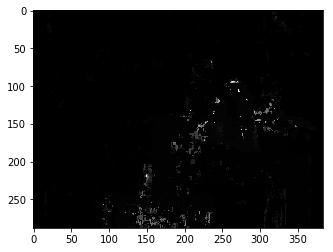

In [283]:
output = run_backwards(img_01, img_02, 7)
#plt.imshow(output[3], 'gray')

Uniques in disp map 1
[   0.    1.    4.    9.   16.   25.   36.   49.   64.   81.  100.  121.
  144.  169.  196.  225.]
Uniques in disp map 2
[  0.00000000e+00   1.56250000e-02   3.12500000e-02 ...,   4.86250000e+01
   4.87968750e+01   4.90000000e+01]
Uniques in disp map 3
[  0.00000000e+00   2.44140625e-04   4.88281250e-04 ...,   8.99804688e+00
   8.99877930e+00   9.00000000e+00]
Uniques in disp map 4
[  0.00000000e+00   3.81469727e-06   1.52587891e-05 ...,   9.99984741e-01
   9.99996185e-01   1.00000000e+00]
Uniques in disp map 1
225.0
Uniques in disp map 2
49.0
Uniques in disp map 3
9.0
Uniques in disp map 4
1.0


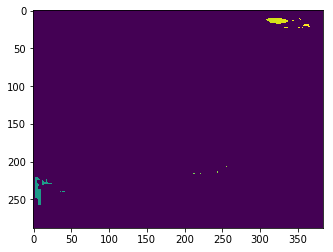

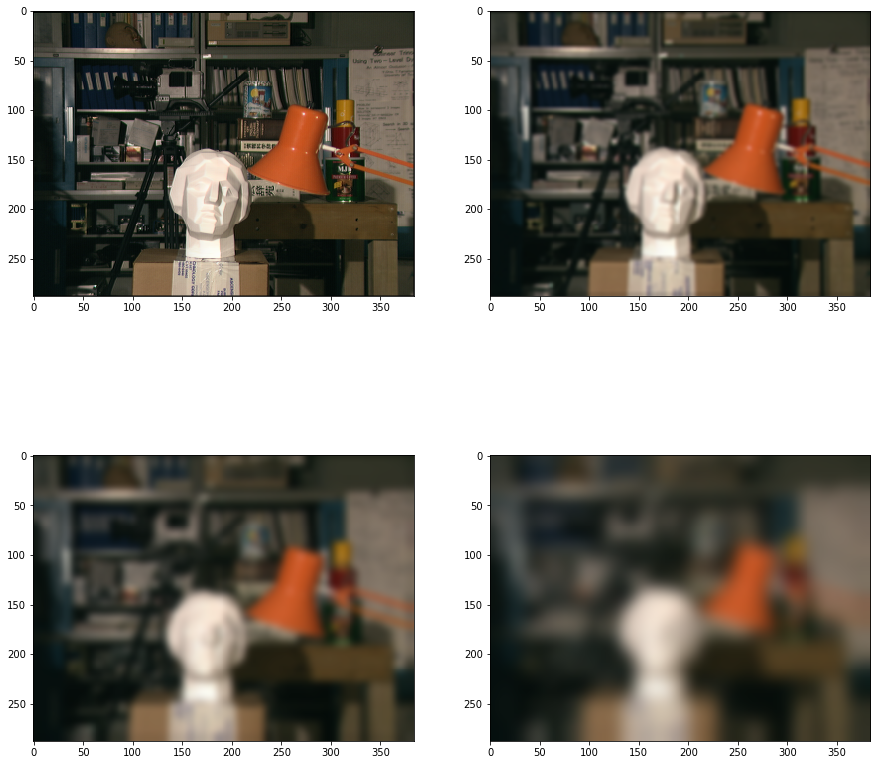

array([  0.00000000e+00,   1.00000000e+00,   4.00000000e+00,
         1.00400400e+06,   1.00600900e+06,   1.00801600e+06,
         1.01002500e+06,   1.01203600e+06,   1.01404900e+06,
         1.01606400e+06,   1.01808100e+06,   1.02212100e+06,
         1.02414400e+06,   1.02616900e+06,   1.02819600e+06,
         1.03022500e+06,   1.03225600e+06,   1.03428900e+06,
         1.03632400e+06,   1.03836100e+06,   1.04040000e+06,
         1.04244100e+06,   1.04448400e+06,   1.04652900e+06,
         1.06915600e+06,   1.07122500e+06,   1.07744400e+06,
         1.07952100e+06,   1.08160000e+06,   1.46652100e+06,
         1.46894400e+06,   1.47136900e+06,   1.48840000e+06,
         1.54256400e+06,   1.54504900e+06,   1.57251600e+06,
         1.57502500e+06,   1.71086400e+06,   1.71348100e+06,
         1.71610000e+06,   1.71872100e+06,   1.72134400e+06,
         1.72396900e+06,   1.72659600e+06,   1.72922500e+06,
         1.73185600e+06,   1.73448900e+06,   1.73712400e+06,
         1.73976100e+06,

In [234]:
plt.imshow(level2[0])

#level2[0].shape
print('Uniques in disp map 1')
print(np.unique(disparity_images_upscaled[0]))
print('Uniques in disp map 2')
print(np.unique(disparity_images_upscaled[1]))
print('Uniques in disp map 3')
print(np.unique(disparity_images_upscaled[2]))
print('Uniques in disp map 4')
print(np.unique(disparity_images_upscaled[3]))

print('Uniques in disp map 1')
print(np.max(disparity_images_upscaled[0]))
print('Uniques in disp map 2')
print(np.max(disparity_images_upscaled[1]))
print('Uniques in disp map 3')
print(np.max(disparity_images_upscaled[2]))
print('Uniques in disp map 4')
print(np.max(disparity_images_upscaled[3]))

plot_images(image1_upscaled)

np.unique(level2[0])

(288, 384)


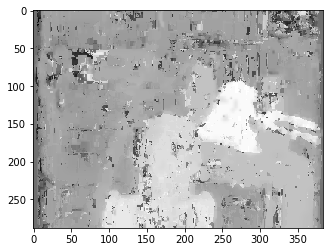

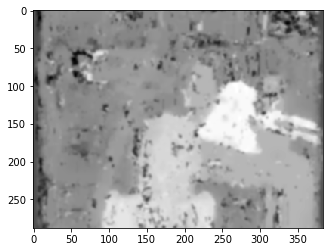

In [52]:
mean_img = np.mean(pyramid_images_up, 0)
print(mean_img.shape)
smooth = cv2.GaussianBlur(mean_img, (7,7), 0)

plt.imshow(mean_img, 'gray')
plt.show()
plt.imshow(smooth, 'gray')
plt.show()

In [57]:
def tester(test_this, true_disp):
    # expected input shapes: (288, 384)
    test_this = test_this/np.max(test_this)
    true_disp = true_disp/np.max(true_disp)
    test = ((test_this - true_disp) * np.max(pyramid_images_up)).reshape(-1)
    mde = test.mean()
    testsq = ((test_this - true_disp) ** 2).reshape(-1)
    mse = testsq.mean()
    print("Mean disparity error:", mde, "\n", "Mean sqared error:", mse)
    stdev = np.std(test)
    print("Standard deviation of disparity error:", stdev)
    i=0
    for x in test:
        if abs(x)>=3:
            i += 1
    p = i/len(test)
    print("Number and fraction of large errors (error ≥ 3 pixels):", i, p)

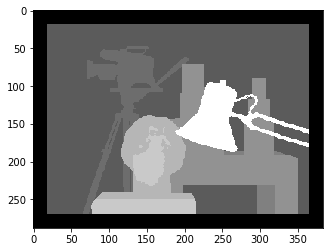

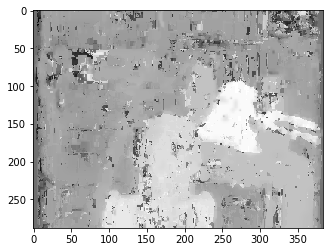

Mean disparity error: 0.585318997375 
 Mean sqared error: 0.0734307947281
Standard deviation of disparity error: 4.02235384882
Number and fraction of large errors (error ≥ 3 pixels): 37441 0.33855070891203703
Mean disparity error: -0.0652759693287 
 Mean sqared error: 0.115676387839
Standard deviation of disparity error: 5.10126712804
Number and fraction of large errors (error ≥ 3 pixels): 39132 0.3538411458333333


In [58]:
truedisp = cv2.imread('tsukuba/truedisp.row3.col3.pgm', 0)
plt.imshow(truedisp, "gray")
plt.show()
plt.imshow(mean_img, 'gray')
plt.show()



tester(mean_img, truedisp)
tester(pyramid_images_up[0], truedisp)